In [64]:
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(knitr)
library(scales)
library(IRdisplay)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')

paired_positions = c('X1.72'='1:72', 'X2.71'='2:71', 'X3.70'='3:70', 'X4.69'='4:69', 'X5.68'='5:68', 'X6.67'='6:67', 'X7.66'='7:66', 'X8.14'='8:14', 'X9.23'='9:23', 'X10.25'='10:25', 'X10.45'='10:45', 'X11.24'='11:24', 'X12.23'='12:23', 'X13.22'='13:22', 'X15.48'='15:48','X18.55'='18:55', 'X19.56'='19:56', 'X22.46'='22:46', 'X26.44'='26:44', 'X27.43'='27:43', 'X28.42'='28:42', 'X29.41'='29:41', 'X30.40'='30:40', 'X31.39'='31:39', 'X49.65'='49:65', 'X50.64'='50:64', 'X51.63'='51:63', 'X52.62'='52:62', 'X53.61'='53:61', 'X54.58'='54:58')
paired_identities = c('GC', 'AU', 'UA', 'CG', 'GU', 'UG', 'Absent', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'AminoKeto', 'KetoAmino', 'Wobble', 'Paired', 'Bulge', 'Mismatched')
paired_colors = c('GC'='gray20', 'AU'='gray20', 'UA'='gray20', 'CG'='gray20', 'GU'='gray20', 'UG'='gray20', 'Absent'='gray20', 'PurinePyrimidine'='gray40', 'PyrimidinePurine'='gray40', 'StrongPair'='gray40', 'WeakPair'='gray40', 'AminoKeto'='gray40', 'KetoAmino'='gray40', 'Wobble'='gray40', 'Paired'='gray40', 'Bulge'='gray40', 'Mismatched'='gray40')

single_positions = c('X8'='8', 'X9'='9', 'X14'='14', 'X15'='15', 'X16'='16', 'X17'='17', 'X17a'='17a', 'X18'='18', 'X19'='19', 'X20'='20', 'X20a'='20a', 'X20b'='20b', 'X21'='21', 'X26'='26', 'X32'='32', 'X33'='33', 'X34'='34', 'X35'='35', 'X36'='36', 'X37'='37', 'X38'='38', 'X44'='44', 'X45'='45', 'X46'='46', 'X47'='47', 'X48'='48', 'X54'='54', 'X55'='55', 'X56'='56', 'X57'='57', 'X58'='58', 'X59'='59', 'X60'='60', 'X73'='73')
single_identities = c('A', 'C', 'G', 'U', 'Absent', 'Purine', 'Pyrimidine', 'Weak', 'Strong', 'Amino', 'Keto', 'B', 'D', 'H', 'V')
single_colors = c('A'='gray20', 'C'='gray20', 'G'='gray20', 'U'='gray20', 'Absent'='gray20', 'Purine'='gray40', 'Pyrimidine'='gray40', 'Weak'='gray40', 'Strong'='gray40', 'Amino'='gray40', 'Keto'='gray40', 'B'='gray40', 'D'='gray40', 'H'='gray40', 'V'='gray40')

identities = read.delim('identities-041718.tsv', sep='\t', stringsAsFactors=FALSE) %>%
  filter(isotype %in% isotypes) %>% 
  mutate(quality = as.logical(quality),
         restrict = as.logical(restrict),
         duplicate = as.logical(duplicate),
         adjusted = as.logical(adjusted),
         abbrev = str_extract(species_long, '^\\w+ \\w+')) %>%
  mutate(abbrev = paste0(str_extract(abbrev, '^\\w'), '. ', str_extract(abbrev, '\\w+$'))) %>%
  mutate(abbrev = ifelse(str_detect(species_long, "sp\\."), paste0(str_extract(species_long, '^\\w+'), ' sp.'), abbrev))
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X17a', 'X18', 'X19', 'X20', 'X20a', 'X20b', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('clade-isotype-freqs.RData')

# Summary

## Fungi diversity

In [2]:
# Fungi break the most universal rules?
identities %>% filter(!restrict) %>% rowwise() %>%
  mutate(matches = 18 - sum(c(X8.14 == 'U:A', X9 %in% c("A", "G"), X11.24 %in% c('C:G', 'U:A'), X15.48 %in% c('G:C', 'A:U'), X16 %in% c('C', 'U'),
         X18.55 == 'G:U', X19.56 == 'G:C', X21 == 'A', X32 %in% c('C', 'U'), X33 %in% c('C', 'U'), X37 %in% c('A', 'G'), X46 %in% c('A', 'G'),
         X48 %in% c('C', 'U'), X52.62 %in% c('G:C', 'A:U'), X53.61 == 'G:C', X54.58 == 'U:A', X57 %in% c('A', 'G'), X60 %in% c('C', 'U')))) %>%
  group_by(clade) %>% mutate(ntRNAs = n()) %>% ungroup %>%
  group_by(clade, matches) %>% summarize(n = n(), ntRNAs = ntRNAs[1]) %>% mutate(n = round(n/ntRNAs, digits = 3)) %>% spread(matches, n, 0)

Warning message:
"Grouping rowwise data frame strips rowwise nature"

,clade,ntRNAs,0,1,2,3,4,5,6
1,Fungi,4804,0.685,0.251,0.053,0.01,0.001,0,0
2,Insect,1664,0.751,0.189,0.036,0.002,0.001,0.021,0
3,Mammal,9663,0.682,0.23,0.056,0.012,0.001,0.019,0
4,Nematode,1582,0.736,0.219,0.038,0.004,0.001,0.003,0
5,Plant,4162,0.646,0.236,0.071,0.018,0.006,0.021,0.001
6,Vertebrate,4125,0.606,0.292,0.077,0.012,0.003,0.011,0


In [3]:
# Fungi are different in many ways... including G15 and X47
identities %>% filter(!restrict, isotype == "Phe", clade == "Fungi") %>%
  count(species, X15) %>% spread(X15, n, 0) %>% filter(G == 0)
identities %>% filter(!restrict, isotype %in% c("Gly", "His"), clade == "Fungi") %>%
  count(species, isotype, X47) %>% spread(X47, n, 0) %>% filter(`-` == 0)

,species,A,C,G,U
1,botrCine_B05_10,0,4,0,0
2,candAlbi_WO_1,0,0,0,1
3,candDubl_CD36,0,0,0,2
4,candOrth_CO_90_125,0,1,0,0


,species,isotype,-,C,U
1,candOrth_CO_90_125,Gly,0,2,0
2,flamVelu_KACC42780,His,0,3,0
3,yarrLipo_CLIB122,Gly,0,4,0
4,yarrLipo_PO1F,Gly,0,5,0
5,yarrLipo_WSH_Z06,Gly,0,4,0


# Positions

## 8:14

In [5]:
# species check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X8.14) %>% 
  count(clade, species, isotype, X8.14) %>% spread(X8.14, n, 0) %>% filter(`U:A` == 0)

# clade/isotype quantification
identities %>% select(clade, isotype, restrict, X8.14) %>% filter(!restrict, X8.14 != 'U:A') %>%
  count(clade, isotype, X8.14) %>% spread(isotype, n, 0)

,clade,species,isotype,-:A,A:A,C:A,G:A,U:A,U:C,U:G,U:U
1,Fungi,sporReil_SRZ2,Cys,0,2,0,0,0,0,0,0
2,Fungi,ustiMayd_521,Cys,0,1,0,0,0,0,0,0


,clade,X8.14,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,Ile,Leu,Lys,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,Fungi,A:A,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungi,U:G,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Insect,C:A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Mammal,-:A,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1
5,Mammal,A:A,0,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,0,0
6,Mammal,C:A,0,1,6,3,5,0,11,0,1,2,5,1,0,5,1,0,1,1
7,Mammal,G:A,1,0,1,0,4,0,2,0,1,1,6,0,0,0,0,0,1,0
8,Mammal,U:C,0,0,0,0,2,0,0,1,1,0,0,1,0,0,0,0,1,0
9,Mammal,U:G,0,1,3,0,3,1,0,8,2,0,2,0,1,3,1,0,0,1
10,Mammal,U:U,0,0,0,0,1,0,0,0,0,1,3,2,0,0,0,0,0,0


## R9

In [17]:
# clade/isotype check
best_freqs %>% filter(positions == 'X9', !(feature %in% c('A', 'G', 'Purine')))

# clade/isotype quantification
identities %>% select(clade, isotype, restrict, X9) %>% filter(!restrict, X9 != 'A' & X9 != 'G') %>%
  count(clade, isotype, X9) %>% spread(isotype, n, 0)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,His,X9,24,C,23,0.958333333333333
2,Vertebrate,His,X9,63,C,59,0.936507936507937
3,Mammal,His,X9,78,C,73,0.935897435897436
4,Insect,Glu,X9,75,Keto,74,0.986666666666667
5,Plant,Glu,X9,184,Amino,180,0.978260869565217
6,Fungi,His,X9,139,V,139,1


,clade,X9,Arg,Asn,Asp,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,Fungi,C,0,0,2,8,0,8,26,0,0,0,0,0,2,1,0,0,2,1
2,Fungi,U,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Insect,-,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Insect,C,0,0,0,0,1,0,23,0,0,0,0,0,0,0,0,0,0,0
5,Insect,U,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Mammal,C,0,0,0,1,2,1,73,1,0,1,1,0,0,0,1,0,0,0
7,Mammal,U,0,1,0,0,6,0,0,0,1,7,0,2,0,0,0,1,0,0
8,Nematode,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,Nematode,C,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1
10,Nematode,U,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1


In [150]:
# odd bumps in Glu, His, Phe
identities %>% filter(((clade %in% c("Fungi", "Insect", "Mammal", "Vertebrate")) & isotype == "His") | 
                      ((clade %in% c("Insect", "Plant")) & isotype == "Glu")) %>%
  select(clade, isotype, X9) %>% group_by(clade, isotype, X9) %>% tally %>% spread(X9, n, 0)

,clade,isotype,A,C,G,U
1,Fungi,His,223,59,36,0
2,Insect,Glu,0,1,136,163
3,Insect,His,1,119,0,0
4,Mammal,His,1,365,4,0
5,Plant,Glu,405,256,2,2
6,Vertebrate,His,2,183,0,2


In [12]:
# check each individually for species
identities %>% filter(!restrict, clade == "Insect", isotype == "Glu") %>% select(species, X9) %>% count(species, X9) %>% spread(X9, n, 0)
identities %>% filter(!restrict, clade == "Insect", isotype == "His") %>% select(species, X9) %>% count(species, X9) %>% spread(X9, n, 0)
identities %>% filter(!restrict, clade == "Mammal", isotype == "His") %>% select(species, X9) %>% count(species, X9) %>% spread(X9, n, 0)
identities %>% filter(!restrict, clade == "Plant", isotype == "Glu") %>% select(species, X9) %>% count(species, X9) %>% spread(X9, n, 0)
identities %>% filter(!restrict, clade == "Vertebrate", isotype == "His") %>% select(species, X9) %>% count(species, X9) %>% spread(X9, n, 0)

,species,C,G,U
1,anoGam2,0,3,2
2,apiMel1,0,2,0
3,bomTer1,0,3,0
4,dm6,0,1,3
5,dp4,0,1,3
6,droAna3,0,1,3
7,droEre2,0,2,3
8,droGri2,1,1,3
9,droMoj3,0,1,3
10,droPer1,0,2,2


,species,A,C
1,anoGam2,0,3
2,apiMel1,0,1
3,bomTer1,0,2
4,dm6,0,1
5,dp4,0,1
6,droAna3,0,1
7,droEre2,0,1
8,droGri2,0,1
9,droMoj3,0,2
10,droPer1,0,1


,species,A,C,G
1,ailMel1,0,1,0
2,balAcu1,0,1,0
3,bosTau8,0,1,0
4,calJac3,0,2,0
5,canFam3,0,1,0
6,cavPor3,0,1,0
7,cerSim1,0,1,0
8,criGri1,0,2,0
9,dasNov3,1,2,0
10,dipOrd1,0,1,0


,species,A,C,G,U
1,araTha1,3,4,0,0
2,braDis3,3,4,0,0
3,braOle1,13,8,0,0
4,carPap1,3,3,0,0
5,cucSat1,4,4,0,0
6,fraVes1,4,2,0,0
7,glyMax2,6,4,0,0
8,gosRai2,3,3,0,0
9,malDom1,5,4,0,1
10,manEsc6,7,2,0,0


,species,A,C,U
1,anoCar2,0,1,0
2,calMil1,0,4,0
3,chrPic1,1,4,0
4,fr3,0,4,0
5,gadMor1,0,4,0
6,galGal4,0,2,1
7,gasAcu1,0,7,0
8,geoFor1,0,2,0
9,latCha1,0,2,0
10,melGal1,0,2,0


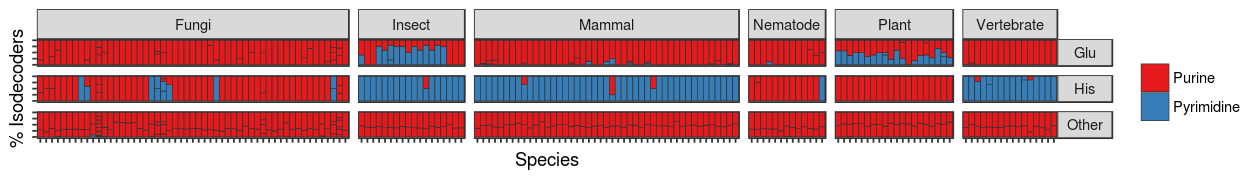

In [9]:
options(repr.plot.width=10.5, repr.plot.height=1.5)
identities %>% filter(!restrict, isotype == "Glu") %>%
  count(isotype, clade, species_long, X9) %>%
  rbind(identities %>% filter(!restrict, isotype == "His") %>% count(isotype, species_long, clade, X9)) %>% 
  rbind(identities %>% filter(!restrict, !(isotype %in% c("Glu", "His"))) %>% 
          count(species_long, clade, X9) %>% 
          mutate(isotype = "Other")) %>% 
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+"),
         purine = ifelse(X9 %in% c("A", "G"), "Purine", "Pyrimidine")) %>%
  group_by(clade, isotype, species_long) %>%
  mutate(n = n/sum(n)) %>%
  droplevels %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = purine), width = 1, color = 'gray20', size = 0.2, stat = 'identity', position = 'stack') +
    facet_grid(isotype ~ clade, scales = "free", space = "free") +
    scale_fill_brewer(palette = 'Set1') + 
    theme(axis.text = element_blank(),
          strip.text.y = element_text(angle = 0),
          legend.title = element_blank()) +
    labs(x = "Species", y = "% Isodecoders")

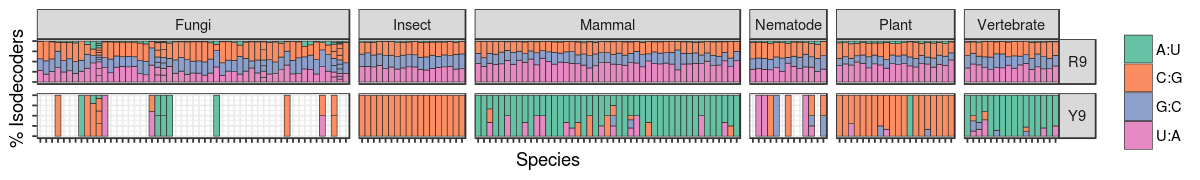

In [10]:
options(repr.plot.width=10, repr.plot.height=1.5)
identities %>% filter(!restrict) %>%
  filter(X12.23 %in% c("U:A", "G:C", "C:G", "A:U")) %>%
  mutate(purine = ifelse(X9 %in% c("A", "G"), "R9", ifelse(X9 != "-", "Y9", "-9"))) %>%
#   mutate(purine = relevel(as.factor(ifelse(X9 %in% c("A", "G"), "R9", paste0(X9, "9"))), "R9")) %>%
  filter(purine != "-9") %>%
  count(clade, species_long, purine, X12.23) %>%
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(clade, purine, species_long) %>%
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X12.23), width = 1, color = 'gray20', size = 0.2, stat = 'identity') + 
    facet_grid(purine ~ clade, scales = "free", space = "free") +
    scale_fill_brewer(palette = 'Set2') + 
    theme(axis.text = element_blank(),
          strip.text.y = element_text(angle = 0),
          legend.title = element_blank()) + 
    labs(x = "Species", y = "% Isodecoders")

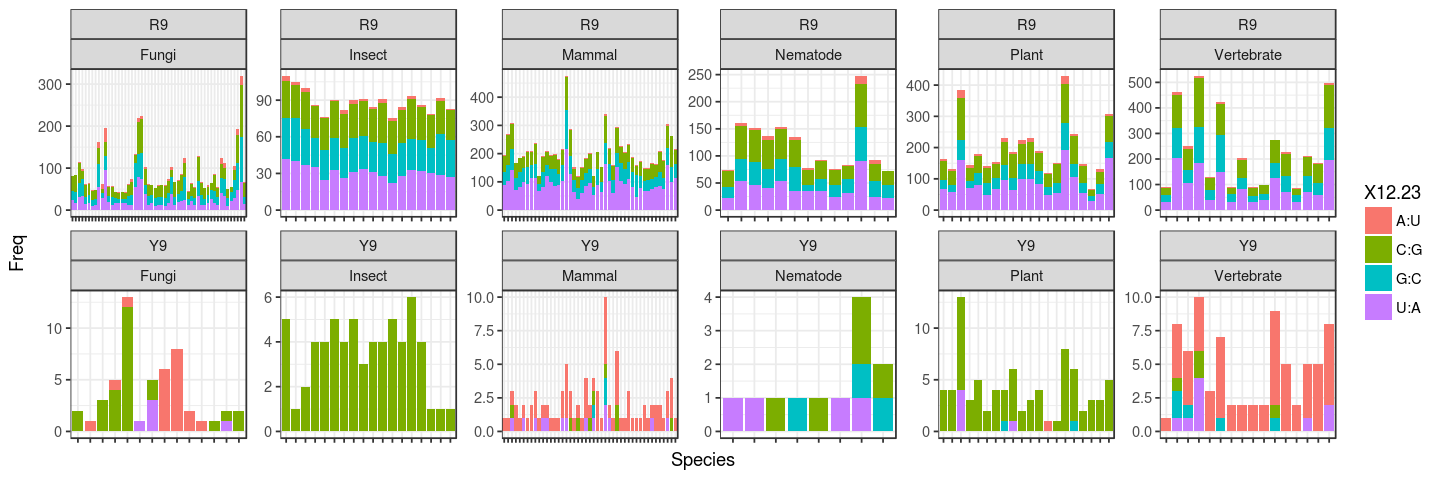

In [11]:
options(repr.plot.width=12, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  filter(X12.23 %in% c("U:A", "G:C", "C:G", "A:U")) %>%
  mutate(purine = ifelse(X9 %in% c("A", "G"), "R9", ifelse(X9 != "-", "Y9", "-9"))) %>%
#   mutate(purine = relevel(as.factor(ifelse(X9 %in% c("A", "G"), "R9", paste0(X9, "9"))), "R9")) %>%
  filter(purine != "-9") %>%
  count(clade, species_long, purine, X12.23) %>%
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(clade, purine, species_long) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X12.23), stat = 'identity') + 
    facet_wrap(purine ~ clade, scales = "free", nrow = 2) +
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "Freq")

## Y11:R24

Also see identity-stories

In [29]:
# species/isotype check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X11.24) %>% 
  count(clade, species, isotype, X11.24) %>%
  filter(n != 0) %>% spread(X11.24, n, 0) %>% filter(`C:G` == 0 & `U:A` == 0)

# clade/isotype check
best_freqs %>% filter(positions == 'X11.24', !(feature %in% c('CG', 'UA', 'PyrimidinePurine')))

,clade,species,isotype,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:A,G:C,G:G,U:A,U:C,U:G,U:U
1,Fungi,aspeFumi_AF293,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Fungi,crypGatt_WM276,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Fungi,crypNeof_VAR_GRUBII_H99,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fungi,crypNeof_VAR_NEOFORMANS_B_3501,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,Fungi,crypNeof_VAR_NEOFORMANS_JEC21,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,Fungi,flamVelu_KACC42780,His,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
7,Fungi,schiPomb_972H,iMet,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Val,X11.24,338,Paired,338,1
2,Plant,Met,X11.24,110,Paired,110,1
3,Mammal,Met,X11.24,283,Paired,277,0.978798586572438
4,Vertebrate,Asn,X11.24,138,Paired,131,0.949275362318841


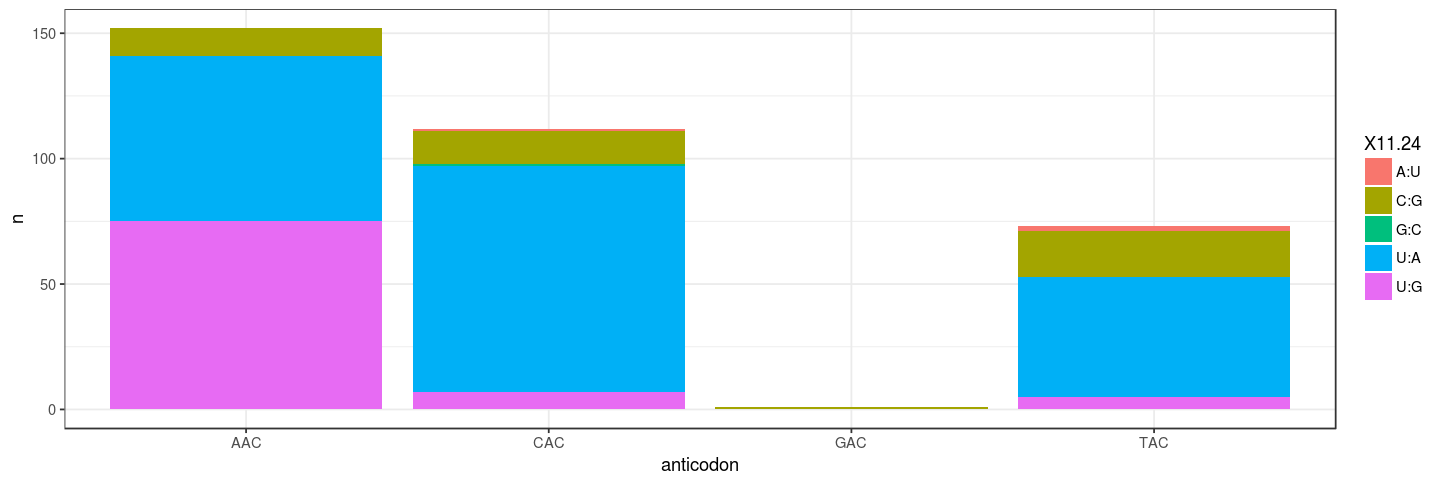

In [13]:
identities %>% 
  filter(!restrict, clade == "Fungi", isotype == "Val") %>%
  count(anticodon, X11.24) %>%
  ggplot() + geom_bar(aes(x = anticodon, y = n, fill = X11.24), stat = 'identity')

## R15:Y48

In [37]:
# check no. isotypes without R15:Y48
identities %>% filter(!restrict) %>% count(species, isotype, X15.48) %>% spread(X15.48, n, fill = 0) %>% 
  filter(`G:C` == 0 & `A:U` == 0) %>% ungroup %>% count(isotype)

# check no. species with tRNAs of an isotype without R15:Y48
identities %>% filter(!restrict) %>% count(species, isotype, X15.48) %>% spread(X15.48, n, fill = 0) %>% 
  filter(`G:C` == 0 & `A:U` == 0) %>%
  ungroup %>% group_by(species) %>% summarize(isotype = paste(isotype, collapse = '/'))

,isotype,n
1,Ala,17
2,Asn,1
3,Asp,4
4,Gln,1
5,Glu,14
6,His,4
7,Met,4
8,Phe,4


,species,isotype
1,araTha1,Ala
2,ashbGoss_ATCC10895,Glu
3,aspeFumi_AF293,Asp
4,aspeNidu_FGSC_A4,Asp
5,botrCine_B05_10,Asp/Phe
6,braDis3,Ala
7,candAlbi_WO_1,Phe
8,candDubl_CD36,Phe
9,candGlab_CBS_138,Glu
10,candOrth_CO_90_125,Phe


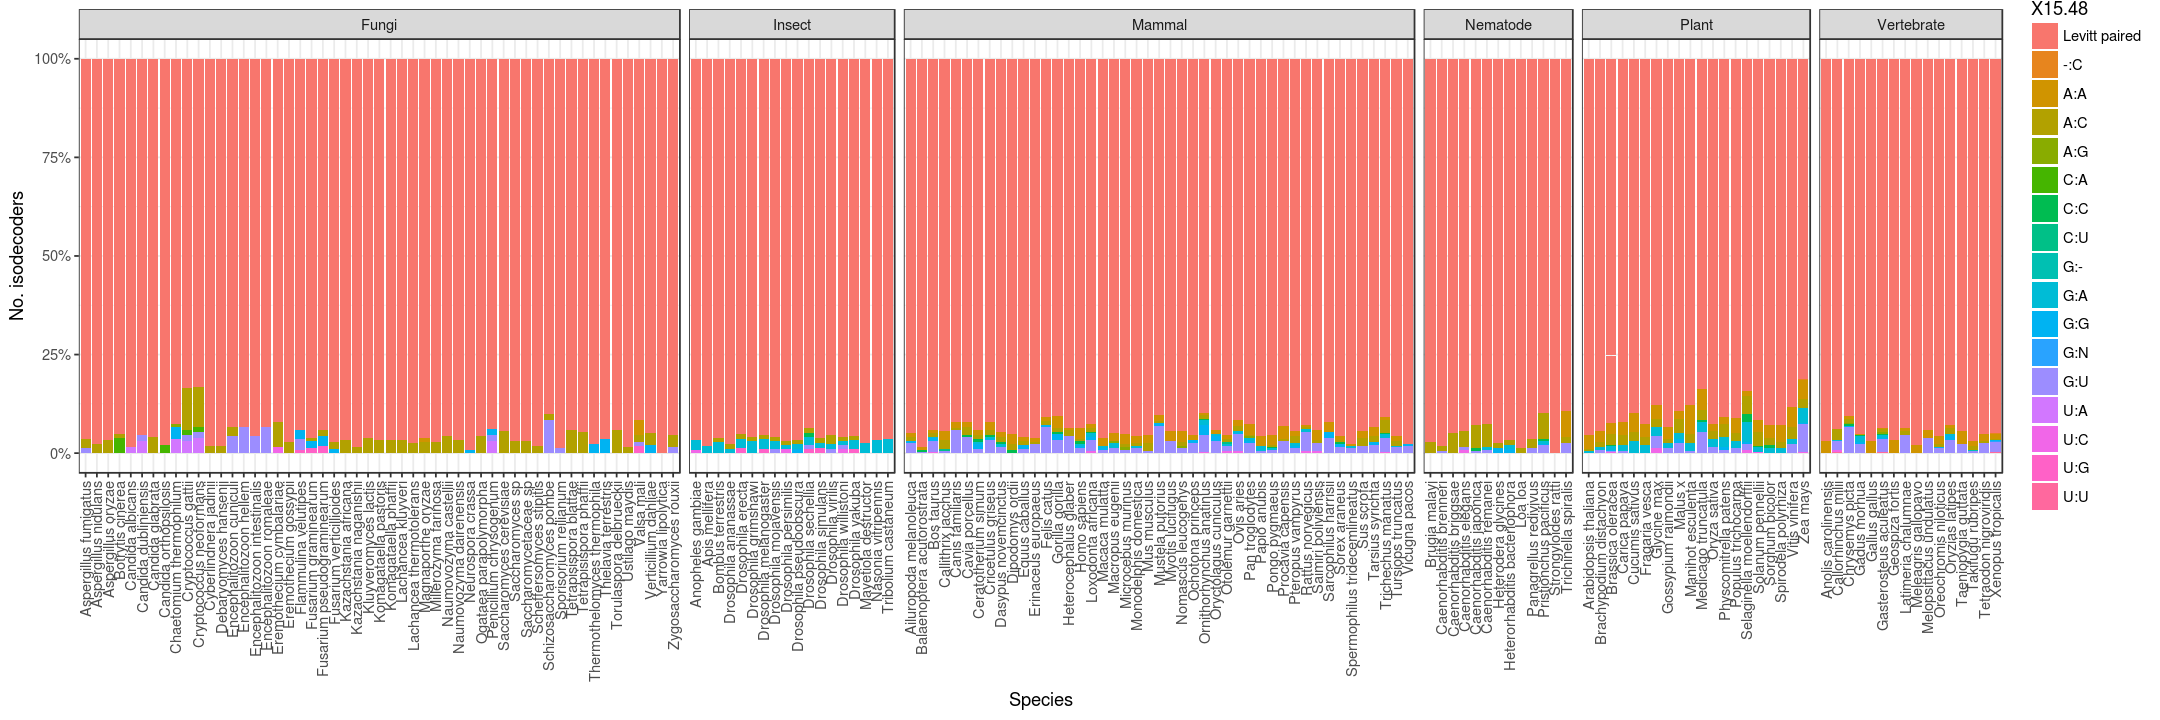

In [38]:
options(repr.plot.width=18, repr.plot.height=6)
identities %>% filter(!restrict) %>% count(clade, species_long, isotype, X15.48) %>% 
  ungroup %>%
  mutate(X15.48 = ifelse(X15.48 %in% c("G:C", "A:U"), "Levitt paired", X15.48),
         species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  mutate(X15.48 = relevel(as.factor(X15.48), "Levitt paired")) %>%
  group_by(species_long, clade) %>% 
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X15.48), stat = 'identity') +
    facet_grid( ~ clade, scales = "free", space = "free") +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Species", y = "No. isodecoders")

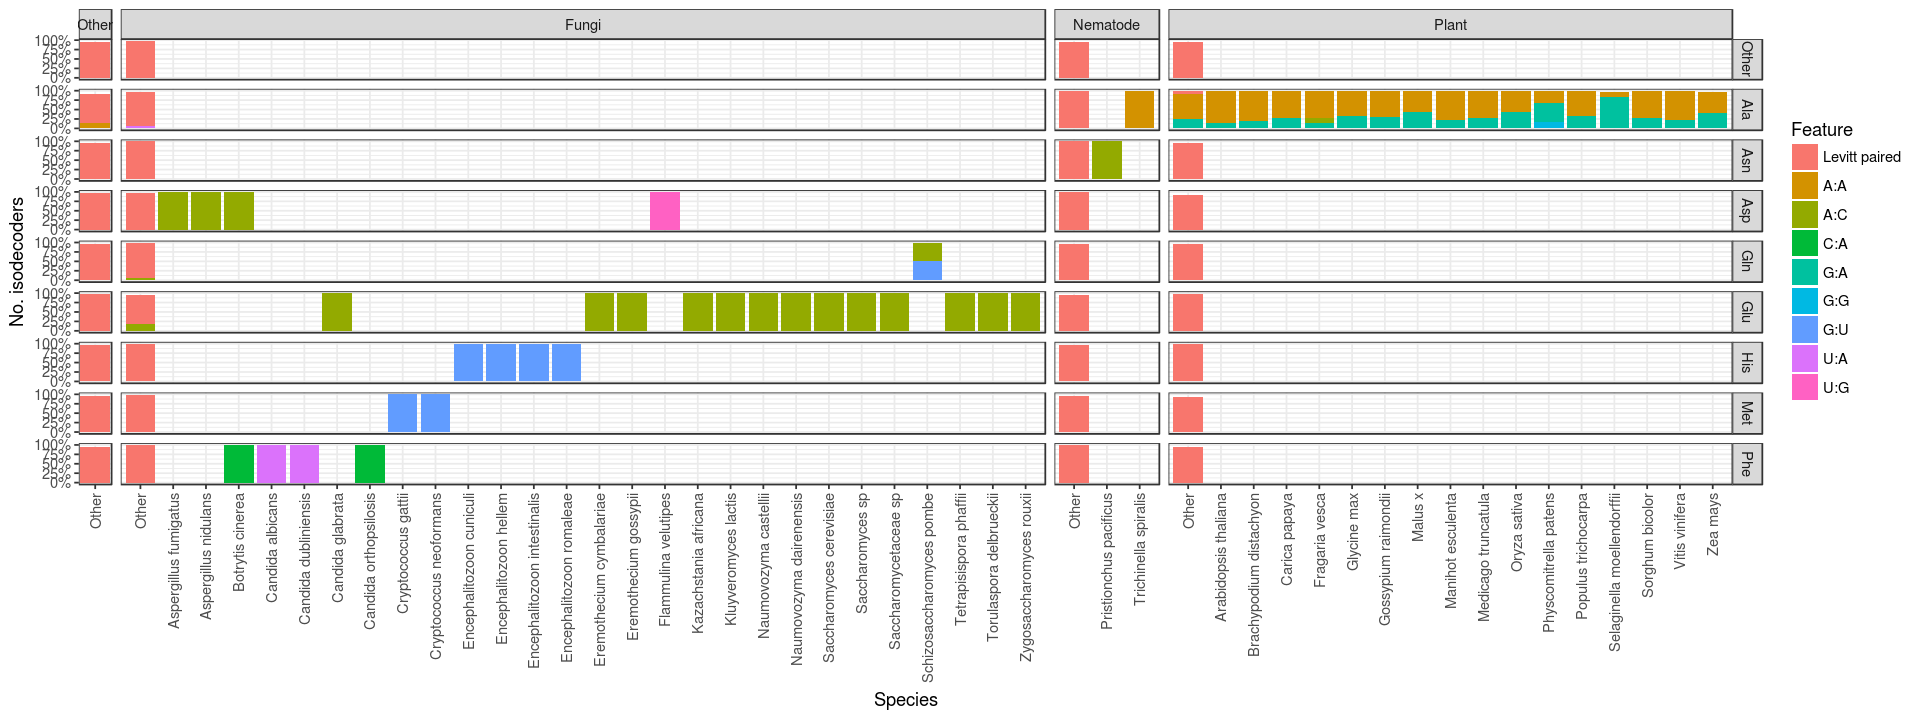

In [16]:
options(repr.plot.width=16, repr.plot.height=6)
identities %>% filter(!restrict) %>% count(clade, species_long, isotype, X15.48) %>% spread(X15.48, n, 0) %>%
  ungroup %>%
  mutate(species_long = relevel(as.factor(ifelse(`G:C` == 0 & `A:U` == 0, str_extract(species_long, "^\\w+ \\w+"), "Other")), "Other"),
         isotype = relevel(as.factor(ifelse(isotype %in% c("Asp", "Phe", "Glu", "Met", "His", "Asn", "Ala", "Gln"), isotype, "Other")), "Other"),
         clade = relevel(as.factor(ifelse(clade %in% c("Fungi", "Nematode", "Plant"), clade, "Other")), "Other")) %>%
  gather(Feature, n, -clade, -species_long, -isotype) %>% 
  mutate(Feature = relevel(as.factor(ifelse(Feature %in% c("G:C", "A:U"), "Levitt paired", Feature)), "Levitt paired")) %>%
  group_by(species_long, clade, Feature, isotype) %>%
  summarize(n = sum(n)) %>%
  group_by(species_long, clade, isotype) %>%
  mutate(n = n / sum(n)) %>% 
  filter(n > 0.05) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = Feature), stat = 'identity') + 
    facet_grid(isotype ~ clade, space = 'free', scales = 'free') +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Species", y = "No. isodecoders")

## Y16

In [17]:
# check no. isotypes without Y16
identities %>% filter(!restrict) %>% count(species, isotype, X16) %>% spread(X16, n, fill = 0) %>% 
  filter(C == 0 & U == 0) %>% ungroup %>% count(isotype)

# check no. species with tRNAs of an isotype without R15:Y48
identities %>% filter(!restrict) %>% count(species, isotype, X16) %>% spread(X16, n, fill = 0) %>% 
  filter(C == 0 & U == 0) %>% 
  ungroup %>% select(species) %>% unique

,isotype
1,Pro
2,iMet
3,His
4,Cys
5,Phe
6,Ala
7,Asp
8,Trp
9,Glu


,species
1,anoCar2
2,anoGam2
3,aspeFumi_AF293
4,aspeOryz_RIB40
5,bomTer1
6,candOrth_CO_90_125
7,cavPor3
8,chaeTher_VAR_THERMOPHILUM_DSM1
9,chrPic1
10,criGri1


## 18:55, 19:56

In [42]:
# 18:55 fails isotype/species check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X18.55) %>%
  count(clade, species, isotype, X18.55) %>% spread(X18.55, n, 0) %>% filter(`G:U` == 0)

# 18:55 clade/isotype check
best_freqs %>% filter(positions == 'X19.56', feature != 'GC')

,clade,species,isotype,-:U,A:G,A:U,C:U,G:-,G:A,G:C,G:G,G:U,U:U
1,Fungi,flamVelu_KACC42780,Pro,0,0,2,2,0,0,0,0,0,0


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq


In [144]:
identities %>% filter(clade == "Fungi", isotype == "Pro") %>%
  count(species_long, X18.55, anticodon, restrict) %>%
  group_by(species_long) %>% mutate(exceptional = any(X18.55[!restrict] != 'G:U')) %>% ungroup %>%
  filter(exceptional) %>%
  group_by(species_long, X18.55, anticodon) %>% summarize(unique = sum(n[!restrict]), total = sum(n)) %>%
  arrange(species_long, anticodon)

,species_long,X18.55,anticodon,unique,total
1,Aspergillus nidulans FGSC A4,G:U,AGG,5,6
2,Aspergillus nidulans FGSC A4,G:U,CGG,1,2
3,Aspergillus nidulans FGSC A4,C:U,TGG,2,2
4,Flammulina velutipes KACC42780,A:U,AGG,1,4
5,Flammulina velutipes KACC42780,A:U,CGG,1,2
6,Flammulina velutipes KACC42780,C:U,TGG,2,4
7,Valsa mali 03-8,G:U,CGG,1,1
8,Valsa mali 03-8,C:U,TGG,2,2
9,Yarrowia lipolytica CLIB122,G:U,AGG,1,21
10,Yarrowia lipolytica CLIB122,G:U,CGG,2,2


## A21

In [93]:
identities %>% filter(!restrict) %>% select(clade, species_long, isotype, X8.14.21) %>% 
  count(clade, species_long, isotype, X8.14.21) %>% spread(X8.14.21, n, 0) %>% filter(`U:A:A` == 0) %>%
  gather(`8:14:21`, n, -clade, -species_long, -isotype) %>% filter(n != 0) %>%
  arrange(species_long, isotype)

,clade,species_long,isotype,8:14:21,n
1,Fungi,Aspergillus nidulans FGSC A4,Phe,U:A:U,2
2,Fungi,Penicillium chrysogenum P2niaD18,iMet,U:A:G,1
3,Fungi,Schizosaccharomyces pombe 972h-,Met,U:A:G,2
4,Fungi,Sporisorium reilianum SRZ2,Cys,A:A:U,2
5,Fungi,Sporisorium reilianum SRZ2,Phe,U:A:C,4
6,Fungi,Ustilago maydis 521,Cys,A:A:U,1
7,Fungi,Ustilago maydis 521,Phe,U:A:C,2


## U33

In [23]:
# Clade/isotype quantification
identities %>% filter(!restrict) %>% select(clade, isotype, X33) %>% filter(X33 != "U") %>%
  count(clade, isotype, X33) %>% spread(isotype, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|clade      |X33 | Ala| Arg| Asp| Cys| Gln| Glu| Gly| His| Ile| Leu| Lys| Met| Phe| Pro| Ser| Thr| Trp| Tyr| Val| iMet|
|:----------|:---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|----:|
|Fungi      |A   |   1|   0|   0|   0|   2|   1|   1|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|    0|
|Fungi      |C   |   8|   0|   0|   0|   0|   0|   4|   0|   0|  14|   0|   1|   1|   0|   4|   1|   0|   0|   1|    1|
|Fungi      |G   |   0|   0|   0|   0|   0|   1|   0|   0|   0|   6|   0|   0|   0|   0|   1|   0|   0|   0|   0|    0|
|Insect     |A   |   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|    0|
|Insect     |C   |   0|   0|   0|   1|   0|   0|   2|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   32|
|Mammal     |A   |   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|    0|
|Mammal     |C   |   6|   0|   2|   3|   0|   0|   1|   1|   3|   1|  10|   1|   2|   0|   0|   1|   6|   3|   0|   86|
|Mammal     |G   |   1|   0|   0|   1|   0|   0|   0|   0|   0|   0|   2|   0|   1|   0|   1|   0|   0|   1|   0|    0|
|Nematode   |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   2|   0|   0|   0|   0|    0|
|Nematode   |C   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   3|   0|   0|   0|   0|   17|
|Nematode   |G   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   6|   0|   0|   0|   0|    0|
|Plant      |A   |   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|    0|
|Plant      |C   |   0|   0|   0|   0|   1|   0|   2|   0|   0|   0|   0|   0|   1|   0|   1|   1|   0|   0|   1|   53|
|Plant      |G   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   2|   0|   0|   0|   0|   1|    0|
|Vertebrate |A   |   0|   1|   0|   0|   1|   1|   0|   0|   0|   0|   4|   0|   1|   0|   1|   0|   0|   0|   1|    0|
|Vertebrate |C   |   0|   1|   0|   0|   0|   3|   1|   1|   1|   2|   4|   0|   2|   0|   0|   0|   1|   3|   0|   62|
|Vertebrate |G   |   1|   0|   0|   1|   3|   0|   0|   0|   0|   0|   2|   0|   0|   0|   2|   0|   0|   0|   0|    0|

In [24]:
# No. species with only C33, no. species with only U33, and no. species with both
identities %>% filter(!restrict) %>% select(clade, species, isotype, X33) %>% 
  filter(isotype == "iMet") %>%
  count(clade, species, isotype, X33) %>% spread(X33, n, 0) %>% 
  group_by(clade) %>% summarize(Cs = sum(C > 0 & U == 0), Us = sum(U > 0 & C == 0), CUs = sum(U > 0 & C > 0))

# which fungi is it
identities %>% filter(!restrict, clade == "Fungi", isotype == 'iMet') %>% select(species, X33) %>%
  count(species, X33) %>% spread(X33, n, 0) %>% filter(U == 0)

,clade,Cs,Us,CUs
1,Fungi,1,60,0
2,Insect,18,0,0
3,Mammal,43,0,2
4,Nematode,12,0,1
5,Plant,20,0,0
6,Vertebrate,14,0,2


,species,C,U
1,flamVelu_KACC42780,1,0


## R37

In [27]:
identities %>% filter(!restrict) %>% select(clade, species, isotype, X37) %>%
  count(clade, species, isotype, X37) %>% spread(X37, n, 0) %>%
  filter(A + G < 1)

,clade,species,isotype,-,A,C,G,U


## R46

In [28]:
# clade/isotype check
best_freqs %>% filter(positions == "X46", !(feature %in% c("A", "G", "Purine")))

clade_iso_freqs %>% filter(clade == "Fungi", isotype == "Leu", positions == "X46", n > 5)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Leu,X46,459,Keto,434,0.945533769063181


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Leu,X46,459,A,10,0.0217864923747277
2,Fungi,Leu,X46,459,G,404,0.880174291938998
3,Fungi,Leu,X46,459,U,30,0.065359477124183
4,Fungi,Leu,X46,459,Absent,10,0.0217864923747277
5,Fungi,Leu,X46,459,Purine,404,0.880174291938998
6,Fungi,Leu,X46,459,Pyrimidine,30,0.065359477124183
7,Fungi,Leu,X46,459,Weak,30,0.065359477124183
8,Fungi,Leu,X46,459,Strong,404,0.880174291938998
9,Fungi,Leu,X46,459,Keto,434,0.945533769063181
10,Fungi,Leu,X46,459,B,434,0.945533769063181


In [29]:
# Clade/isotype quantification
identities %>% filter(!restrict) %>% select(clade, isotype, X46) %>% filter(X46 != "A" & X46 != "G") %>%
  count(clade, isotype, X46) %>% spread(isotype, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|clade      |X46 | Ala| Arg| Asn| Asp| Cys| Gln| Gly| His| Ile| Leu| Lys| Met| Phe| Pro| Ser| Thr| Trp| Tyr| Val|
|:----------|:---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
|Fungi      |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|  10|   0|   0|   0|   0|   0|   0|   0|   0|   0|
|Fungi      |C   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   5|   0|   1|   0|   0|  20|   0|   0|   0|   0|
|Fungi      |U   |   0|   0|   0|   0|   0|   0|   1|   0|   0|  30|   0|   0|   0|   0|  14|   0|   0|   0|   2|
|Insect     |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|
|Insect     |U   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|
|Mammal     |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   1|   0|   0|
|Mammal     |C   |   2|   0|   4|   0|   0|   0|   0|   0|   0|   1|   4|   0|   0|   0|   3|   0|   0|   0|   5|
|Mammal     |U   |   2|   2|   1|   0|   1|   0|   0|   0|   0|  15|   7|   1|   4|   1|   4|   1|   0|   0|   0|
|Nematode   |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|
|Nematode   |C   |   0|   0|   0|   0|   0|   0|   0|   0|   2|   3|   1|   0|   0|   0|   0|   0|   0|   0|   0|
|Nematode   |N   |   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
|Nematode   |U   |   0|   1|   0|   0|   0|   0|   0|   1|   0|  10|   0|   0|   0|   0|   0|   0|   1|   0|   4|
|Plant      |-   |   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|  43|   0|   0|   0|   0|
|Plant      |C   |   0|   0|   3|   1|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   4|   0|   0|   0|   0|
|Plant      |U   |   0|   1|   0|   0|  10|   0|   0|   0|   2|   0|   0|   5|   0|   1|   3|   0|   0|   1|   0|
|Vertebrate |C   |   0|   0|   2|   0|   0|   0|   0|   0|   0|  15|   0|   0|   0|   0|   2|   1|   0|   0|   0|
|Vertebrate |U   |   2|   2|   5|   0|   2|   0|   0|   0|   2|   7|   1|   1|   1|   0|   2|   1|   0|   2|   4|

## R48

In [31]:
best_freqs %>% filter(positions == "X48", !(feature %in% c("C", "U", "Pyrimidine")))

identities %>% filter(!restrict, isotype == "Ala") %>% select(clade, isotype, X48) %>% 
  group_by(clade, isotype, X48) %>% tally %>% spread(X48, n, 0)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Plant,Ala,X48,235,A,226,0.961702127659574
2,Vertebrate,Ala,X48,254,Amino,252,0.992125984251969
3,Insect,Ala,X48,97,Amino,96,0.989690721649485
4,Mammal,Ala,X48,988,Amino,944,0.955465587044534


,clade,isotype,A,C,G,U
1,Fungi,Ala,24,271,4,1
2,Insect,Ala,35,61,0,1
3,Mammal,Ala,173,771,25,19
4,Nematode,Ala,5,92,0,1
5,Plant,Ala,226,6,3,0
6,Vertebrate,Ala,47,205,0,2


## R52:Y62

In [32]:
best_freqs %>% filter(positions == "X52.62", !(feature %in% c("GC", "AU", "PurinePyrimidine")))

identities %>% filter(!restrict) %>% select(clade, species, isotype, X52.62) %>% 
  count(clade, isotype, X52.62) %>% spread(X52.62, n, 0)

identities %>% filter(!restrict) %>% select(clade, species, isotype, X52.62) %>% 
  count(clade, species, X52.62) %>% spread(X52.62, n, 0) %>%
  filter((`G:C` + `A:U`) / (`A:C` + `A:G` + `A:U` + `C:A` + `C:C` + `C:G` + `C:U` + `G:-` + `G:A` + `G:C` + `G:G` + `G:U` + `U:A` + `U:C` + `U:G` + `U:U`) < 0.9)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Vertebrate,Trp,X52.62,111,UA,110,0.990990990990991
2,Mammal,Trp,X52.62,249,UA,231,0.927710843373494
3,Fungi,Trp,X52.62,115,StrongPair,113,0.982608695652174
4,Fungi,Pro,X52.62,229,StrongPair,223,0.973799126637555
5,Insect,Trp,X52.62,37,WeakPair,36,0.972972972972973
6,Fungi,iMet,X52.62,95,StrongPair,88,0.926315789473684
7,Plant,Phe,X52.62,107,WeakPair,99,0.925233644859813
8,Fungi,Ala,X52.62,300,StrongPair,271,0.903333333333333
9,Nematode,Trp,X52.62,29,PyrimidinePurine,27,0.931034482758621
10,Fungi,Phe,X52.62,148,Paired,148,1


,clade,isotype,-:C,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:-,G:A,G:C,G:G,G:U,U:A,U:C,U:G,U:U
1,Fungi,Ala,0,0,1,0,18,0,0,21,0,0,0,250,0,0,7,0,3,0
2,Fungi,Arg,0,0,4,0,29,0,0,9,0,0,0,401,0,0,3,0,1,0
3,Fungi,Asn,0,0,0,0,128,0,0,0,0,0,0,21,0,0,0,0,0,0
4,Fungi,Asp,0,0,0,0,11,0,0,0,0,0,0,97,0,0,0,0,0,0
5,Fungi,Cys,0,0,2,0,34,0,0,15,0,0,0,38,0,0,28,0,0,0
6,Fungi,Gln,0,0,12,0,14,0,0,0,0,0,0,211,0,0,0,0,0,0
7,Fungi,Glu,0,0,0,0,6,0,0,0,0,0,0,236,0,0,0,0,0,0
8,Fungi,Gly,0,0,1,0,9,0,0,21,0,0,0,215,0,22,13,1,0,0
9,Fungi,His,0,0,4,0,40,0,0,2,0,0,0,53,0,21,16,2,0,1
10,Fungi,Ile,0,0,0,0,71,0,0,0,0,0,0,119,0,0,0,0,0,0


,clade,species,-:C,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:-,G:A,G:C,G:G,G:U,U:A,U:C,U:G,U:U
1,Fungi,ashbGoss_ATCC10895,0,0,1,0,18,0,0,0,0,0,0,47,0,3,4,0,0,0
2,Fungi,aspeFumi_AF293,0,0,1,0,11,0,0,9,0,0,0,57,0,0,4,0,0,0
3,Fungi,aspeNidu_FGSC_A4,0,0,0,0,15,0,0,12,0,0,0,54,0,0,2,0,1,0
4,Fungi,botrCine_B05_10,0,0,0,0,9,0,0,7,0,0,0,72,0,0,14,0,0,0
5,Fungi,candGlab_CBS_138,0,0,0,0,14,0,0,1,0,0,0,29,0,3,1,0,0,0
6,Fungi,chaeTher_VAR_THERMOPHILUM_DSM1,0,0,0,0,42,0,0,19,0,0,0,98,0,0,5,0,0,0
7,Fungi,crypGatt_WM276,0,0,0,0,11,0,0,7,0,0,0,46,0,0,3,0,0,0
8,Fungi,crypNeof_VAR_GRUBII_H99,0,0,0,0,12,0,0,8,0,0,0,47,0,0,4,0,0,0
9,Fungi,crypNeof_VAR_NEOFORMANS_B_3501,0,0,0,0,10,0,0,7,0,0,0,48,0,0,4,0,0,0
10,Fungi,crypNeof_VAR_NEOFORMANS_JEC21,0,0,0,0,10,0,0,7,0,0,0,47,0,0,4,0,0,0


In [50]:
# check no. isotypes without R52:Y52
identities %>% filter(!restrict) %>% count(species, isotype, X52.62) %>% spread(X52.62, n, fill = 0) %>% 
  filter(`G:C` == 0 & `A:U` == 0) %>% 
  ungroup %>% select(isotype) %>% unique

# check no. species with all tRNAs of an isotype without R52:Y52
identities %>% filter(!restrict) %>% count(species, clade, isotype, X52.62) %>% spread(X52.62, n, fill = 0) %>% 
  filter(`G:C` == 0 & `A:U` == 0) %>% 
  ungroup %>% count(species, clade)

,isotype
1,Trp
2,Phe
3,Tyr
4,Cys
5,Pro
6,His
7,iMet
8,Thr
9,Met


,species,clade,n
1,ailMel1,Mammal,1
2,anoCar2,Vertebrate,1
3,anoGam2,Insect,1
4,araTha1,Plant,2
5,ashbGoss_ATCC10895,Fungi,2
6,aspeFumi_AF293,Fungi,3
7,aspeNidu_FGSC_A4,Fungi,2
8,aspeOryz_RIB40,Fungi,1
9,bomTer1,Insect,1
10,botrCine_B05_10,Fungi,1


## G53:C61

In [34]:
best_freqs %>% filter(positions == "X53.61", feature != "GC")

clade_iso_freqs %>% filter(positions == "X53.61", isotype == "Pro", clade == "Nematode", freq > 0.02)

identities %>% filter(!restrict, isotype == "Pro", clade == "Nematode") %>% 
  select(species_long, X53.61) %>% count(species_long, X53.61) %>% spread(X53.61, n, 0)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Nematode,Pro,X53.61,87,Paired,86,0.988505747126437


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Nematode,Pro,X53.61,87,GC,75,0.862068965517241
2,Nematode,Pro,X53.61,87,UA,10,0.114942528735632
3,Nematode,Pro,X53.61,87,Paired,86,0.988505747126437
4,Nematode,Pro,X53.61,87,PurinePyrimidine,75,0.862068965517241
5,Nematode,Pro,X53.61,87,PyrimidinePurine,10,0.114942528735632
6,Nematode,Pro,X53.61,87,StrongPair,75,0.862068965517241
7,Nematode,Pro,X53.61,87,WeakPair,10,0.114942528735632


,species_long,A:C,G:C,G:U,U:A
1,Brugia malayi,0,2,0,1
2,Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008),1,11,0,0
3,Caenorhabditis briggsae (C. briggsae Jan. 2007 WUGSC 1.0/cb3),0,12,0,0
4,Caenorhabditis elegans (C. elegans Feb 2013 WBcel235/ce11),0,12,0,0
5,Caenorhabditis japonica (WUGSC 3.0.2 Mar 2008),0,8,1,0
6,Caenorhabditis remanei (WUGSC 15.0.1 May 2007),0,8,0,0
7,Heterodera glycines (soybean cyst nematode) (OP25),0,3,0,0
8,Heterorhabditis bacteriophora M31e,0,4,0,0
9,Loa loa (V3.1),0,1,0,2
10,Panagrellus redivivus MT8872,0,1,0,2


## U54:A58

In [36]:
best_freqs %>% filter(positions == "X54.58", feature != "UA")

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,iMet,X54.58,32,Mismatched,32,1
2,Mammal,iMet,X54.58,88,Mismatched,88,1
3,Nematode,iMet,X54.58,18,Mismatched,18,1
4,Plant,iMet,X54.58,53,Mismatched,53,1
5,Vertebrate,iMet,X54.58,64,Mismatched,62,0.96875
6,Fungi,iMet,X54.58,95,Mismatched,91,0.957894736842105
7,Insect,Lys,X54.58,71,Paired,68,0.957746478873239
8,Plant,His,X54.58,44,Mismatched,42,0.954545454545455


In [52]:
# iMets in general have what kind of mismatch?
identities %>% filter(!restrict, isotype == "iMet") %>%
  count(clade, X54.58) %>% spread(X54.58, n, 0)

,clade,A:A,C:A,U:A
1,Fungi,91,0,4
2,Insect,32,0,0
3,Mammal,88,0,0
4,Nematode,18,0,0
5,Plant,53,0,0
6,Vertebrate,61,1,2


In [67]:
# Insect Lys
identities %>% filter(!restrict, isotype == "Lys", clade == "Insect") %>%
  count(abbrev, X54.58) %>% spread(abbrev, n, 0) %>% 
  kable %>% paste(collapse = '\n') %>% display_markdown

# Plant His
identities %>% filter(!restrict, isotype == "His", clade == "Plant") %>%
  count(abbrev, X54.58) %>% spread(abbrev, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|X54.58 | A. gambiae| A. mellifera| B. terrestris| D. ananassae| D. erecta| D. grimshawi| D. melanogaster| D. mojavensis| D. persimilis| D. pseudoobscura| D. sechellia| D. simulans| D. virilis| D. willistoni| D. yakuba| M. destructor| N. vitripennis| T. castaneum|
|:------|----------:|------------:|-------------:|------------:|---------:|------------:|---------------:|-------------:|-------------:|----------------:|------------:|-----------:|----------:|-------------:|---------:|-------------:|--------------:|------------:|
|C:G    |          0|            0|             0|            0|         0|            0|               0|             0|             0|                0|            0|           0|          0|             0|         1|             0|              0|            0|
|U:A    |          7|            4|             3|            2|         3|            4|               3|             3|             3|                2|            6|           3|          4|             3|         3|             3|              4|            2|
|U:C    |          0|            0|             0|            0|         0|            0|               0|             0|             0|                0|            0|           0|          1|             0|         0|             0|              0|            0|
|U:G    |          0|            0|             0|            2|         0|            0|               0|             1|             0|                0|            0|           0|          0|             0|         2|             0|              0|            0|
|U:U    |          0|            0|             0|            0|         0|            0|               0|             0|             1|                0|            0|           0|          0|             0|         1|             0|              0|            0|

|X54.58 | A. thaliana| B. distachyon| B. oleracea| C. papaya| C. sativus| F. vesca| G. max| G. raimondii| M. esculenta| M. truncatula| M. x| O. sativa| P. patens| P. trichocarpa| S. bicolor| S. moellendorffii| S. pennellii| S. polyrhiza| V. vinifera| Z. mays|
|:------|-----------:|-------------:|-----------:|---------:|----------:|--------:|------:|------------:|------------:|-------------:|----:|---------:|---------:|--------------:|----------:|-----------------:|------------:|------------:|-----------:|-------:|
|C:A    |           2|             1|           2|         2|          2|        1|      1|            3|            4|             1|    4|         2|         2|              1|          3|                 3|            1|            2|           3|       2|
|U:A    |           0|             0|           1|         0|          0|        0|      0|            0|            0|             0|    0|         0|         0|              0|          0|                 0|            1|            0|           0|       0|

In [70]:
# Nematode position 54
identities %>% filter(!restrict) %>% select(clade, isotype, species, X54, X58) %>% filter(isotype == "Ala", clade == "Nematode") %>%
  count(species, X54, X58)
identities %>% filter(species == "triSpi1" & isotype == "Ala" & clade == "Nematode") %>%
  select(clade, domain, isotype, seqname, species_long, isotype_best, anticodon, score, isoscore, quality, restrict, duplicate, X54, X55, X56, X57, X58, X59)

,species,X54,X58,n
1,bruMal1,U,A,5
2,caeJap1,U,A,8
3,caePb2,U,A,9
4,caeRem3,U,A,7
5,cb3,-,A,1
6,cb3,U,A,11
7,ce11,U,A,9
8,hetBac1,U,A,6
9,hetGly1,U,A,3
10,loaLoa1,U,A,5


,clade,domain,isotype,seqname,species_long,isotype_best,anticodon,score,isoscore,quality,restrict,duplicate,X54,X55,X56,X57,X58,X59
1,Nematode,eukaryota,Ala,triSpi1_GL622787.1.trna1-AlaAGC,Trichinella spiralis (ISS 195),Ala,AGC,60.2,81.9,TRUE,FALSE,FALSE,A,U,C,G,A,U
2,Nematode,eukaryota,Ala,triSpi1_GL622787.1.trna17-AlaTGC,Trichinella spiralis (ISS 195),Ala,TGC,61.6,81.1,TRUE,FALSE,FALSE,A,U,C,G,A,U
3,Nematode,eukaryota,Ala,triSpi1_GL622787.1.trna44-AlaTGC,Trichinella spiralis (ISS 195),Ala,TGC,61.6,81.1,TRUE,TRUE,TRUE,A,U,C,G,A,U
4,Nematode,eukaryota,Ala,triSpi1_GL622787.1.trna62-AlaTGC,Trichinella spiralis (ISS 195),Ala,TGC,66.7,84.2,TRUE,FALSE,FALSE,A,U,C,G,A,U
5,Nematode,eukaryota,Ala,triSpi1_GL624340.1.trna3-AlaCGC,Trichinella spiralis (ISS 195),Ala,CGC,61.5,81.1,TRUE,FALSE,FALSE,A,U,C,G,A,U
6,Nematode,eukaryota,Ala,triSpi1_GL624340.1.trna5-AlaAGC,Trichinella spiralis (ISS 195),Ala,AGC,59.8,84.2,TRUE,FALSE,FALSE,A,U,C,G,A,U


## Y60

In [41]:
best_freqs %>% filter(positions == "X60", !(feature %in% c("Pyrimidine", "U", "C")))

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,iMet,X60,32,A,32,1
2,Mammal,iMet,X60,88,A,88,1
3,Nematode,iMet,X60,18,A,18,1
4,Plant,iMet,X60,53,A,53,1
5,Vertebrate,iMet,X60,64,A,63,0.984375
6,Fungi,iMet,X60,95,A,91,0.957894736842105
7,Vertebrate,Val,X60,251,Amino,245,0.97609561752988
8,Plant,Ile,X60,226,Amino,218,0.964601769911504
9,Mammal,Val,X60,576,Amino,537,0.932291666666667
10,Vertebrate,Ala,X60,254,B,253,0.996062992125984


In [76]:
identities %>% filter(!restrict, X60 != '-') %>% 
  mutate(X60 = ifelse(X60 %in% c('A', 'G'), 'Purine', ifelse(X60 == '-', 'Gap', 'Pyrimidine'))) %>%
  count(clade, isotype, X60) %>% spread(isotype, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|clade      |X60        | Ala| Arg| Asn| Asp| Cys| Gln| Glu| Gly| His| Ile| Leu| Lys| Met| Phe| Pro| Ser| Thr| Trp| Tyr| Val| iMet|
|:----------|:----------|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|----:|
|Fungi      |Purine     |   0|   5|   0|   0|   0|   0|   0|   0|   0|   2|   3|   0|   2|   0|   0|   0|   0|   0|   0|   5|   91|
|Fungi      |Pyrimidine | 300| 442| 149| 108| 117| 237| 242| 282| 139| 188| 456| 229| 112| 148| 229| 402| 329| 115| 132| 333|    4|
|Insect     |Purine     |  35|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   3|   32|
|Insect     |Pyrimidine |  62| 162|  32|  37|  53|  89|  75|  88|  24|  83| 159|  70|  40|  33|  89| 133| 109|  37| 103| 114|    0|
|Mammal     |Purine     | 205|   0|   5|   2|   0|   1|   1|   0|   0|   3|   1|   6|   0|   1|   0|   4|   0|   0|   0| 320|   88|
|Mammal     |Pyrimidine | 782| 871| 288| 164| 626| 349| 451| 539|  78| 393| 717| 818| 282| 259| 220| 688| 681| 249| 307| 255|    0|
|Nematode   |Purine     |   5|   2|   0|   1|   0|   0|   0|   0|   0|   0|   0|   3|   0|   0|   0|   1|   1|   0|   0|   0|   18|
|Nematode   |Pyrimidine |  93| 152|  39|  29|  26|  66|  81| 108|  30|  68| 152|  93|  30|  40|  87| 153| 117|  29|  46| 111|    0|
|Plant      |Purine     | 119|   1|   2|   4|   1|   0|   1|   1|   0| 148|   3|   7|   2|   1|   0|   1|   2|   2|   0|   8|   53|
|Plant      |Pyrimidine | 116| 372| 209| 121| 139| 180| 183| 219|  44|  74| 340| 247| 108| 104| 208| 361| 287|  84| 154| 243|    0|
|Vertebrate |Purine     |  46|   0|   2|   0|   0|   1|   0|   0|   0|  11|   1|   0|   1|   7|   1|   4|   1|   0|   0| 185|   63|
|Vertebrate |Pyrimidine | 208| 321| 136|  63| 183| 164| 226| 212|  63| 163| 408| 263|  93| 137| 134| 364| 340| 111| 142|  65|    1|

In [84]:
identities %>% filter(!restrict, isotype == "Val", clade == "Mammal") %>% select(species, X60) %>%
  count(species, X60) %>% spread(X60, n, 0) %>% filter(A != 0 | G != 0) %>%
  gather(X60, n, -species) %>% spread(species, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|X60 | ailMel1| balAcu1| bosTau8| calJac3| canFam3| cavPor3| cerSim1| criGri1| dasNov3| dipOrd1| equCab2| eriEur2| felCat5| gorGor3| hetGla2| hg19| loxAfr3| macEug2| micMur1| mm10| monDom5| musFur1| myoLuc2| nomLeu3| ochPri3| ornAna1| oryCun2| otoGar3| oviAri3| panTro4| papAnu2| ponAbe2| proCap1| pteVam1| rheMac8| rn6| saiBol1| sarHar1| sorAra2| speTri2| susScr3| tarSyr2| triMan1| turTru2| vicPac2|
|:---|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|----:|-------:|-------:|-------:|----:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|---:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|-   |       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|    0|       1|       0|       0|    0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|   0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|A   |       2|      10|      19|       5|       4|       3|      12|       9|       8|       3|       9|       5|       4|       7|       7|    9|      27|       4|       2|    8|       3|       5|       2|       6|       5|      16|       8|       3|       7|      10|       6|       8|       7|       3|      11|   6|       5|       2|       2|       3|      10|       4|       8|      12|       6|
|C   |       5|       3|       4|       3|       4|       3|       5|       4|       5|       3|       4|       6|       4|       4|       2|    3|      20|       2|       2|    1|       4|       6|       2|       6|       4|       8|       3|       2|       2|       5|       5|       4|       6|      40|       3|   2|       3|       4|       5|       3|       4|       3|       7|       3|       1|
|G   |       0|       0|       0|       0|       1|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|    0|       1|       0|       0|    0|       0|       0|       0|       1|       0|       0|       0|       0|       0|       0|       0|       1|       0|       0|       0|   0|       0|       0|       0|       0|       1|       0|       0|       0|       0|
|U   |       3|       1|       0|       0|       2|       0|       2|       0|       2|       3|       2|       0|       3|       0|       0|    0|       1|       0|       0|    0|       1|       1|       0|       0|       0|       0|       0|       0|       1|       0|       0|       0|       0|       6|       2|   0|       0|       1|       0|       0|       0|       0|       1|       0|       1|

In [85]:
identities %>% filter(!restrict, isotype == "Ile", clade == "Plant") %>% select(species, X60) %>%
  count(species, X60) %>% spread(X60, n, 0) %>% filter(A != 0 | G != 0) %>%
  gather(X60, n, -species) %>% spread(species, n, 0) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|X60 | araTha1| braDis3| braOle1| carPap1| cucSat1| fraVes1| glyMax2| gosRai2| malDom1| manEsc6| medTru4| orySat7| phyPat3| popTri3| selMoe1| solPen1| sorBic3| spiPol1| vitVin1| zeaMay6|
|:---|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|-   |       0|       0|       1|       0|       0|       0|       0|       0|       0|       0|       2|       0|       0|       0|       1|       0|       0|       0|       0|       0|
|A   |       1|       6|      12|       2|       8|       3|      11|       9|       5|       7|       7|       4|       3|       5|      29|       5|       3|       1|       3|      23|
|C   |       3|       3|      10|       4|       2|       3|       3|       5|       2|       5|       3|       3|       2|       1|       7|       6|       3|       1|       2|       3|
|G   |       0|       0|       1|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
|U   |       0|       0|       0|       0|       0|       0|       1|       0|       0|       1|       0|       0|       0|       0|       0|       1|       0|       0|       0|       0|

# Ala

In [45]:
best_freqs %>% filter(positions == 'X3.70', feature == "GU")

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Ala,X3.70,300,GU,297,0.99
2,Plant,Ala,X3.70,235,GU,232,0.987234042553191
3,Insect,Ala,X3.70,97,GU,93,0.958762886597938
4,Nematode,Ala,X3.70,98,GU,90,0.918367346938776


In [46]:
# G3:U70 does not make it past 90% threshold
clade_iso_freqs %>% filter(positions == 'X3.70', isotype == 'Ala', feature == 'GU')
clade_iso_freqs %>% filter(positions == 'X2.71', isotype == 'Ala', feature == 'GC')
clade_iso_freqs %>% filter(positions == 'X1.72', isotype == 'Ala', feature == 'GC')

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Ala,X3.70,300,GU,297,0.99
2,Insect,Ala,X3.70,97,GU,93,0.958762886597938
3,Mammal,Ala,X3.70,988,GU,824,0.834008097165992
4,Nematode,Ala,X3.70,98,GU,90,0.918367346938776
5,Plant,Ala,X3.70,235,GU,232,0.987234042553191
6,Vertebrate,Ala,X3.70,254,GU,213,0.838582677165354


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Ala,X2.71,300,GC,297,0.99
2,Insect,Ala,X2.71,97,GC,95,0.979381443298969
3,Mammal,Ala,X2.71,988,GC,936,0.947368421052632
4,Nematode,Ala,X2.71,98,GC,93,0.948979591836735
5,Plant,Ala,X2.71,235,GC,230,0.978723404255319
6,Vertebrate,Ala,X2.71,254,GC,241,0.948818897637795


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Ala,X1.72,300,GC,299,0.996666666666667
2,Insect,Ala,X1.72,97,GC,95,0.979381443298969
3,Mammal,Ala,X1.72,988,GC,929,0.940283400809717
4,Nematode,Ala,X1.72,98,GC,96,0.979591836734694
5,Plant,Ala,X1.72,235,GC,232,0.987234042553191
6,Vertebrate,Ala,X1.72,254,GC,211,0.830708661417323


In [47]:
# G:U editing activity at 3:70 and 4:69
identities %>% filter(!restrict) %>% mutate('Alanine' = isotype == 'Ala') %>%
  count(clade, Alanine, X3.70) %>% spread(X3.70, n, fill=0) %>% select(`A:U`, `U:A`, `G:C`, `C:G`, `G:U`, `U:G`)
identities %>% filter(!restrict) %>% mutate('Alanine' = isotype == 'Ala') %>%
  count(clade, Alanine, X4.69) %>% spread(X4.69, n, fill=0) %>% select(`A:U`, `U:A`, `G:C`, `C:G`, `G:U`, `U:G`)

Adding missing grouping variables: `clade`, `Alanine`


,clade,Alanine,A:U,U:A,G:C,C:G,G:U,U:G
1,Fungi,FALSE,247,1176,686,2284,7,77
2,Fungi,TRUE,1,0,2,0,297,0
3,Insect,FALSE,104,406,106,914,0,29
4,Insect,TRUE,1,0,0,2,93,0
5,Mammal,FALSE,701,1436,857,5093,20,361
6,Mammal,TRUE,52,22,28,12,824,3
7,Nematode,FALSE,224,307,115,782,4,16
8,Nematode,TRUE,1,0,0,0,90,0
9,Plant,FALSE,278,804,1103,1531,15,142
10,Plant,TRUE,1,0,1,1,232,0


Adding missing grouping variables: `clade`, `Alanine`


,clade,Alanine,A:U,U:A,G:C,C:G,G:U,U:G
1,Fungi,FALSE,667,688,755,1511,177,602
2,Fungi,TRUE,2,8,74,211,2,1
3,Insect,FALSE,206,501,248,395,2,176
4,Insect,TRUE,0,1,95,0,0,0
5,Mammal,FALSE,783,2066,1592,2571,224,1269
6,Mammal,TRUE,12,0,926,3,24,0
7,Nematode,FALSE,109,265,309,543,8,196
8,Nematode,TRUE,1,0,86,6,0,0
9,Plant,FALSE,464,502,1169,1074,251,386
10,Plant,TRUE,0,0,226,1,7,0


In [48]:
# 54
identities %>% filter(!restrict, clade == "Mammal", isotype == "Ala") %>%
  count(species, X54) %>% spread(X54, n, 0) %>% filter(A == 0)

,species,A,U
1,rn6,0,26
2,vicPac2,0,48


# Arg

In [49]:
#G36 and U36
identities %>% filter(isotype == "Arg") %>% select(clade, X36) %>% 
  group_by(clade, X36) %>% tally() %>% spread(X36, n, fill='.')

,clade,G,U
1,Fungi,582,381
2,Insect,256,103
3,Mammal,1007,507
4,Nematode,306,134
5,Plant,469,373
6,Vertebrate,379,388


In [50]:
# U16
clade_iso_freqs %>% filter(positions == "X16", isotype == "Arg", clade == "Insect") %>%
  filter(freq > 0.1, feature %in% c("A", "C", "G", "U"))

# Y20
identities %>% filter(!restrict, isotype == "Arg", clade == "Fungi") %>% count(species_long, X20) %>%
  spread(X20, n, 0) 

# A38
clade_iso_freqs %>% filter(positions == "X38", isotype == "Arg", clade == "Fungi") %>%
  filter(freq > 0.1, feature %in% c("A", "C", "G", "U"))

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,Arg,X16,162,A,32,0.197530864197531
2,Insect,Arg,X16,162,C,21,0.12962962962963
3,Insect,Arg,X16,162,U,109,0.672839506172839


,species_long,C,U
1,Aspergillus fumigatus Af293,0,9
2,Aspergillus nidulans FGSC A4,3,6
3,Aspergillus oryzae RIB40,2,7
4,Botrytis cinerea B05.10,7,6
5,Candida albicans WO-1,0,4
6,Candida dubliniensis CD36,0,4
7,Candida glabrata CBS 138,1,3
8,Candida orthopsilosis Co 90-125,0,5
9,Chaetomium thermophilum var. thermophilum DSM 1495,6,9
10,Cryptococcus gattii WM276,0,8


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Arg,X38,447,A,336,0.751677852348993
2,Fungi,Arg,X38,447,C,59,0.131991051454139
3,Fungi,Arg,X38,447,U,52,0.116331096196868


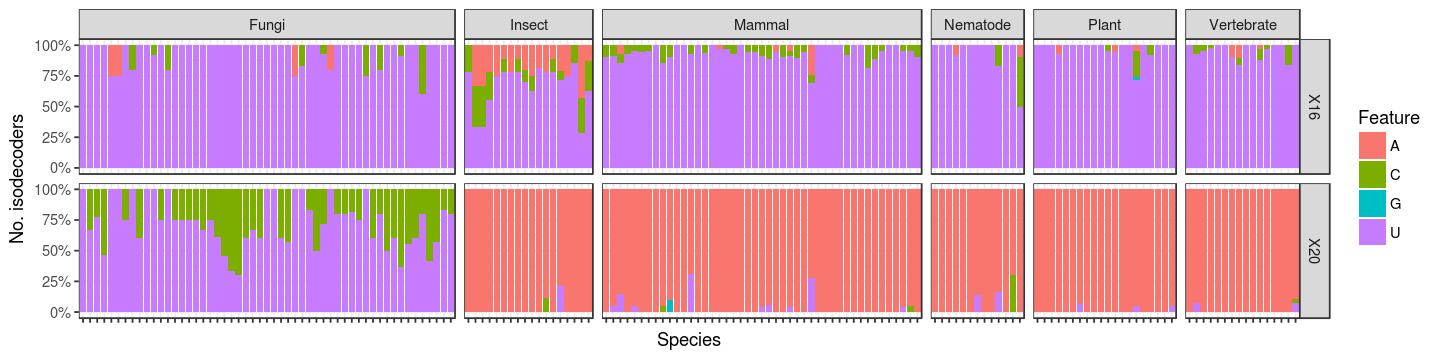

In [51]:
options(repr.plot.width=12, repr.plot.height=3)
identities %>% filter(!restrict, isotype == "Arg") %>%
   mutate(species_long = str_extract(species_long, '^\\w+ \\w+')) %>%
  gather(Position, Feature, X16, X20) %>%
  count(clade, species_long, Position, Feature) %>%
  group_by(clade, species_long, Position) %>% mutate(n = n/sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = Feature), stat = 'identity', position = 'stack') + 
    facet_grid(Position ~ clade, scales = "free", space = "free") +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_blank()) +
    labs(x = "Species", y = "No. isodecoders")

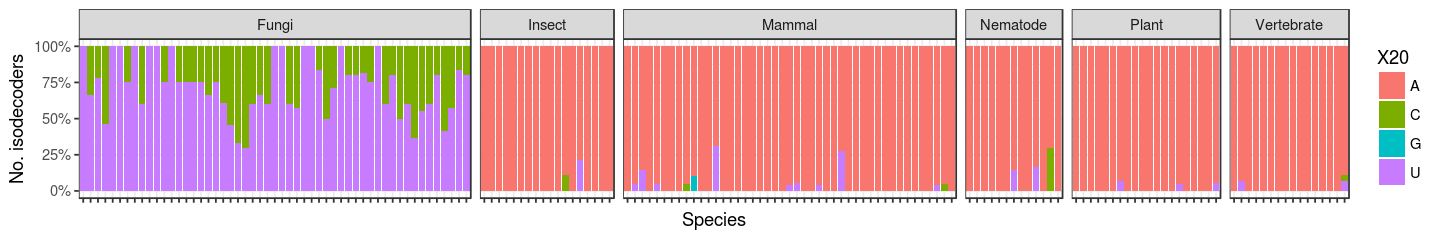

In [52]:
options(repr.plot.width=12, repr.plot.height=2)
identities %>% filter(!restrict, isotype == "Arg") %>%
   mutate(species_long = str_extract(species_long, '^\\w+ \\w+')) %>%
  count(clade, species_long, X20) %>%
  group_by(clade, species_long) %>% mutate(n = n/sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X20), stat = 'identity', position = 'stack') + 
    facet_grid(~ clade, scales = "free", space = "free") +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_blank()) +
    labs(x = "Species", y = "No. isodecoders")

In [53]:
# N73 is clade-specific
identities %>% filter(isotype == "Arg") %>% select(clade, X73) %>% 
  group_by(clade, X73) %>% tally() %>% spread(X73, n, fill='.')

# species-specific?
identities %>% filter(isotype == "Arg") %>% select(clade, species, X73) %>% 
  group_by(clade, species, X73) %>% tally() %>% spread(X73, n, fill='.') %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

,clade,-,A,C,G,N,U
1,Fungi,.,171,2,526,.,264
2,Insect,.,56,.,295,.,8
3,Mammal,1,242,2,997,.,272
4,Nematode,.,59,5,326,.,50
5,Plant,.,45,.,794,.,3
6,Vertebrate,.,85,.,663,1,18


|clade      |species                        |-  |A  |C  |G   |N  |U   |
|:----------|:------------------------------|:--|:--|:--|:---|:--|:---|
|Fungi      |ashbGoss_ATCC10895             |.  |.  |.  |11  |.  |2   |
|Fungi      |aspeFumi_AF293                 |.  |10 |.  |5   |.  |1   |
|Fungi      |aspeNidu_FGSC_A4               |.  |9  |.  |6   |.  |2   |
|Fungi      |aspeOryz_RIB40                 |.  |12 |.  |7   |.  |2   |
|Fungi      |botrCine_B05_10                |.  |9  |.  |9   |.  |.   |
|Fungi      |candAlbi_WO_1                  |.  |.  |.  |2   |.  |7   |
|Fungi      |candDubl_CD36                  |.  |.  |.  |2   |.  |7   |
|Fungi      |candGlab_CBS_138               |.  |.  |.  |12  |.  |1   |
|Fungi      |candOrth_CO_90_125             |.  |.  |.  |2   |.  |4   |
|Fungi      |chaeTher_VAR_THERMOPHILUM_DSM1 |.  |.  |.  |17  |.  |.   |
|Fungi      |crypGatt_WM276                 |.  |.  |.  |.   |.  |13  |
|Fungi      |crypNeof_VAR_GRUBII_H99        |.  |.  |.  |.   |.  |13  |
|Fungi      |crypNeof_VAR_NEOFORMANS_B_3501 |.  |.  |.  |.   |.  |13  |
|Fungi      |crypNeof_VAR_NEOFORMANS_JEC21  |.  |.  |.  |.   |.  |13  |
|Fungi      |cybeJadi_NBRC_0988_NBRC0988    |.  |.  |.  |12  |.  |1   |
|Fungi      |debaHans_CBS767                |.  |.  |.  |4   |.  |11  |
|Fungi      |enceCuni_GB_M1                 |.  |.  |.  |4   |.  |.   |
|Fungi      |enceHell_ATCC50504             |.  |.  |.  |4   |.  |.   |
|Fungi      |enceInte_ATCC50506             |.  |.  |.  |4   |.  |.   |
|Fungi      |enceRoma_SJ_2008               |.  |.  |.  |4   |.  |.   |
|Fungi      |eremCymb_DBVPG#7215            |.  |.  |.  |9   |.  |1   |
|Fungi      |flamVelu_KACC42780             |.  |23 |.  |2   |.  |6   |
|Fungi      |fusaGram_CS3005                |.  |11 |.  |11  |.  |3   |
|Fungi      |fusaGram_PH_1_NRRL_31084       |.  |11 |.  |11  |.  |3   |
|Fungi      |fusaPseu_CS3096                |.  |12 |.  |10  |.  |2   |
|Fungi      |fusaPseu_CS3270                |.  |12 |.  |11  |.  |2   |
|Fungi      |fusaVert_7600                  |.  |10 |.  |11  |.  |2   |
|Fungi      |kazaAfri_CBS_2517              |.  |.  |.  |16  |.  |1   |
|Fungi      |kazaNaga_CBS_8797              |.  |.  |.  |10  |.  |1   |
|Fungi      |kluyLact_NRRL_Y_1140           |.  |.  |.  |11  |.  |1   |
|Fungi      |komaPast_CBS_7435              |.  |1  |.  |6   |.  |2   |
|Fungi      |komaPast_GS115                 |.  |1  |.  |6   |.  |2   |
|Fungi      |lachKluy_NRRL_Y_12651          |.  |.  |.  |18  |.  |1   |
|Fungi      |lachTher_CBS_6340              |.  |.  |.  |14  |.  |1   |
|Fungi      |magnOryz_70_15                 |.  |.  |.  |13  |.  |1   |
|Fungi      |millFari_CBS_7064              |.  |.  |.  |4   |.  |14  |
|Fungi      |myceTher_ATCC42464             |.  |.  |.  |13  |.  |.   |
|Fungi      |naumCast_CBS_4309              |.  |.  |.  |16  |.  |2   |
|Fungi      |naumDair_CBS_421               |.  |.  |1  |17  |.  |1   |
|Fungi      |neurCras_OR74A                 |.  |3  |.  |29  |.  |5   |
|Fungi      |ogatPara_DL_1                  |.  |.  |.  |6   |.  |1   |
|Fungi      |peniChry_P2NIAD18              |.  |12 |.  |4   |.  |.   |
|Fungi      |sacCer3                        |.  |.  |.  |18  |.  |1   |
|Fungi      |saccSp_ASHBYA_ACERI            |.  |.  |.  |11  |.  |2   |
|Fungi      |saccSp_BOULARDII_17            |.  |.  |.  |21  |.  |1   |
|Fungi      |saccSp_BOULARDII_ATCCMYA_796   |.  |1  |.  |16  |.  |1   |
|Fungi      |scheStip_CBS_6054              |.  |.  |.  |3   |.  |9   |
|Fungi      |schiPomb_972H                  |.  |.  |.  |11  |.  |2   |
|Fungi      |sporReil_SRZ2                  |.  |4  |.  |.   |.  |3   |
|Fungi      |tetrBlat_CBS_6284              |.  |.  |.  |18  |.  |1   |
|Fungi      |tetrPhaf_CBS_4417              |.  |.  |.  |12  |.  |1   |
|Fungi      |thieTerr_NRRL_8126             |.  |.  |.  |13  |.  |.   |
|Fungi      |toruDelb_CBS_1146              |.  |.  |.  |11  |.  |2   |
|Fungi      |ustiMayd_521                   |.  |4  |.  |.   |.  |5   |
|Fungi      |valsMali_03_8                  |.  |6  |1  |6   |.  |1   |
|Fungi      |vertDahl_JR2                   |.  |10 |.  |4   |.  |5   |
|Fungi      |vertDahl_VDLS_17               |.  |10 |.  |4   |.  |5   |
|Fungi      |yarrLipo_CLIB122               |.  |.  |.  |6   |.  |25  |
|Fungi      |yarrLipo_PO1F                  |.  |.  |.  |6   |.  |24  |
|Fungi      |yarrLipo_WSH_Z06               |.  |.  |.  |6   |.  |25  |
|Fungi      |zygoRoux_CBS_732               |.  |.  |.  |7   |.  |9   |
|Insect     |anoGam2                        |.  |3  |.  |20  |.  |.   |
|Insect     |apiMel1                        |.  |4  |.  |11  |.  |.   |
|Insect     |bomTer1                        |.  |3  |.  |10  |.  |.   |
|Insect     |dm6                            |.  |3  |.  |23  |.  |.   |
|Insect     |dp4                            |.  |2  |.  |15  |.  |4   |
|Insect     |droAna3                        |.  |3  |.  |22  |.  |.   |
|Insect     |droEre2                        |.  |3  |.  |19  |.  |1   |
|Insect     |droGri2                        |.  |3  |.  |15  |.  |.   |
|Insect     |droMoj3                        |.  |3  |.  |16  |.  |.   |
|Insect     |droPer1                        |.  |2  |.  |19  |.  |2   |
|Insect     |droSec1                        |.  |5  |.  |18  |.  |.   |
|Insect     |droSim1                        |.  |3  |.  |17  |.  |.   |
|Insect     |droVir3                        |.  |3  |.  |16  |.  |.   |
|Insect     |droWil1                        |.  |5  |.  |19  |.  |.   |
|Insect     |droYak2                        |.  |3  |.  |22  |.  |1   |
|Insect     |mayDes1                        |.  |2  |.  |11  |.  |.   |
|Insect     |nasVit1                        |.  |3  |.  |10  |.  |.   |
|Insect     |triCas1                        |.  |3  |.  |12  |.  |.   |
|Mammal     |ailMel1                        |.  |5  |.  |26  |.  |.   |
|Mammal     |balAcu1                        |.  |5  |.  |24  |.  |.   |
|Mammal     |bosTau8                        |.  |19 |.  |33  |.  |.   |
|Mammal     |calJac3                        |.  |4  |.  |19  |.  |.   |
|Mammal     |canFam3                        |.  |6  |.  |18  |.  |1   |
|Mammal     |cavPor3                        |.  |4  |.  |20  |.  |.   |
|Mammal     |cerSim1                        |.  |6  |.  |25  |.  |.   |
|Mammal     |criGri1                        |.  |4  |.  |21  |.  |.   |
|Mammal     |dasNov3                        |.  |5  |.  |26  |.  |.   |
|Mammal     |dipOrd1                        |.  |2  |.  |10  |.  |.   |
|Mammal     |equCab2                        |.  |6  |.  |24  |.  |.   |
|Mammal     |eriEur2                        |.  |5  |.  |20  |.  |.   |
|Mammal     |felCat5                        |.  |7  |1  |24  |.  |268 |
|Mammal     |gorGor3                        |.  |5  |.  |23  |.  |.   |
|Mammal     |hetGla2                        |.  |4  |.  |17  |.  |.   |
|Mammal     |hg19                           |.  |4  |.  |22  |.  |.   |
|Mammal     |loxAfr3                        |.  |8  |.  |32  |.  |.   |
|Mammal     |macEug2                        |.  |1  |.  |22  |.  |.   |
|Mammal     |micMur1                        |.  |4  |.  |13  |.  |.   |
|Mammal     |mm10                           |.  |3  |.  |21  |.  |.   |
|Mammal     |monDom5                        |.  |1  |.  |22  |.  |1   |
|Mammal     |musFur1                        |.  |6  |.  |23  |.  |1   |
|Mammal     |myoLuc2                        |.  |3  |.  |20  |.  |.   |
|Mammal     |nomLeu3                        |.  |4  |.  |22  |.  |.   |
|Mammal     |ochPri3                        |.  |6  |.  |22  |.  |.   |
|Mammal     |ornAna1                        |.  |4  |.  |32  |.  |.   |
|Mammal     |oryCun2                        |.  |6  |.  |22  |.  |.   |
|Mammal     |otoGar3                        |.  |1  |.  |21  |.  |.   |
|Mammal     |oviAri3                        |.  |13 |1  |29  |.  |.   |
|Mammal     |panTro4                        |.  |5  |.  |23  |.  |.   |
|Mammal     |papAnu2                        |.  |5  |.  |22  |.  |.   |
|Mammal     |ponAbe2                        |.  |7  |.  |27  |.  |.   |
|Mammal     |proCap1                        |.  |5  |.  |20  |.  |.   |
|Mammal     |pteVam1                        |.  |1  |.  |14  |.  |.   |
|Mammal     |rheMac8                        |1  |25 |.  |29  |.  |.   |
|Mammal     |rn6                            |.  |5  |.  |22  |.  |.   |
|Mammal     |saiBol1                        |.  |4  |.  |18  |.  |.   |
|Mammal     |sarHar1                        |.  |1  |.  |19  |.  |1   |
|Mammal     |sorAra2                        |.  |5  |.  |19  |.  |.   |
|Mammal     |speTri2                        |.  |5  |.  |19  |.  |.   |
|Mammal     |susScr3                        |.  |5  |.  |21  |.  |.   |
|Mammal     |tarSyr2                        |.  |4  |.  |17  |.  |.   |
|Mammal     |triMan1                        |.  |4  |.  |25  |.  |.   |
|Mammal     |turTru2                        |.  |5  |.  |22  |.  |.   |
|Mammal     |vicPac2                        |.  |5  |.  |27  |.  |.   |
|Nematode   |bruMal1                        |.  |.  |2  |11  |.  |.   |
|Nematode   |caeJap1                        |.  |11 |1  |34  |.  |.   |
|Nematode   |caePb2                         |.  |12 |.  |55  |.  |18  |
|Nematode   |caeRem3                        |.  |12 |.  |37  |.  |.   |
|Nematode   |cb3                            |.  |10 |.  |35  |.  |.   |
|Nematode   |ce11                           |.  |8  |.  |30  |.  |.   |
|Nematode   |hetBac1                        |.  |.  |1  |15  |.  |5   |
|Nematode   |hetGly1                        |.  |3  |.  |3   |.  |2   |
|Nematode   |loaLoa1                        |.  |.  |1  |11  |.  |.   |
|Nematode   |panRed1                        |.  |.  |.  |21  |.  |1   |
|Nematode   |priPac1                        |.  |.  |.  |52  |.  |14  |
|Nematode   |strRat1                        |.  |.  |.  |12  |.  |10  |
|Nematode   |triSpi1                        |.  |3  |.  |10  |.  |.   |
|Plant      |araTha1                        |.  |1  |.  |35  |.  |.   |
|Plant      |braDis3                        |.  |1  |.  |36  |.  |.   |
|Plant      |braOle1                        |.  |2  |.  |60  |.  |.   |
|Plant      |carPap1                        |.  |1  |.  |20  |.  |.   |
|Plant      |cucSat1                        |.  |2  |.  |36  |.  |.   |
|Plant      |fraVes1                        |.  |1  |.  |29  |.  |.   |
|Plant      |glyMax2                        |.  |.  |.  |53  |.  |.   |
|Plant      |gosRai2                        |.  |.  |.  |42  |.  |.   |
|Plant      |malDom1                        |.  |.  |.  |48  |.  |.   |
|Plant      |manEsc6                        |.  |1  |.  |47  |.  |.   |
|Plant      |medTru4                        |.  |1  |.  |41  |.  |.   |
|Plant      |orySat7                        |.  |12 |.  |39  |.  |.   |
|Plant      |phyPat3                        |.  |3  |.  |31  |.  |.   |
|Plant      |popTri3                        |.  |.  |.  |38  |.  |.   |
|Plant      |selMoe1                        |.  |10 |.  |73  |.  |.   |
|Plant      |solPen1                        |.  |8  |.  |49  |.  |.   |
|Plant      |sorBic3                        |.  |.  |.  |38  |.  |.   |
|Plant      |spiPol1                        |.  |1  |.  |15  |.  |.   |
|Plant      |vitVin1                        |.  |.  |.  |25  |.  |.   |
|Plant      |zeaMay6                        |.  |1  |.  |39  |.  |3   |
|Vertebrate |anoCar2                        |.  |1  |.  |13  |.  |.   |
|Vertebrate |calMil1                        |.  |5  |.  |28  |1  |12  |
|Vertebrate |chrPic1                        |.  |7  |.  |19  |.  |.   |
|Vertebrate |fr3                            |.  |5  |.  |39  |.  |2   |
|Vertebrate |gadMor1                        |.  |14 |.  |57  |.  |4   |
|Vertebrate |galGal4                        |.  |.  |.  |19  |.  |.   |
|Vertebrate |gasAcu1                        |.  |.  |.  |131 |.  |.   |
|Vertebrate |geoFor1                        |.  |2  |.  |10  |.  |.   |
|Vertebrate |latCha1                        |.  |5  |.  |19  |.  |.   |
|Vertebrate |melGal1                        |.  |.  |.  |10  |.  |.   |
|Vertebrate |melUnd1                        |.  |1  |.  |10  |.  |.   |
|Vertebrate |oreNil2                        |.  |12 |.  |59  |.  |.   |
|Vertebrate |oryLat2                        |.  |6  |.  |62  |.  |.   |
|Vertebrate |taeGut2                        |.  |2  |.  |11  |.  |.   |
|Vertebrate |tetNig2                        |.  |2  |.  |36  |.  |.   |
|Vertebrate |xenTro3                        |.  |23 |.  |140 |.  |.   |

# Asn

In [54]:
# G1:C72
identities %>% filter(!restrict, isotype == 'Asn') %>%
  count(clade, X1.72) %>% spread(X1.72, n, fill='.')

,clade,A:C,C:C,C:G,G:A,G:C,G:G,G:U,U:A,U:C
1,Fungi,.,.,.,.,87,.,2,60,.
2,Insect,.,.,.,.,30,.,1,2,.
3,Mammal,2,1,.,1,272,1,16,.,.
4,Nematode,1,.,.,.,36,1,1,.,.
5,Plant,.,.,.,1,153,.,.,58,.
6,Vertebrate,3,.,1,.,128,.,3,1,2


In [55]:
# Y60 transition to C60
identities %>% filter(!restrict, isotype == "Asn") %>% count(clade, isotype, X60) %>%
  spread(X60, n, fill='.')

identities %>% filter(!restrict, isotype == "Asn", clade == "Nematode") %>%
  count(clade, species_long, isotype, X60) %>% spread(X60, n, fill='.') %>% 
    kable %>% paste(collapse = '\n') %>% display_markdown

,clade,isotype,-,A,C,U
1,Fungi,Asn,.,.,129,20
2,Insect,Asn,.,1,12,20
3,Mammal,Asn,.,5,277,11
4,Nematode,Asn,.,.,38,1
5,Plant,Asn,1,2,140,69
6,Vertebrate,Asn,.,2,135,1


|clade    |species_long                                                  |isotype |C  |U  |
|:--------|:-------------------------------------------------------------|:-------|:--|:--|
|Nematode |Brugia malayi                                                 |Asn     |1  |.  |
|Nematode |Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008)                |Asn     |4  |.  |
|Nematode |Caenorhabditis briggsae (C. briggsae Jan. 2007 WUGSC 1.0/cb3) |Asn     |2  |.  |
|Nematode |Caenorhabditis elegans (C. elegans Feb 2013 WBcel235/ce11)    |Asn     |3  |.  |
|Nematode |Caenorhabditis japonica (WUGSC 3.0.2 Mar 2008)                |Asn     |3  |.  |
|Nematode |Caenorhabditis remanei (WUGSC 15.0.1 May 2007)                |Asn     |3  |.  |
|Nematode |Heterodera glycines (soybean cyst nematode) (OP25)            |Asn     |.  |1  |
|Nematode |Heterorhabditis bacteriophora M31e                            |Asn     |6  |.  |
|Nematode |Loa loa (V3.1)                                                |Asn     |2  |.  |
|Nematode |Panagrellus redivivus MT8872                                  |Asn     |2  |.  |
|Nematode |Pristionchus pacificus (WUGSC 5.0 Feb 2007)                   |Asn     |7  |.  |
|Nematode |Strongyloides ratti                                           |Asn     |3  |.  |
|Nematode |Trichinella spiralis (ISS 195)                                |Asn     |2  |.  |

# Asp

In [56]:
# 1:72
identities %>% filter(!restrict) %>% select(clade, isotype, X1.72) %>% filter(isotype == "Asp") %>%
  group_by(clade, X1.72) %>% tally %>% spread(X1.72, n, fill='.')

,clade,A:C,A:G,G:C,G:G,G:U,U:A,U:G
1,Fungi,.,.,.,.,.,107,1
2,Insect,.,.,.,.,.,37,.
3,Mammal,.,.,.,.,.,166,.
4,Nematode,.,.,.,.,.,30,.
5,Plant,2,.,121,1,2,1,.
6,Vertebrate,.,1,.,.,.,61,1


In [57]:
# G10:U25
identities %>% filter(!restrict, isotype == "Asp") %>%
  count(clade, X10.25) %>% spread(X10.25, n, fill='.')

identities %>% filter(isotype == "Asp") %>%
  count(clade, species_long, X10.25) %>% spread(X10.25, n, fill='.') %>%
  filter(!(`G:C` == '.' & `A:U` == "." & `G:A` == ".")) 

,clade,A:U,G:A,G:C,G:U
1,Fungi,.,.,8,100
2,Insect,.,.,.,37
3,Mammal,.,1,24,141
4,Nematode,.,1,.,29
5,Plant,1,.,9,117
6,Vertebrate,1,.,3,59


,clade,species_long,A:G,A:U,G:A,G:C,G:U
1,Fungi,Flammulina velutipes KACC42780,.,.,.,11,.
2,Fungi,Komagataella pastoris CBS 7435,.,.,.,6,.
3,Fungi,Komagataella phaffii GS115,.,.,.,6,.
4,Fungi,Schizosaccharomyces pombe 972h-,.,.,.,8,.
5,Fungi,Sporisorium reilianum SRZ2,.,.,.,3,.
6,Fungi,Ustilago maydis 521,.,.,.,5,.
7,Mammal,Balaenoptera acutorostrata scammoni (Minke whale Oct. 2013 BalAcu1.0/balAcu1),.,.,.,13,10
8,Mammal,Bos taurus (Cow Jun. 2014 Bos_taurus_UMD_3.1.1/bosTau8),.,.,1,6,12
9,Mammal,Ovis aries (sheep) (Feb 2010),.,.,.,1,10
10,Mammal,Tarsius syrichta (Tarsier Sep. 2013 Tarsius_syrichta-2.0.1/tarSyr2),.,.,.,1,8


In [58]:
# 49:65
identities %>% filter(!restrict) %>% count(isotype, X49.65) %>% 
  filter(!str_detect(X49.65, '-')) %>%
  spread(X49.65, n, 0)

,isotype,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:N,C:U,G:A,G:C,G:G,G:N,G:U,U:A,U:C,U:G,U:U
1,Ala,0,1,2,82,4,3,1425,0,7,0,276,1,0,8,136,0,26,1
2,Arg,0,3,0,36,0,2,536,0,0,2,1112,0,0,631,3,2,0,1
3,Asn,0,12,0,20,0,0,18,0,0,1,798,1,0,14,0,0,0,0
4,Asp,0,0,1,1,0,0,512,0,1,0,1,0,0,8,1,0,6,0
5,Cys,0,1,3,129,7,3,896,0,4,0,41,0,0,4,40,0,18,0
6,Gln,0,0,1,12,2,0,1022,0,1,0,32,0,0,1,13,0,4,0
7,Glu,0,0,3,3,6,2,1201,1,4,0,13,0,0,1,1,0,25,0
8,Gly,0,7,4,76,5,2,1268,0,2,1,60,2,0,3,5,0,13,0
9,His,0,0,0,7,1,0,302,0,0,0,65,0,0,1,0,0,2,0
10,Ile,0,4,0,171,0,1,8,0,4,0,679,1,0,256,0,1,15,1


In [59]:
# C38 in plants
identities %>% select(clade, species, isotype, X38) %>% filter(isotype == "Asp", clade == "Plant") %>%
  group_by(clade, species, X38) %>% tally %>% spread(X38, n, fill = '.')

,clade,species,A,C,U
1,Plant,araTha1,.,24,1
2,Plant,braDis3,.,19,.
3,Plant,braOle1,2,43,.
4,Plant,carPap1,1,15,.
5,Plant,cucSat1,.,27,.
6,Plant,fraVes1,.,20,.
7,Plant,glyMax2,1,31,.
8,Plant,gosRai2,.,34,.
9,Plant,malDom1,.,31,1
10,Plant,manEsc6,.,36,.


In [60]:
# G73 in mammals
identities %>% filter(!restrict, clade == "Mammal", isotype == "Asp") %>%
  count(species, X73) %>% spread(X73, n, fill = '.') %>% filter(A != '.')
identities %>% filter(!restrict, species %in% c("oviAri3", "rheMac8", "turTru2"), isotype == "Asp", X73 == "A")

,species,A,G,U
1,balAcu1,11,4,.
2,bosTau8,3,5,.
3,oviAri3,1,2,.
4,rheMac8,2,4,.
5,susScr3,1,4,1
6,turTru2,7,5,.


,clade,domain,isotype,seqname,species,species_long,taxid,isotype_best,anticodon,score,⋯,X70i7,X70i8,X71,X71i1,X71i2,X72,X73,X74,X75,X76
1,Mammal,eukaryota,Asp,oviAri3_chrX.trna6049-AspGTC,oviAri3,Ovis aries (sheep) (Feb 2010),9940,Asp,GTC,59.1,,.,.,G,.,.,A,A,-,-,-
2,Mammal,eukaryota,Asp,rheMac8_chrUn_NW_014821718v1.trna1-AspGTC,rheMac8,Macaca mulatta (Rhesus Nov. 2015 BCM Mmul8.0.1/rheMac8),9544,Asp,GTC,64.5,,.,.,G,.,.,A,A,-,-,-
3,Mammal,eukaryota,Asp,rheMac8_chrUn_NW_014925230v1.trna1-AspGTC,rheMac8,Macaca mulatta (Rhesus Nov. 2015 BCM Mmul8.0.1/rheMac8),9544,Asp,GTC,75.6,,.,.,G,.,.,A,A,-,-,-
4,Mammal,eukaryota,Asp,turTru2_JH472463.trna26-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,62,,.,.,G,.,.,A,A,-,-,-
5,Mammal,eukaryota,Asp,turTru2_JH472543.trna14-AspATC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,ATC,63.5,,.,.,G,.,.,A,A,-,-,-
6,Mammal,eukaryota,Asp,turTru2_JH472988.trna10-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,64.2,,.,.,G,.,.,A,A,-,-,-
7,Mammal,eukaryota,Asp,turTru2_JH473141.trna54-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,55.4,,.,.,G,.,.,A,A,-,-,-
8,Mammal,eukaryota,Asp,turTru2_JH473182.trna10-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,58.8,,.,.,G,.,.,A,A,-,-,-
9,Mammal,eukaryota,Asp,turTru2_JH475975.trna4-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,63.6,,.,.,G,.,.,A,A,-,-,-
10,Mammal,eukaryota,Asp,turTru2_JH480090.trna8-AspGTC,turTru2,Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2),9739,Asp,GTC,57.1,,.,.,G,.,.,A,A,-,-,-


# Cys

In [61]:
# U73
identities %>% filter(!restrict, isotype == "Cys") %>% count(clade, X73) %>% spread(X73, n, 0)

,clade,-,A,C,G,N,U
1,Fungi,0,0,2,0,0,115
2,Insect,0,0,0,0,0,53
3,Mammal,1,6,5,18,0,598
4,Nematode,0,2,0,0,0,24
5,Plant,0,1,2,2,0,135
6,Vertebrate,0,0,4,1,1,177


# Gln

In [62]:
# N73
identities %>% filter(!restrict, isotype == "Gln") %>%
  count(clade, species_long, X73) %>% spread(X73, n, 0) %>% filter(U == 0)

,clade,species_long,A,C,G,U
1,Fungi,Encephalitozoon cuniculi GB-M1,2,0,0,0
2,Fungi,Encephalitozoon hellem ATCC 50504,2,0,0,0
3,Fungi,Encephalitozoon intestinalis ATCC 50506,2,0,0,0
4,Fungi,Encephalitozoon romaleae SJ-2008,2,0,0,0


In [63]:
# Covariation at 32:38 and 33:37
identities %>% filter(!restrict, isotype == "Gln") %>%
  mutate(X32.38 = paste0(X32, ':', X38), X33.37 = paste0(X33, ':', X37)) %>%
  count(clade, X32.38) %>% spread(X32.38, n, 0)

identities %>% filter(!restrict, isotype == "Gln") %>%
  mutate(X32.38 = paste0(X32, ':', X38), X33.37 = paste0(X33, ':', X37)) %>%
  count(clade, X33.37) %>% spread(X33.37, n, 0)

,clade,A:A,C:A,C:C,C:G,C:U,G:A,U:A,U:C,U:G,U:U
1,Fungi,0,10,1,0,3,0,0,0,0,223
2,Insect,0,89,0,0,0,0,0,0,0,0
3,Mammal,1,345,1,1,0,1,1,0,0,0
4,Nematode,0,62,1,0,0,0,0,0,0,3
5,Plant,0,177,1,0,0,0,0,1,0,1
6,Vertebrate,0,158,3,0,1,0,3,0,1,0


,clade,A:A,A:G,C:A,G:A,U:A,U:G,U:U
1,Fungi,0,2,0,0,232,2,1
2,Insect,0,0,0,0,89,0,0
3,Mammal,0,0,0,0,350,0,0
4,Nematode,0,0,0,0,66,0,0
5,Plant,0,0,1,0,179,0,0
6,Vertebrate,1,0,0,3,161,1,0


In [64]:
# Which fungi have C32:A38?
identities %>% filter(!restrict, isotype == "Gln", clade == 'Fungi') %>%
  mutate(X32.38 = paste0(X32, ':', X38)) %>% count(species_long, X32.38) %>%
  spread(X32.38, n, 0) %>% filter(`U:U` == 0)

,species_long,C:A,C:C,C:U,U:U
1,Encephalitozoon cuniculi GB-M1,2,0,0,0
2,Encephalitozoon hellem ATCC 50504,2,0,0,0
3,Encephalitozoon intestinalis ATCC 50506,2,0,0,0
4,Encephalitozoon romaleae SJ-2008,2,0,0,0


# Glu

In [65]:
# U9
identities %>% filter(!restrict, clade == "Insect", isotype == "Glu") %>%
  count(species_long, X9) %>% spread(X9, n, 0)

identities %>% filter(!restrict, clade == "Plant", isotype == "Glu") %>%
  count(species_long, X9) %>% spread(X9, n, 0)

,species_long,C,G,U
1,Anopheles gambiae (AgamP4),0,3,2
2,Apis mellifera (DH4) (honey bee),0,2,0
3,Bombus terrestris (buff-tailed bumblebee),0,3,0
4,Drosophila ananassae (D. ananassae Feb. 2006 Agencourt CAF1),0,1,3
5,Drosophila erecta (D. erecta Feb. 2006 Agencourt CAF1),0,2,3
6,Drosophila grimshawi (D. grimshawi Feb. 2006 Agencourt CAF1),1,1,3
7,Drosophila melanogaster (D. melanogaster Aug. 2014 BDGP Release 6 + ISO1 MT/dm6),0,1,3
8,Drosophila mojavensis (D. mojavensis Feb. 2006 Agencourt CAF1),0,1,3
9,Drosophila persimilis (D. persimilis Oct. 2005 Broad),0,2,2
10,Drosophila pseudoobscura (D. pseudoobscura Feb. 2006),0,1,3


,species_long,A,C,G,U
1,Arabidopsis thaliana (TAIR10 Feb 2011),3,4,0,0
2,Brachypodium distachyon Bd21 (JGI v3.0),3,4,0,0
3,Brassica oleracea var. oleracea TO1000,13,8,0,0
4,Carica papaya (papaya),3,3,0,0
5,Cucumis sativus (cucumber),4,4,0,0
6,Fragaria vesca (strawberry) (v2.0.a1),4,2,0,0
7,Glycine max (soybean) (Wm82.a2),6,4,0,0
8,Gossypium raimondii (Cotton v2),3,3,0,0
9,Malus x domestica (apple v3.0.a1),5,4,0,1
10,Manihot esculenta (Cassava v6),7,2,0,0


In [66]:
# R73
identities %>% filter(!restrict, clade == "Fungi", isotype == "Glu") %>%
  count(species_long, X73) %>% spread(X73, n, 0)

identities %>% filter(!restrict, clade == "Plant", isotype == "Glu") %>%
  count(species_long, X73) %>% spread(X73, n, 0)

,species_long,A,G,N
1,Aspergillus fumigatus Af293,2,3,0
2,Aspergillus nidulans FGSC A4,3,1,0
3,Aspergillus oryzae RIB40,5,1,0
4,Botrytis cinerea B05.10,5,0,0
5,Candida albicans WO-1,0,3,0
6,Candida dubliniensis CD36,0,6,0
7,Candida glabrata CBS 138,0,2,0
8,Candida orthopsilosis Co 90-125,0,3,0
9,Chaetomium thermophilum var. thermophilum DSM 1495,0,10,0
10,Cryptococcus gattii WM276,6,0,0


,species_long,A,G,N,U
1,Arabidopsis thaliana (TAIR10 Feb 2011),0,7,0,0
2,Brachypodium distachyon Bd21 (JGI v3.0),4,3,0,0
3,Brassica oleracea var. oleracea TO1000,0,20,0,1
4,Carica papaya (papaya),5,0,1,0
5,Cucumis sativus (cucumber),8,0,0,0
6,Fragaria vesca (strawberry) (v2.0.a1),6,0,0,0
7,Glycine max (soybean) (Wm82.a2),10,0,0,0
8,Gossypium raimondii (Cotton v2),6,0,0,0
9,Malus x domestica (apple v3.0.a1),10,0,0,0
10,Manihot esculenta (Cassava v6),9,0,0,0


# Gly

In [67]:
# C2:G71 is present alongisde G:U in fungi
identities %>% filter(!restrict, clade == "Fungi", isotype == "Gly") %>%
  count(species_long, X2.71) %>% spread(X2.71, n, '.') %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

# what about in nematodes?
identities %>% filter(!restrict, clade == "Nematode", isotype == "Gly") %>%
  count(species_long, X2.71) %>% spread(X2.71, n, '.')

|species_long                                       |A:U |C:G |G:C |G:U |
|:--------------------------------------------------|:---|:---|:---|:---|
|Aspergillus fumigatus Af293                        |.   |3   |.   |1   |
|Aspergillus nidulans FGSC A4                       |.   |4   |.   |.   |
|Aspergillus oryzae RIB40                           |.   |4   |.   |.   |
|Botrytis cinerea B05.10                            |.   |8   |.   |.   |
|Candida albicans WO-1                              |.   |2   |.   |1   |
|Candida dubliniensis CD36                          |.   |3   |.   |1   |
|Candida glabrata CBS 138                           |.   |1   |.   |1   |
|Candida orthopsilosis Co 90-125                    |.   |1   |.   |1   |
|Chaetomium thermophilum var. thermophilum DSM 1495 |.   |11  |.   |.   |
|Cryptococcus gattii WM276                          |.   |3   |.   |.   |
|Cryptococcus neoformans var. grubii H99            |.   |3   |.   |.   |
|Cryptococcus neoformans var. neoformans B-3501A    |.   |3   |.   |.   |
|Cryptococcus neoformans var. neoformans JEC21      |.   |3   |.   |.   |
|Cyberlindnera jadinii NBRC 0988 NBRC0988           |.   |2   |.   |1   |
|Debaryomyces hansenii CBS767                       |.   |2   |.   |2   |
|Encephalitozoon cuniculi GB-M1                     |.   |3   |.   |.   |
|Encephalitozoon hellem ATCC 50504                  |.   |3   |.   |.   |
|Encephalitozoon intestinalis ATCC 50506            |.   |3   |.   |.   |
|Encephalitozoon romaleae SJ-2008                   |.   |3   |.   |.   |
|Eremothecium cymbalariae DBVPG#7215                |.   |3   |.   |1   |
|Eremothecium gossypii ATCC 10895                   |.   |3   |.   |1   |
|Flammulina velutipes KACC42780                     |.   |6   |.   |.   |
|Fusarium graminearum CS3005                        |.   |8   |.   |.   |
|Fusarium graminearum PH-1 NRRL 31084               |.   |9   |.   |.   |
|Fusarium pseudograminearum CS3096                  |.   |7   |.   |.   |
|Fusarium pseudograminearum CS3270                  |.   |7   |.   |.   |
|Fusarium verticillioides 7600                      |.   |4   |.   |.   |
|Kazachstania africana CBS 2517                     |.   |2   |.   |2   |
|Kazachstania naganishii CBS 8797                   |.   |3   |.   |1   |
|Kluyveromyces lactis NRRL Y-1140                   |2   |2   |.   |.   |
|Komagataella pastoris CBS 7435                     |.   |3   |.   |3   |
|Komagataella phaffii GS115                         |.   |3   |.   |3   |
|Lachancea kluyveri NRRL Y-12651                    |.   |2   |.   |1   |
|Lachancea thermotolerans CBS 6340                  |.   |4   |.   |1   |
|Magnaporthe oryzae 70-15                           |.   |5   |.   |2   |
|Millerozyma farinosa CBS 7064                      |.   |2   |.   |2   |
|Naumovozyma castellii CBS 4309                     |.   |2   |.   |1   |
|Naumovozyma dairenensis CBS 421                    |.   |3   |.   |1   |
|Neurospora crassa OR74A                            |.   |7   |.   |.   |
|Ogataea parapolymorpha DL-1                        |.   |1   |.   |1   |
|Penicillium chrysogenum P2niaD18                   |.   |5   |.   |.   |
|Saccharomyces cerevisiae (S288c Apr 2011)          |.   |3   |.   |1   |
|Saccharomyces sp. boulardii 17                     |.   |3   |1   |1   |
|Saccharomyces sp. boulardii ATCC MYA-796           |.   |3   |.   |1   |
|Saccharomycetaceae sp. Ashbya aceri                |.   |3   |.   |1   |
|Scheffersomyces stipitis CBS 6054                  |.   |2   |.   |2   |
|Schizosaccharomyces pombe 972h-                    |.   |5   |.   |.   |
|Sporisorium reilianum SRZ2                         |.   |5   |.   |.   |
|Tetrapisispora blattae CBS 6284                    |.   |2   |.   |2   |
|Tetrapisispora phaffii CBS 4417                    |.   |2   |.   |2   |
|Thermothelomyces thermophila ATCC 42464            |.   |7   |.   |.   |
|Thielavia terrestris NRRL 8126                     |.   |6   |.   |.   |
|Torulaspora delbrueckii CBS 1146                   |.   |2   |.   |1   |
|Ustilago maydis 521                                |.   |6   |.   |.   |
|Valsa mali 03-8                                    |.   |7   |.   |.   |
|Verticillium dahliae JR2                           |.   |5   |.   |.   |
|Verticillium dahliae VdLs.17                       |.   |5   |.   |.   |
|Yarrowia lipolytica CLIB122                        |.   |1   |.   |3   |
|Yarrowia lipolytica PO1f                           |.   |1   |.   |4   |
|Yarrowia lipolytica WSH-Z06                        |.   |1   |.   |3   |
|Zygosaccharomyces rouxii CBS 732                   |.   |4   |.   |1   |

,species_long,-:G,A:G,C:A,C:G,G:C,G:G,G:U,U:A,U:G
1,Brugia malayi,.,.,.,4,.,.,.,.,.
2,Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008),1,1,.,8,.,.,.,1,2
3,Caenorhabditis briggsae (C. briggsae Jan. 2007 WUGSC 1.0/cb3),.,.,1,8,1,.,.,.,.
4,Caenorhabditis elegans (C. elegans Feb 2013 WBcel235/ce11),.,1,1,8,.,.,.,.,.
5,Caenorhabditis japonica (WUGSC 3.0.2 Mar 2008),.,.,.,17,.,.,.,.,.
6,Caenorhabditis remanei (WUGSC 15.0.1 May 2007),.,.,.,11,.,1,.,.,.
7,Heterodera glycines (soybean cyst nematode) (OP25),.,.,.,4,.,.,.,.,.
8,Heterorhabditis bacteriophora M31e,.,.,.,5,.,.,.,.,.
9,Loa loa (V3.1),.,.,.,3,.,.,.,.,.
10,Panagrellus redivivus MT8872,.,.,.,4,.,.,.,.,.


In [68]:
# A73 is not conserved in insects
identities %>% select(restrict, clade, species_long, isotype, X73) %>% 
  filter(!restrict, clade == "Insect", isotype == "Gly") %>%
  group_by(species_long, X73) %>% tally %>% spread(X73, n, '.')

,species_long,A,N,U
1,Anopheles gambiae (AgamP4),2,.,.
2,Apis mellifera (DH4) (honey bee),6,.,2
3,Bombus terrestris (buff-tailed bumblebee),7,.,.
4,Drosophila ananassae (D. ananassae Feb. 2006 Agencourt CAF1),6,.,.
5,Drosophila erecta (D. erecta Feb. 2006 Agencourt CAF1),4,1,.
6,Drosophila grimshawi (D. grimshawi Feb. 2006 Agencourt CAF1),3,.,.
7,Drosophila melanogaster (D. melanogaster Aug. 2014 BDGP Release 6 + ISO1 MT/dm6),4,.,.
8,Drosophila mojavensis (D. mojavensis Feb. 2006 Agencourt CAF1),6,.,.
9,Drosophila persimilis (D. persimilis Oct. 2005 Broad),5,.,.
10,Drosophila pseudoobscura (D. pseudoobscura Feb. 2006),5,.,.


# His

In [69]:
# A73 and U73
identities %>% filter(!restrict, isotype == "His") %>%
  group_by(species_long, X73) %>% tally %>% spread(X73, n, '.') %>% filter(C != '.' | U != '.')

,species_long,A,C,G,U
1,Aspergillus oryzae RIB40,4,2,.,.
2,Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008),3,1,.,.
3,Cyberlindnera jadinii NBRC 0988 NBRC0988,1,1,.,.
4,Fusarium pseudograminearum CS3096,4,.,.,1
5,Fusarium pseudograminearum CS3270,4,.,.,1
6,Macaca mulatta (Rhesus Nov. 2015 BCM Mmul8.0.1/rheMac8),2,.,.,1
7,Saccharomyces sp. boulardii ATCC MYA-796,1,1,.,.


# Ile

In [70]:
# A34, U34
identities %>% select(restrict, clade, species_long, isotype, X34) %>%
  filter(!restrict, isotype == "Ile") %>%
  group_by(species_long, X34) %>% tally %>% spread(X34, n, '.') %>% 
  kable %>% paste(collapse = '\n') %>% display_markdown

identities %>% select(restrict, clade, species_long, isotype, X34) %>%
  filter(isotype == "Ile") %>%
  group_by(species_long, X34) %>% tally %>% spread(X34, n, '.') %>% filter(A == '.' | U == '.')

|species_long                                                                     |A  |G  |U  |
|:--------------------------------------------------------------------------------|:--|:--|:--|
|Ailuropoda melanoleuca (panda) (BGI-Shenzhen AilMel 1.0 Dec 2009)                |4  |.  |4  |
|Anolis carolinensis (lizard) (Broad AnoCar2.0 May 2010)                          |2  |.  |1  |
|Anopheles gambiae (AgamP4)                                                       |2  |.  |2  |
|Apis mellifera (DH4) (honey bee)                                                 |4  |.  |2  |
|Arabidopsis thaliana (TAIR10 Feb 2011)                                           |2  |.  |2  |
|Aspergillus fumigatus Af293                                                      |2  |.  |1  |
|Aspergillus nidulans FGSC A4                                                     |4  |.  |1  |
|Aspergillus oryzae RIB40                                                         |5  |.  |2  |
|Balaenoptera acutorostrata scammoni (Minke whale Oct. 2013 BalAcu1.0/balAcu1)    |6  |.  |4  |
|Bombus terrestris (buff-tailed bumblebee)                                        |6  |.  |2  |
|Bos taurus (Cow Jun. 2014 Bos_taurus_UMD_3.1.1/bosTau8)                          |5  |.  |4  |
|Botrytis cinerea B05.10                                                          |3  |.  |.  |
|Brachypodium distachyon Bd21 (JGI v3.0)                                          |6  |.  |3  |
|Brassica oleracea var. oleracea TO1000                                           |17 |.  |7  |
|Brugia malayi                                                                    |1  |.  |2  |
|Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008)                                   |3  |.  |2  |
|Caenorhabditis briggsae (C. briggsae Jan. 2007 WUGSC 1.0/cb3)                    |4  |.  |2  |
|Caenorhabditis elegans (C. elegans Feb 2013 WBcel235/ce11)                       |2  |.  |1  |
|Caenorhabditis japonica (WUGSC 3.0.2 Mar 2008)                                   |6  |.  |3  |
|Caenorhabditis remanei (WUGSC 15.0.1 May 2007)                                   |1  |.  |2  |
|Callithrix jacchus (marmoset) (WUGSC 3.2 Mar 2009)                               |4  |1  |4  |
|Callorhinchus milii (Elephant shark Dec. 2013 Callorhinchus_milii-6.1.3/calMil1) |16 |.  |8  |
|Candida albicans WO-1                                                            |2  |.  |1  |
|Candida dubliniensis CD36                                                        |1  |.  |1  |
|Candida glabrata CBS 138                                                         |1  |.  |2  |
|Candida orthopsilosis Co 90-125                                                  |1  |.  |1  |
|Canis familiaris (dog) (CanFam3.1 Sept 2011)                                     |3  |.  |4  |
|Carica papaya (papaya)                                                           |2  |.  |4  |
|Cavia porcellus (Guinea pig) (Broad Feb 2008)                                    |3  |.  |3  |
|Ceratotherium simum (White rhinoceros May 2012 CerSimSim1.0/cerSim1)             |6  |.  |5  |
|Chaetomium thermophilum var. thermophilum DSM 1495                               |4  |.  |1  |
|Chrysemys picta bellii (Painted turtle Dec. 2011 v3.0.1/chrPic1)                 |5  |.  |6  |
|Cricetulus griseus cell line CHO-K1 (Chinese hamster ovary CriGri 1.0 Aug 2011)  |3  |.  |4  |
|Cryptococcus gattii WM276                                                        |2  |.  |1  |
|Cryptococcus neoformans var. grubii H99                                          |2  |.  |1  |
|Cryptococcus neoformans var. neoformans B-3501A                                  |2  |.  |1  |
|Cryptococcus neoformans var. neoformans JEC21                                    |2  |.  |1  |
|Cucumis sativus (cucumber)                                                       |8  |.  |2  |
|Cyberlindnera jadinii NBRC 0988 NBRC0988                                         |1  |1  |1  |
|Dasypus novemcinctus (Armadillo Dec. 2011 Baylor/dasNov3)                        |6  |.  |3  |
|Debaryomyces hansenii CBS767                                                     |1  |.  |2  |
|Dipodomys ordii (Kangaroo rat Jul. 2008 Broad/dipOrd1)                           |1  |.  |1  |
|Drosophila ananassae (D. ananassae Feb. 2006 Agencourt CAF1)                     |2  |.  |1  |
|Drosophila erecta (D. erecta Feb. 2006 Agencourt CAF1)                           |2  |.  |2  |
|Drosophila grimshawi (D. grimshawi Feb. 2006 Agencourt CAF1)                     |4  |.  |2  |
|Drosophila melanogaster (D. melanogaster Aug. 2014 BDGP Release 6 + ISO1 MT/dm6) |1  |.  |2  |
|Drosophila mojavensis (D. mojavensis Feb. 2006 Agencourt CAF1)                   |3  |.  |2  |
|Drosophila persimilis (D. persimilis Oct. 2005 Broad)                            |3  |.  |2  |
|Drosophila pseudoobscura (D. pseudoobscura Feb. 2006)                            |4  |.  |2  |
|Drosophila sechellia (D. sechellia Oct. 2005 Broad)                              |2  |.  |2  |
|Drosophila simulans (D. simulans Apr. 2005 WUGSC mosaic 1.0)                     |2  |.  |.  |
|Drosophila virilis (D. virilis Feb. 2006 Agencourt CAF1)                         |3  |.  |2  |
|Drosophila willistoni (D. willistoni Feb. 2006)                                  |1  |.  |1  |
|Drosophila yakuba (D. yakuba Nov. 2005 WUGSC 7.1)                                |2  |.  |2  |
|Encephalitozoon cuniculi GB-M1                                                   |1  |.  |1  |
|Encephalitozoon hellem ATCC 50504                                                |1  |.  |1  |
|Encephalitozoon intestinalis ATCC 50506                                          |1  |.  |1  |
|Encephalitozoon romaleae SJ-2008                                                 |1  |.  |1  |
|Equus caballus (horse) (Sep 2007)                                                |5  |.  |4  |
|Eremothecium cymbalariae DBVPG#7215                                              |1  |.  |1  |
|Eremothecium gossypii ATCC 10895                                                 |1  |.  |1  |
|Erinaceus europaeus (Hedgehog May 2012 EriEur2.0/eriEur2)                        |2  |.  |3  |
|Felis catus (cat) (Felis_catus-6.2 Sept 2011)                                    |2  |.  |3  |
|Flammulina velutipes KACC42780                                                   |3  |.  |2  |
|Fragaria vesca (strawberry) (v2.0.a1)                                            |3  |.  |3  |
|Fusarium graminearum CS3005                                                      |2  |.  |1  |
|Fusarium graminearum PH-1 NRRL 31084                                             |2  |.  |1  |
|Fusarium pseudograminearum CS3096                                                |2  |.  |1  |
|Fusarium pseudograminearum CS3270                                                |2  |.  |1  |
|Fusarium verticillioides 7600                                                    |3  |.  |1  |
|Gadus morhua (Atlantic cod May 2010 Genofisk GadMor_May2010/gadMor1)             |19 |.  |9  |
|Gallus gallus (galGal4 Nov 2011)                                                 |1  |.  |1  |
|Gasterosteus aculeatus (stickleback) (Broad 1.0 Feb 2006)                        |15 |.  |3  |
|Geospiza fortis (Medium ground finch Apr. 2012 GeoFor_1.0/geoFor1)               |1  |.  |2  |
|Glycine max (soybean) (Wm82.a2)                                                  |12 |.  |3  |
|Gorilla gorilla gorilla (gorilla) (gorGor3.1 May 2011)                           |6  |2  |4  |
|Gossypium raimondii (Cotton v2)                                                  |10 |.  |4  |
|Heterocephalus glaber (Naked mole-rat Jan. 2012 Broad HetGla_female_1.0/hetGla2) |2  |.  |3  |
|Heterodera glycines (soybean cyst nematode) (OP25)                               |2  |.  |2  |
|Heterorhabditis bacteriophora M31e                                               |3  |.  |3  |
|Homo sapiens (hg19 - NCBI Build 37.1 Feb 2009)                                   |7  |1  |4  |
|Kazachstania africana CBS 2517                                                   |1  |.  |1  |
|Kazachstania naganishii CBS 8797                                                 |1  |.  |2  |
|Kluyveromyces lactis NRRL Y-1140                                                 |1  |.  |1  |
|Komagataella pastoris CBS 7435                                                   |1  |.  |1  |
|Komagataella phaffii GS115                                                       |1  |.  |1  |
|Lachancea kluyveri NRRL Y-12651                                                  |2  |.  |1  |
|Lachancea thermotolerans CBS 6340                                                |1  |.  |1  |
|Latimeria chalumnae (Coelacanth Aug. 2011 Broad/latCha1)                         |5  |.  |2  |
|Loa loa (V3.1)                                                                   |1  |.  |2  |
|Loxodonta africana (elephant) (Broad/July 2009)                                  |25 |1  |3  |
|Macaca mulatta (Rhesus Nov. 2015 BCM Mmul8.0.1/rheMac8)                          |6  |3  |4  |
|Macropus eugenii (Wallaby Sep. 2009 TWGS Meug_1.1/macEug2)                       |2  |.  |4  |
|Magnaporthe oryzae 70-15                                                         |3  |.  |1  |
|Malus x domestica (apple v3.0.a1)                                                |5  |.  |2  |
|Manihot esculenta (Cassava v6)                                                   |7  |.  |6  |
|Mayetiola destructor (Hessian fly)                                               |2  |2  |1  |
|Medicago truncatula (Mt4.0v1)                                                    |9  |.  |3  |
|Meleagris gallopavo (turkey) (TGC Turkey_2.01 Dec 2009)                          |2  |.  |1  |
|Melopsittacus undulatus (Budgerigar Sep. 2011 WUSTL v6.3/melUnd1)                |2  |.  |1  |
|Microcebus murinus (Mouse lemur) (Jun 2003)                                      |2  |.  |1  |
|Millerozyma farinosa CBS 7064                                                    |2  |.  |2  |
|Monodelphis domestica (opossum) (Broad Oct 2006)                                 |1  |.  |4  |
|Mus musculus (mm10 Dec 2011)                                                     |4  |.  |4  |
|Mustela putorius furo (Ferret  Apr. 2011 MusPutFur1.0/musFur1)                   |4  |.  |3  |
|Myotis lucifugus (Microbat Jul. 2010 Broad Institute Myoluc2.0/myoLuc2)          |2  |4  |2  |
|Nasonia vitripennis AsymCS (jewel wasp)                                          |4  |.  |3  |
|Naumovozyma castellii CBS 4309                                                   |1  |.  |2  |
|Naumovozyma dairenensis CBS 421                                                  |3  |.  |2  |
|Neurospora crassa OR74A                                                          |4  |.  |1  |
|Nomascus leucogenys (Gibbon Oct. 2012 GGSC Nleu3.0/nomLeu3)                      |7  |1  |5  |
|Ochotona princeps (Pika May 2012 OchPri3.0/ochPri3)                              |2  |.  |3  |
|Ogataea parapolymorpha DL-1                                                      |1  |.  |1  |
|Oreochromis niloticus (Nile tilapia Jan. 2011 Broad oreNil1.1/oreNil2)           |9  |.  |11 |
|Ornithorhynchus anatinus (platypus) (WUGSC 5.0.1 Mar 2007)                       |14 |.  |4  |
|Oryctolagus cuniculus (rabbit) (Broad Apr 2009)                                  |5  |.  |7  |
|Oryza sativa                                                                     |4  |.  |3  |
|Oryzias latipes (Medaka) (Oct 2005)                                              |8  |.  |9  |
|Otolemur garnettii (Bushbaby Mar. 2011 Broad/otoGar3)                            |4  |6  |8  |
|Ovis aries (sheep) (Feb 2010)                                                    |5  |.  |2  |
|Pan troglodytes (Chimp Feb. 2011 CSAC 2.1.4/panTro4)                             |7  |1  |4  |
|Panagrellus redivivus MT8872                                                     |3  |.  |6  |
|Papio anubis (Baboon Mar. 2012 Baylor Panu_2.0/papAnu2)                          |5  |2  |5  |
|Penicillium chrysogenum P2niaD18                                                 |1  |.  |1  |
|Physcomitrella patens                                                            |3  |.  |2  |
|Pongo pygmaeus abelii (Orangutan July 2007 WUGSC 2.0.2/ponAbe2)                  |5  |1  |5  |
|Populus trichocarpa (JGI v3.0)                                                   |5  |.  |1  |
|Pristionchus pacificus (WUGSC 5.0 Feb 2007)                                      |3  |.  |2  |
|Procavia capensis (Rock hyrax Jul. 2008 Broad/proCap1)                           |5  |.  |2  |
|Pteropus vampyrus (Megabat Jul. 2008 Broad/pteVam1)                              |1  |.  |3  |
|Rattus norvegicus (Rat Jul. 2014 RGSC 6.0/rn6)                                   |4  |.  |3  |
|Saccharomyces cerevisiae (S288c Apr 2011)                                        |1  |.  |1  |
|Saccharomyces sp. boulardii 17                                                   |1  |.  |1  |
|Saccharomyces sp. boulardii ATCC MYA-796                                         |1  |.  |1  |
|Saccharomycetaceae sp. Ashbya aceri                                              |1  |.  |1  |
|Saimiri boliviensis (Squirrel monkey Oct. 2011 Broad/saiBol1)                    |3  |.  |3  |
|Sarcophilus harrisii (Tasmanian devil Feb. 2011 WTSI Devil_ref v7.0/sarHar1)     |1  |.  |3  |
|Scheffersomyces stipitis CBS 6054                                                |1  |.  |1  |
|Schizosaccharomyces pombe 972h-                                                  |2  |.  |1  |
|Selaginella moellendorffii                                                       |28 |2  |7  |
|Solanum pennellii (tomato)                                                       |5  |.  |7  |
|Sorex araneus (Shrew Aug. 2008 Broad/sorAra2)                                    |5  |.  |3  |
|Sorghum bicolor (Version 3.1)                                                    |3  |.  |3  |
|Spermophilus tridecemlineatus (Squirrel Nov. 2011 Broad/speTri2)                 |4  |4  |3  |
|Spirodela polyrhiza (great duckweed)                                             |1  |.  |1  |
|Sporisorium reilianum SRZ2                                                       |4  |.  |1  |
|Strongyloides ratti                                                              |1  |.  |6  |
|Sus scrofa (Pig Aug. 2011 SGSC Sscrofa10.2/susScr3)                              |1  |.  |3  |
|Taeniopygia guttata (Zebra finch Feb. 2013 WashU taeGut324/taeGut2)              |2  |.  |1  |
|Takifugu rubripes (Fugu Oct. 2011 FUGU5/fr3)                                     |2  |.  |2  |
|Tarsius syrichta (Tarsier Sep. 2013 Tarsius_syrichta-2.0.1/tarSyr2)              |3  |.  |3  |
|Tetraodon nigroviridis (tetraodon) (Genoscope 8.0 Mar 2007)                      |5  |.  |3  |
|Tetrapisispora blattae CBS 6284                                                  |4  |.  |1  |
|Tetrapisispora phaffii CBS 4417                                                  |1  |.  |1  |
|Thermothelomyces thermophila ATCC 42464                                          |4  |.  |1  |
|Thielavia terrestris NRRL 8126                                                   |5  |.  |1  |
|Torulaspora delbrueckii CBS 1146                                                 |1  |.  |1  |
|Tribolium castaneum (Georgia GA2) (red flour beetle)                             |2  |.  |2  |
|Trichechus manatus latirostris (Manatee Oct. 2011 Broad v1.0/triMan1)            |5  |1  |5  |
|Trichinella spiralis (ISS 195)                                                   |4  |.  |2  |
|Tursiops truncatus (Dolphin Oct. 2011 Baylor Ttru_1.4/turTru2)                   |6  |.  |4  |
|Ustilago maydis 521                                                              |2  |.  |1  |
|Valsa mali 03-8                                                                  |2  |.  |1  |
|Verticillium dahliae JR2                                                         |1  |.  |.  |
|Verticillium dahliae VdLs.17                                                     |1  |.  |.  |
|Vicugna pacos (Alpaca Mar. 2013 Vicugna_pacos-2.0.1/vicPac2)                     |3  |.  |4  |
|Vitis vinifera (Grapevine 12X)                                                   |3  |.  |2  |
|Xenopus tropicalis (frog) (JGI 4.2 Nov 2009)                                     |14 |.  |7  |
|Yarrowia lipolytica CLIB122                                                      |3  |.  |1  |
|Yarrowia lipolytica PO1f                                                         |6  |.  |1  |
|Yarrowia lipolytica WSH-Z06                                                      |3  |.  |1  |
|Zea mays B73 (Version AGPv3)                                                     |23 |.  |3  |
|Zygosaccharomyces rouxii CBS 732                                                 |2  |1  |1  |

,species_long,A,G,U
1,Botrytis cinerea B05.10,8,.,.
2,Drosophila simulans (D. simulans Apr. 2005 WUGSC mosaic 1.0),8,.,.
3,Verticillium dahliae JR2,10,.,.
4,Verticillium dahliae VdLs.17,9,.,.


In [71]:
# A73 is muddled in insects
identities %>% select(restrict, clade, species_long, isotype, X73) %>%
  filter(!restrict, isotype == "Ile") %>%
  group_by(species_long, X73) %>% tally %>% spread(X73, n, '.') %>% filter(G != '.')

,species_long,-,A,G,U
1,Gorilla gorilla gorilla (gorilla) (gorGor3.1 May 2011),.,11,1,.
2,Heterodera glycines (soybean cyst nematode) (OP25),.,3,1,.
3,Loxodonta africana (elephant) (Broad/July 2009),.,28,1,.
4,Nasonia vitripennis AsymCS (jewel wasp),.,6,1,.
5,Ornithorhynchus anatinus (platypus) (WUGSC 5.0.1 Mar 2007),.,17,1,.
6,Otolemur garnettii (Bushbaby Mar. 2011 Broad/otoGar3),.,17,1,.
7,Pongo pygmaeus abelii (Orangutan July 2007 WUGSC 2.0.2/ponAbe2),.,10,1,.
8,Selaginella moellendorffii,.,36,1,.
9,Trichinella spiralis (ISS 195),.,5,1,.
10,Xenopus tropicalis (frog) (JGI 4.2 Nov 2009),.,20,1,.


# Leu

In [72]:
# 3:70, 4:69, 5:68
identities %>% filter(!restrict, isotype == "Leu") %>% 
  count(clade, X3.70) %>% filter(n > 1) %>% spread(X3.70, n, '.')
identities %>% filter(!restrict, isotype == "Leu") %>% 
  count(clade, X4.69) %>% filter(n > 1) %>% spread(X4.69, n, '.')
identities %>% filter(!restrict, isotype == "Leu") %>% 
  count(clade, X5.68) %>% filter(n > 1) %>% spread(X5.68, n, '.')


,clade,A:U,C:A,C:C,C:G,G:C,G:U,N:G,U:A,U:G
1,Fungi,75,.,.,173,68,6,.,120,15
2,Insect,.,.,.,131,.,.,.,4,24
3,Mammal,.,2,.,461,3,.,2,4,242
4,Nematode,56,.,.,68,.,.,.,25,.
5,Plant,22,.,.,181,8,.,.,121,9
6,Vertebrate,.,.,2,285,.,.,.,15,104


,clade,A:A,A:C,A:U,C:G,G:C,G:U,N:U,U:A,U:U
1,Fungi,.,.,257,22,111,.,.,66,.
2,Insect,.,.,154,4,.,.,.,.,.
3,Mammal,.,4,636,.,69,2,2,2,.
4,Nematode,.,.,31,32,85,.,.,4,.
5,Plant,.,.,169,4,161,4,.,4,.
6,Vertebrate,3,.,399,.,.,.,.,2,3


,clade,A:C,A:U,C:G,G:A,G:C,G:U,U:A
1,Fungi,.,195,56,.,180,5,21
2,Insect,.,7,.,.,148,3,.
3,Mammal,2,2,.,2,682,29,.
4,Nematode,.,52,26,.,49,.,24
5,Plant,.,102,.,.,230,6,3
6,Vertebrate,.,.,.,.,396,10,.


In [73]:
# C20a
identities %>% filter(!restrict, isotype == "Leu") %>%
  count(clade, X20a) %>% filter(n > 1) %>% spread(X20a, n, '.')

identities %>% filter(!restrict, isotype == "Leu") %>%
  count(clade, species_long, X20a) %>% spread(X20a, n, 0) %>% filter(U == 0)

,clade,-,A,C,G,U
1,Fungi,3,2,318,.,136
2,Insect,.,4,152,.,3
3,Mammal,3,.,555,.,160
4,Nematode,.,.,122,.,30
5,Plant,.,4,272,.,68
6,Vertebrate,.,.,307,8,93


,clade,species_long,-,A,C,G,U
1,Fungi,Encephalitozoon cuniculi GB-M1,0,0,5,0,0
2,Fungi,Encephalitozoon hellem ATCC 50504,0,0,5,0,0
3,Fungi,Encephalitozoon intestinalis ATCC 50506,0,0,5,0,0
4,Fungi,Encephalitozoon romaleae SJ-2008,0,0,5,0,0
5,Fungi,Komagataella pastoris CBS 7435,0,0,7,0,0
6,Fungi,Komagataella phaffii GS115,0,0,7,0,0
7,Fungi,Penicillium chrysogenum P2niaD18,0,0,3,0,0
8,Fungi,Sporisorium reilianum SRZ2,0,0,6,0,0
9,Fungi,Tetrapisispora phaffii CBS 4417,0,0,4,0,0
10,Fungi,Ustilago maydis 521,0,0,3,0,0


# Lys

In [74]:
# position 58
identities %>% filter(!restrict, isotype == "Lys") %>% count(clade, X58) %>% spread(X58, n, 0)
identities %>% filter(!restrict, isotype == "Lys", clade == "Mammal") %>% 
  count(species, X58) %>% spread(X58, n, 0) %>% filter(U != 0)

,clade,A,C,G,U
1,Fungi,231,0,1,0
2,Insect,62,1,6,2
3,Mammal,707,6,12,100
4,Nematode,96,0,0,0
5,Plant,253,1,1,0
6,Vertebrate,258,0,0,6


,species,A,C,G,U
1,bosTau8,24,0,0,3
2,cavPor3,24,0,0,3
3,criGri1,10,0,3,25
4,dasNov3,26,0,2,2
5,eriEur2,19,0,0,31
6,gorGor3,11,1,0,1
7,hg19,17,0,0,1
8,loxAfr3,30,0,1,2
9,macEug2,10,0,0,1
10,mm10,12,0,1,1


In [75]:
identities %>% filter(!restrict, isotype == "Lys", species %in% c("criGri1", "eriEur2")) %>%
  group_by(X58) %>% summarize(score = mean(score))


,X58,score
1,A,81.6862068965517
2,G,66.5
3,U,73.0053571428571


In [76]:
# N73 nonspecificity
identities %>% select(restrict, clade, isotype, X73) %>% filter(!restrict, isotype == "Lys") %>%
  group_by(clade, X73) %>% tally %>% spread(X73, n, '.')

,clade,-,A,C,G,N,U
1,Fungi,.,8,.,85,1,138
2,Insect,.,2,1,68,.,.
3,Mammal,.,214,9,591,.,11
4,Nematode,.,3,1,9,.,83
5,Plant,.,32,1,220,.,2
6,Vertebrate,1,35,1,198,3,26


# Met

# iMet

In [77]:
# 29:41
identities %>% select(restrict, clade, X29.41, isotype) %>% filter(isotype == "iMet") %>%
  group_by(clade, X29.41) %>% tally %>% spread(X29.41, n, '.')

identities %>% select(restrict, clade, species_long, X29.41, isotype) %>% filter(clade %in% c("Fungi", "Nematode"), isotype == "iMet") %>%
  group_by(species_long, X29.41) %>% tally %>% spread(X29.41, n, '.') %>% filter(`A:U` != '.')

,clade,A:U,G:C,G:G,G:U
1,Fungi,18,200,.,3
2,Insect,.,100,.,.
3,Mammal,.,405,.,.
4,Nematode,6,90,.,.
5,Plant,.,239,.,.
6,Vertebrate,.,319,1,.


,species_long,A:U,G:C,G:U
1,Aspergillus nidulans FGSC A4,1,3,.
2,Aspergillus oryzae RIB40,1,1,.
3,Candida albicans WO-1,2,.,.
4,Candida dubliniensis CD36,2,.,.
5,Cryptococcus gattii WM276,3,.,.
6,Cryptococcus neoformans var. grubii H99,3,.,.
7,Cryptococcus neoformans var. neoformans B-3501A,3,.,.
8,Cryptococcus neoformans var. neoformans JEC21,3,.,.
9,Panagrellus redivivus MT8872,6,.,.


In [78]:
# lack of U54
identities %>% select(restrict, clade, species_long, X54, isotype) %>% filter(isotype == "iMet") %>%
  group_by(species_long, X54) %>% tally %>% spread(X54, n, '.') %>% filter(C != '.' | U != '.')

,species_long,A,C,U
1,Encephalitozoon cuniculi GB-M1,.,.,1
2,Encephalitozoon hellem ATCC 50504,.,.,1
3,Encephalitozoon intestinalis ATCC 50506,.,.,1
4,Encephalitozoon romaleae SJ-2008,.,.,1
5,Gadus morhua (Atlantic cod May 2010 Genofisk GadMor_May2010/gadMor1),47,.,1
6,Oryzias latipes (Medaka) (Oct 2005),7,1,.
7,Xenopus tropicalis (frog) (JGI 4.2 Nov 2009),46,.,1


In [79]:
identities %>% filter(str_detect(species_long, "Encephalito")) %>% filter(isotype == 'Met') %>%
kable %>% paste(collapse='\n') %>% display_markdown

|clade |domain    |isotype |seqname                               |species            |species_long                            |taxid  |isotype_best |anticodon | score| isoscore| isoscore_ac| intron|        GC|adjusted | insertions| deletions| D.loop| AC.loop| TPC.loop| V.arm|quality |restrict |duplicate |X1.72 |X1 |X1i1 |X2.71 |X2 |X2i1 |X3.70 |X3 |X3i1 |X3i2 |X3i3 |X3i4 |X3i5 |X3i6 |X4.69 |X4 |X4i1 |X4i2 |X4i3 |X4i4 |X4i5 |X4i6 |X4i7 |X4i8 |X4i9 |X4i10 |X4i11 |X5.68 |X5 |X5i1 |X5i2 |X5i3 |X5i4 |X5i5 |X5i6 |X5i7 |X6.67 |X6 |X6i1 |X7.66 |X7 |X7i1 |X7i2 |X7i3 |X7i4 |X7i5 |X7i6 |X7i7 |X7i8 |X7i9 |X7i10 |X7i11 |X7i12 |X7i13 |X7i14 |X8 |X8.14.21 |X8.14 |X8i1 |X8i2 |X8i3 |X8i4 |X9 |X9.12.23 |X9.23 |X9i1 |X9i2 |X10.25 |X10 |X10.25.45 |X10.45 |X10i1 |X10i2 |X11.24 |X11 |X12.23 |X12 |X12i1 |X13.22 |X13 |X13.22.46 |X14 |X14i1 |X14i2 |X14i3 |X14i4 |X14i5 |X14i6 |X14i7 |X14i8 |X14i9 |X14i10 |X14i11 |X14i12 |X14i13 |X14i14 |X14i15 |X14i16 |X14i17 |X14i18 |X14i19 |X14i20 |X14i21 |X14i22 |X14i23 |X14i24 |X14i25 |X14i26 |X14i27 |X14i28 |X14i29 |X14i30 |X14i31 |X14i32 |X14i33 |X14i34 |X14i35 |X14i36 |X14i37 |X14i38 |X14i39 |X14i40 |X14i41 |X14i42 |X14i43 |X14i44 |X14i45 |X14i46 |X14i47 |X14i48 |X15 |X15.48 |X16 |X16i1 |X16i2 |X16i3 |X16i4 |X16i5 |X16i6 |X16i7 |X16i8 |X16i9 |X16i10 |X16i11 |X16i12 |X16i13 |X16i14 |X16i15 |X16i16 |X17 |X17a |X18 |X18.55 |X19 |X19.56 |X19i1 |X19i2 |X19i3 |X19i4 |X19i5 |X19i6 |X19i7 |X19i8 |X19i9 |X19i10 |X19i11 |X19i12 |X19i13 |X19i14 |X19i15 |X19i16 |X19i17 |X19i18 |X19i19 |X19i20 |X19i21 |X19i22 |X19i23 |X19i24 |X19i25 |X19i26 |X19i27 |X19i28 |X19i29 |X19i30 |X19i31 |X19i32 |X19i33 |X19i34 |X19i35 |X19i36 |X19i37 |X19i38 |X19i39 |X19i40 |X19i41 |X19i42 |X19i43 |X19i44 |X19i45 |X19i46 |X19i47 |X19i48 |X19i49 |X19i50 |X19i51 |X19i52 |X19i53 |X19i54 |X19i55 |X19i56 |X19i57 |X20 |X20i1 |X20i2 |X20i3 |X20i4 |X20a |X20b |X21 |X22 |X22.46 |X22i1 |X23 |X23i1 |X23i2 |X23i3 |X23i4 |X23i5 |X23i6 |X24 |X24i1 |X25 |X25i1 |X25i2 |X25i3 |X25i4 |X25i5 |X25i6 |X25i7 |X25i8 |X25i9 |X25i10 |X25i11 |X25i12 |X25i13 |X25i14 |X25i15 |X25i16 |X25i17 |X25i18 |X25i19 |X25i20 |X25i21 |X25i22 |X25i23 |X25i24 |X25i25 |X25i26 |X25i27 |X25i28 |X25i29 |X25i30 |X25i31 |X25i32 |X25i33 |X25i34 |X25i35 |X25i36 |X25i37 |X25i38 |X25i39 |X25i40 |X25i41 |X25i42 |X25i43 |X25i44 |X25i45 |X25i46 |X25i47 |X25i48 |X25i49 |X25i50 |X25i51 |X25i52 |X25i53 |X25i54 |X25i55 |X25i56 |X25i57 |X26 |X26.44 |X26i1 |X26i2 |X26i3 |X26i4 |X26i5 |X26i6 |X26i7 |X26i8 |X26i9 |X26i10 |X26i11 |X26i12 |X26i13 |X26i14 |X26i15 |X26i16 |X26i17 |X26i18 |X26i19 |X26i20 |X26i21 |X26i22 |X26i23 |X26i24 |X26i25 |X26i26 |X26i27 |X26i28 |X26i29 |X26i30 |X26i31 |X26i32 |X26i33 |X26i34 |X26i35 |X26i36 |X26i37 |X26i38 |X26i39 |X26i40 |X26i41 |X26i42 |X26i43 |X26i44 |X26i45 |X26i46 |X26i47 |X26i48 |X26i49 |X26i50 |X26i51 |X26i52 |X26i53 |X27.43 |X27 |X27i1 |X27i2 |X27i3 |X27i4 |X28.42 |X28 |X28i1 |X29.41 |X29 |X29i1 |X29i2 |X30.40 |X30 |X30i1 |X31.39 |X31 |X32 |X33 |X34 |X35 |X35i1 |X36 |X37 |X37i1 |X37i2 |X37i3 |X37i4 |X37i5 |X37i6 |X37i7 |X37i8 |X37i9 |X37i10 |X37i11 |X37i12 |X37i13 |X37i14 |X37i15 |X37i16 |X37i17 |X37i18 |X37i19 |X37i20 |X37i21 |X37i22 |X38 |X38i1 |X39 |X39i1 |X40 |X40i1 |X40i2 |X40i3 |X40i4 |X41 |X41i1 |X41i2 |X41i3 |X41i4 |X42 |X42i1 |X43 |X44 |X44i1 |X44i2 |X44i3 |X44i4 |X44i5 |X44i6 |X44i7 |X44i8 |X44i9 |X44i10 |X44i11 |X44i12 |X44i13 |X44i14 |X44i15 |X44i16 |X44i17 |X44i18 |X44i19 |X44i20 |X44i21 |X44i22 |X44i23 |X45 |V11.V21 |V12.V22 |V13.V23 |V14.V24 |V15.V25 |V16.V26 |V17.V27 |V1 |V2 |V3 |V4 |V5 |V11 |V12 |V13 |V14 |V15 |V16 |V17 |V21 |V22 |V23 |V24 |V25 |V26 |V27 |X46 |X47 |X47i1 |X47i2 |X47i3 |X48 |X49.65 |X49 |X49i1 |X50.64 |X50 |X50i1 |X50i2 |X50i3 |X50i4 |X50i5 |X50i6 |X50i7 |X50i8 |X51.63 |X51 |X51i1 |X51i2 |X51i3 |X52.62 |X52 |X52i1 |X53.61 |X53 |X53i1 |X53i2 |X54 |X54.58 |X54i1 |X54i2 |X54i3 |X54i4 |X55 |X55i1 |X55i2 |X55i3 |X55i4 |X55i5 |X56 |X56i1 |X56i2 |X56i3 |X56i4 |X57 |X57i1 |X58 |X58i1 |X58i2 |X58i3 |X58i4 |X58i5 |X58i6 |X58i7 |X58i8 |X58i9 |X58i10 |X58i11 |X58i12 |X58i13 |X58i14 |X58i15 |X58i16 |X58i17 |X59 |X59i1 |X60 |X60i1 |X60i2 |X60i3 |X60i4 |X60i5 |X60i6 |X60i7 |X60i8 |X60i9 |X60i10 |X60i11 |X60i12 |X60i13 |X61 |X61i1 |X62 |X63 |X64 |X64i1 |X64i2 |X64i3 |X64i4 |X65 |X65i1 |X65i2 |X65i3 |X65i4 |X65i5 |X65i6 |X65i7 |X65i8 |X65i9 |X65i10 |X65i11 |X65i12 |X66 |X66i1 |X67 |X67i1 |X68 |X68i1 |X68i2 |X69 |X69i1 |X70 |X70i1 |X70i2 |X70i3 |X70i4 |X70i5 |X70i6 |X70i7 |X70i8 |X71 |X71i1 |X71i2 |X72 |X73 |X74 |X75 |X76 |
|:-----|:---------|:-------|:-------------------------------------|:------------------|:---------------------------------------|:------|:------------|:---------|-----:|--------:|-----------:|------:|---------:|:--------|----------:|---------:|------:|-------:|--------:|-----:|:-------|:--------|:---------|:-----|:--|:----|:-----|:--|:----|:-----|:--|:----|:----|:----|:----|:----|:----|:-----|:--|:----|:----|:----|:----|:----|:----|:----|:----|:----|:-----|:-----|:-----|:--|:----|:----|:----|:----|:----|:----|:----|:-----|:--|:----|:-----|:--|:----|:----|:----|:----|:----|:----|:----|:----|:----|:-----|:-----|:-----|:-----|:-----|:--|:--------|:-----|:----|:----|:----|:----|:--|:--------|:-----|:----|:----|:------|:---|:---------|:------|:-----|:-----|:------|:---|:------|:---|:-----|:------|:---|:---------|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:------|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:---|:----|:---|:------|:---|:------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:-----|:-----|:-----|:-----|:----|:----|:---|:---|:------|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:---|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:-----|:-----|:-----|:-----|:------|:---|:-----|:------|:---|:-----|:-----|:------|:---|:-----|:------|:---|:---|:---|:---|:---|:-----|:---|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:-----|:---|:-----|:---|:-----|:-----|:-----|:-----|:---|:-----|:-----|:-----|:-----|:---|:-----|:---|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:---|:-------|:-------|:-------|:-------|:-------|:-------|:-------|:--|:--|:--|:--|:--|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:-----|:-----|:-----|:---|:------|:---|:-----|:------|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:---|:-----|:-----|:-----|:------|:---|:-----|:------|:---|:-----|:-----|:---|:------|:-----|:-----|:-----|:-----|:---|:-----|:-----|:-----|:-----|:-----|:---|:-----|:-----|:-----|:-----|:---|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:------|:------|:------|:------|:---|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:------|:---|:-----|:---|:---|:---|:-----|:-----|:-----|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:------|:------|:------|:---|:-----|:---|:-----|:---|:-----|:-----|:---|:-----|:---|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:---|:-----|:-----|:---|:---|:---|:---|:---|
|Fungi |eukaryota |Met     |enceCuni_GB_M1_chrXI.trna1-MetCAT     |enceCuni_GB_M1     |Encephalitozoon cuniculi GB-M1          |6035   |Met          |CAT       |  67.9|     88.7|        88.7|      0| 0.3902439|FALSE    |          0|         0|      8|       7|        8|     4|TRUE    |FALSE    |FALSE     |G:C   |G  |.    |U:G   |U  |.    |G:C   |G  |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |C:G   |C  |.    |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |U:A   |U  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |.     |.     |.     |U  |U:A:A    |U:A   |.    |.    |.    |.    |G  |G:G:C    |G:C   |.    |.    |G:C    |G   |G:C:G     |G:G    |.     |.     |C:G    |C   |G:C    |G   |.     |C:G    |C   |C:G:G     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |A:U    |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |A   |-    |G   |G:U    |G   |G:C    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |U   |.     |.     |.     |.     |-    |-    |A   |G   |G:G    |.     |C   |.     |.     |.     |.     |.     |.     |G   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |G:A    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |C:G    |C   |.     |.     |.     |.     |U:A    |U   |.     |G:C    |G   |.     |.     |G:C    |G   |.     |U:U    |U   |C   |U   |C   |A   |.     |U   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |.     |U   |.     |C   |.     |.     |.     |.     |C   |.     |.     |.     |.     |A   |.     |G   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-  |-  |-  |-  |-  |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |G   |U   |.     |.     |.     |U   |G:C    |G   |.     |C:G    |C   |.     |.     |.     |.     |.     |.     |.     |.     |G:C    |G   |.     |.     |.     |A:U    |A   |.     |G:C    |G   |.     |.     |U   |U:A    |.     |.     |.     |.     |U   |.     |.     |.     |.     |.     |C   |.     |.     |.     |.     |G   |.     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |G   |.     |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |C   |.     |U   |C   |G   |.     |.     |.     |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |A   |.     |U   |.     |G   |.     |.     |U   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |G   |.     |.     |C   |A   |-   |-   |-   |
|Fungi |eukaryota |Met     |enceHell_ATCC50504_chrXI.trna1-MetCAT |enceHell_ATCC50504 |Encephalitozoon hellem ATCC 50504       |27973  |Met          |CAT       |  67.9|     88.7|        88.7|      0| 0.3902439|FALSE    |          0|         0|      8|       7|        8|     4|TRUE    |FALSE    |FALSE     |G:C   |G  |.    |U:G   |U  |.    |G:C   |G  |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |C:G   |C  |.    |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |U:A   |U  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |.     |.     |.     |U  |U:A:A    |U:A   |.    |.    |.    |.    |G  |G:G:C    |G:C   |.    |.    |G:C    |G   |G:C:G     |G:G    |.     |.     |C:G    |C   |G:C    |G   |.     |C:G    |C   |C:G:G     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |A:U    |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |A   |-    |G   |G:U    |G   |G:C    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |U   |.     |.     |.     |.     |-    |-    |A   |G   |G:G    |.     |C   |.     |.     |.     |.     |.     |.     |G   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |G:A    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |C:G    |C   |.     |.     |.     |.     |U:A    |U   |.     |G:C    |G   |.     |.     |G:C    |G   |.     |U:U    |U   |C   |U   |C   |A   |.     |U   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |.     |U   |.     |C   |.     |.     |.     |.     |C   |.     |.     |.     |.     |A   |.     |G   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-  |-  |-  |-  |-  |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |G   |U   |.     |.     |.     |U   |G:C    |G   |.     |C:G    |C   |.     |.     |.     |.     |.     |.     |.     |.     |G:C    |G   |.     |.     |.     |A:U    |A   |.     |G:C    |G   |.     |.     |U   |U:A    |.     |.     |.     |.     |U   |.     |.     |.     |.     |.     |C   |.     |.     |.     |.     |G   |.     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |G   |.     |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |C   |.     |U   |C   |G   |.     |.     |.     |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |A   |.     |U   |.     |G   |.     |.     |U   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |G   |.     |.     |C   |A   |-   |-   |-   |
|Fungi |eukaryota |Met     |enceInte_ATCC50506_chrXI.trna1-MetCAT |enceInte_ATCC50506 |Encephalitozoon intestinalis ATCC 50506 |571949 |Met          |CAT       |  67.9|     88.7|        88.7|      0| 0.3902439|FALSE    |          0|         0|      8|       7|        8|     4|TRUE    |FALSE    |FALSE     |G:C   |G  |.    |U:G   |U  |.    |G:C   |G  |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |C:G   |C  |.    |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |U:A   |U  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |.     |.     |.     |U  |U:A:A    |U:A   |.    |.    |.    |.    |G  |G:G:C    |G:C   |.    |.    |G:C    |G   |G:C:G     |G:G    |.     |.     |C:G    |C   |G:C    |G   |.     |C:G    |C   |C:G:G     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |A:U    |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |A   |-    |G   |G:U    |G   |G:C    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |U   |.     |.     |.     |.     |-    |-    |A   |G   |G:G    |.     |C   |.     |.     |.     |.     |.     |.     |G   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |G:A    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |C:G    |C   |.     |.     |.     |.     |U:A    |U   |.     |G:C    |G   |.     |.     |G:C    |G   |.     |U:U    |U   |C   |U   |C   |A   |.     |U   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |.     |U   |.     |C   |.     |.     |.     |.     |C   |.     |.     |.     |.     |A   |.     |G   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-  |-  |-  |-  |-  |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |G   |U   |.     |.     |.     |U   |G:C    |G   |.     |C:G    |C   |.     |.     |.     |.     |.     |.     |.     |.     |G:C    |G   |.     |.     |.     |A:U    |A   |.     |G:C    |G   |.     |.     |U   |U:A    |.     |.     |.     |.     |U   |.     |.     |.     |.     |.     |C   |.     |.     |.     |.     |G   |.     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |G   |.     |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |C   |.     |U   |C   |G   |.     |.     |.     |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |A   |.     |U   |.     |G   |.     |.     |U   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |G   |.     |.     |C   |A   |-   |-   |-   |
|Fungi |eukaryota |Met     |enceRoma_SJ_2008_chrXI.trna1-MetCAT   |enceRoma_SJ_2008   |Encephalitozoon romaleae SJ-2008        |571949 |Met          |CAT       |  67.9|     88.7|        88.7|      0| 0.3902439|FALSE    |          0|         0|      8|       7|        8|     4|TRUE    |FALSE    |FALSE     |G:C   |G  |.    |U:G   |U  |.    |G:C   |G  |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |C:G   |C  |.    |.    |.    |.    |.    |.    |.    |A:U   |A  |.    |U:A   |U  |.    |.    |.    |.    |.    |.    |.    |.    |.    |.     |.     |.     |.     |.     |U  |U:A:A    |U:A   |.    |.    |.    |.    |G  |G:G:C    |G:C   |.    |.    |G:C    |G   |G:C:G     |G:G    |.     |.     |C:G    |C   |G:C    |G   |.     |C:G    |C   |C:G:G     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |A:U    |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |A   |-    |G   |G:U    |G   |G:C    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |U   |.     |.     |.     |.     |-    |-    |A   |G   |G:G    |.     |C   |.     |.     |.     |.     |.     |.     |G   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |G:A    |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |C:G    |C   |.     |.     |.     |.     |U:A    |U   |.     |G:C    |G   |.     |.     |G:C    |G   |.     |U:U    |U   |C   |U   |C   |A   |.     |U   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |A   |.     |U   |.     |C   |.     |.     |.     |.     |C   |.     |.     |.     |.     |A   |.     |G   |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |.      |G   |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-:-     |-  |-  |-  |-  |-  |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |-   |G   |U   |.     |.     |.     |U   |G:C    |G   |.     |C:G    |C   |.     |.     |.     |.     |.     |.     |.     |.     |G:C    |G   |.     |.     |.     |A:U    |A   |.     |G:C    |G   |.     |.     |U   |U:A    |.     |.     |.     |.     |U   |.     |.     |.     |.     |.     |C   |.     |.     |.     |.     |G   |.     |A   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |.      |.      |.      |.      |G   |.     |U   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |.      |C   |.     |U   |C   |G   |.     |.     |.     |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |.     |.      |.      |.      |A   |.     |U   |.     |G   |.     |.     |U   |.     |C   |.     |.     |.     |.     |.     |.     |.     |.     |G   |.     |.     |C   |A   |-   |-   |-   |

# Phe

In [80]:
# R15
identities %>% filter(!restrict, clade == "Fungi", isotype == "Phe") %>%
  count(species_long, X20) %>% spread(X20, n, 0) %>% filter(A == 0 & G == 0)

,species_long,A,G,U
1,Aspergillus nidulans FGSC A4,0,0,2
2,Sporisorium reilianum SRZ2,0,0,4
3,Ustilago maydis 521,0,0,2


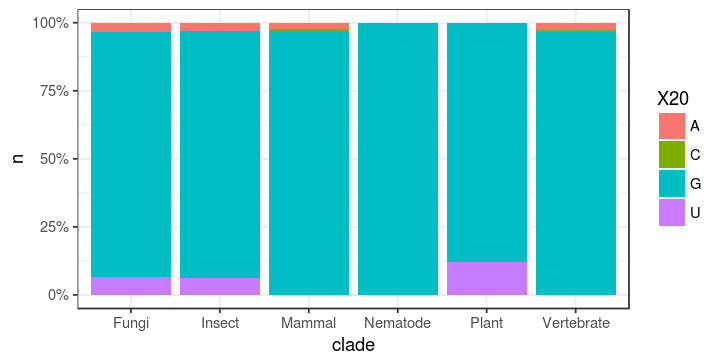

In [81]:
options(repr.plot.width=6, repr.plot.height=3)
identities %>% select(restrict, clade, species_long, X20, isotype) %>%
  filter(!restrict, isotype == "Phe") %>% count(X20, clade) %>%
  group_by(clade) %>% mutate(n = n/sum(n)) %>%
  ggplot() + geom_bar(aes(x = clade, y = n, fill = X20), stat = 'identity', position = 'stack') + 
    scale_y_continuous(labels = percent_format())

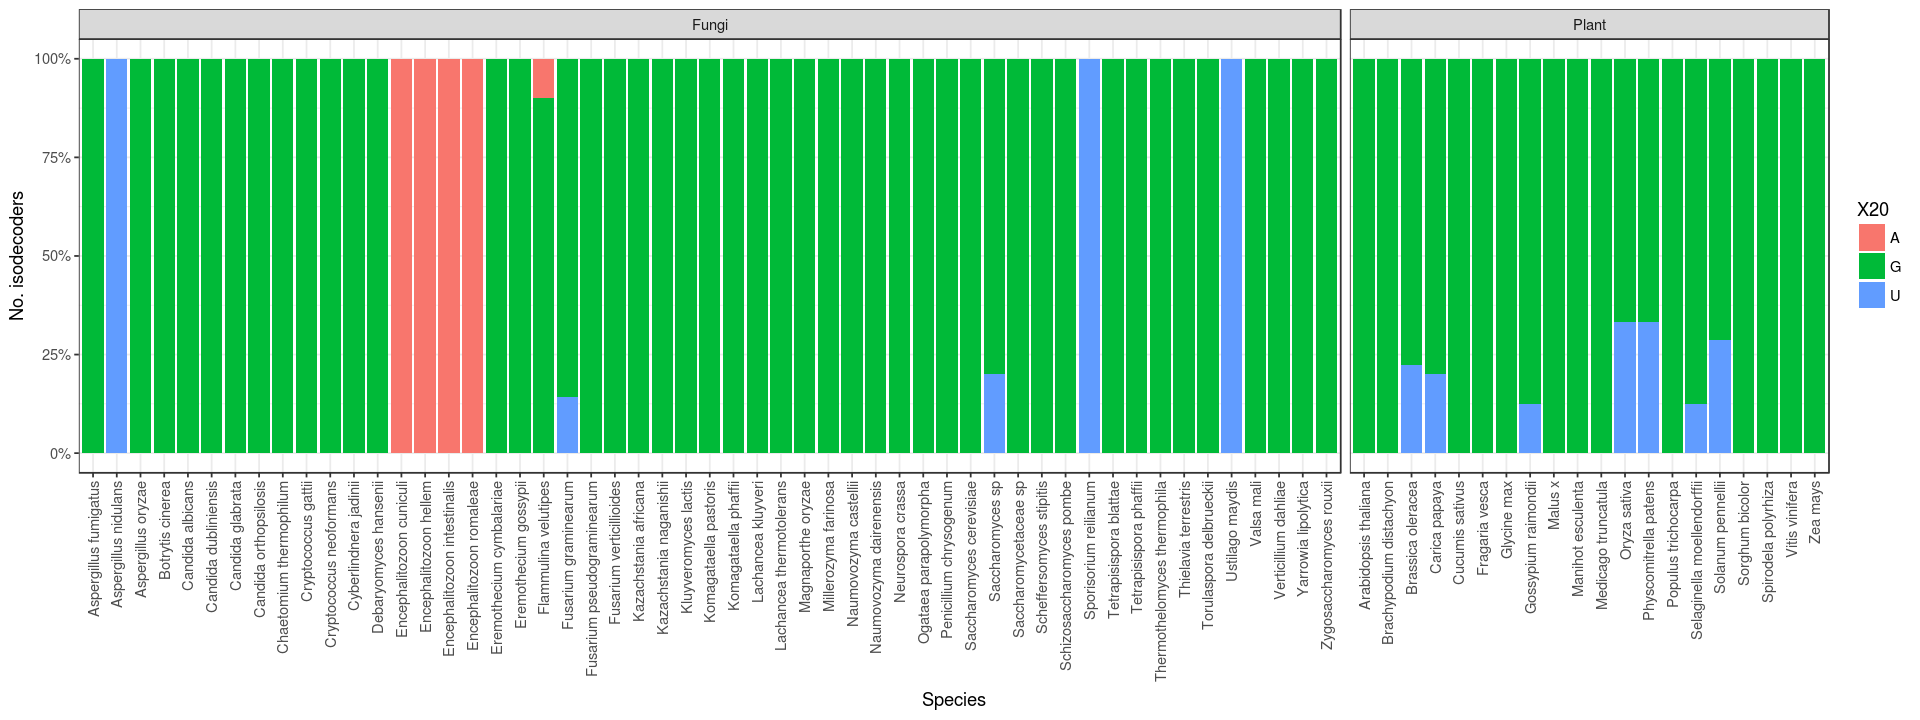

In [82]:
options(repr.plot.width=16, repr.plot.height=6)
# G20
identities %>% select(restrict, clade, species_long, X20, isotype) %>% 
  filter(!restrict, isotype == "Phe", clade %in% c('Plant', 'Fungi', '')) %>%
  mutate(species_long = str_extract(species_long, '^\\w+ \\w+')) %>%
  count(clade, species_long, X20) %>%
  group_by(clade, species_long) %>% mutate(n = n/sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X20), stat = 'identity', position = 'stack') + 
    facet_grid(~ clade, scales = "free", space = "free") +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Species", y = "No. isodecoders")

# Pro

In [83]:
# 13:22 mismatch fails fungal check
clade_iso_freqs %>% filter(isotype == "Pro", positions == "X13.22", n > 1) %>%
  spread(feature, freq, 0)

# 29 fungi tRNAs don't have a mismatch, where are they?
identities %>% filter(isotype == "Pro", clade == "Fungi") %>% count(species, X13.22) %>%
  spread(X13.22, n, 0) %>% filter(sum(c(`C:A`, `C:C`, `C:G`, `U:A`, `U:C`, `U:G`)) > 0)

,clade,isotype,positions,clade_iso_pos_total,n,CG,Mismatched,Paired,PyrimidinePurine,StrongPair,UA,UG,Wobble
1,Fungi,Pro,X13.22,229,13,0.0567685589519651,0,0,0.0567685589519651,0.0567685589519651,0,0,0
2,Fungi,Pro,X13.22,229,15,0,0,0,0,0,0,0.0655021834061135,0.0655021834061135
3,Fungi,Pro,X13.22,229,29,0,0,0.126637554585153,0,0,0,0,0
4,Fungi,Pro,X13.22,229,200,0,0.873362445414847,0,0,0,0,0,0
5,Insect,Pro,X13.22,89,2,0,0,0.0224719101123595,0,0,0,0,0
6,Insect,Pro,X13.22,89,87,0,0.97752808988764,0,0,0,0,0,0
7,Mammal,Pro,X13.22,220,219,0,0.995454545454545,0,0,0,0,0,0
8,Nematode,Pro,X13.22,87,86,0,0.988505747126437,0,0,0,0,0,0
9,Plant,Pro,X13.22,208,2,0,0,0,0,0,0.00961538461538462,0,0
10,Plant,Pro,X13.22,208,11,0.0528846153846154,0,0,0.0528846153846154,0.0528846153846154,0,0,0


,species,A:U,C:A,C:C,C:G,G:A,U:A,U:C,U:G,U:U
1,aspeFumi_AF293,0,1,0,0,0,0,0,1,7
2,botrCine_B05_10,0,0,0,8,0,0,0,0,4
3,chaeTher_VAR_THERMOPHILUM_DSM1,0,0,0,1,0,0,0,1,12
4,crypGatt_WM276,0,0,0,6,0,0,0,1,1
5,crypNeof_VAR_GRUBII_H99,0,0,0,6,0,0,0,1,1
6,crypNeof_VAR_NEOFORMANS_B_3501,0,0,0,5,0,0,0,1,1
7,crypNeof_VAR_NEOFORMANS_JEC21,0,0,0,5,0,0,0,1,1
8,enceCuni_GB_M1,0,0,1,0,0,0,0,0,2
9,enceHell_ATCC50504,0,0,1,0,0,0,0,0,2
10,enceInte_ATCC50506,0,0,1,0,0,0,0,0,2


In [84]:
# Botrytis cinerea has a lot of C13:G22s. Is a particular anticodon enriched for paired identities?
identities %>% filter(isotype == "Pro", species %in% c("botrCine_B05_10", "crypGatt_WM276", "crypNeof_VAR_NEOFORMANS_JEC21")) %>%
  count(species, anticodon, X13.22) %>% spread(X13.22, n, 0)

,species,anticodon,C:G,U:G,U:U
1,botrCine_B05_10,AGG,0,0,4
2,botrCine_B05_10,CGG,1,0,0
3,botrCine_B05_10,TGG,7,0,0
4,crypGatt_WM276,AGG,6,0,0
5,crypGatt_WM276,CGG,0,1,0
6,crypGatt_WM276,TGG,0,0,1
7,crypNeof_VAR_NEOFORMANS_JEC21,AGG,5,0,0
8,crypNeof_VAR_NEOFORMANS_JEC21,CGG,0,1,0
9,crypNeof_VAR_NEOFORMANS_JEC21,TGG,0,0,1


In [85]:
# conserved G53:C61 and U53:A61 in nematodes
identities %>% filter(isotype == "Pro", clade == "Nematode") %>% count(species, X53.61) %>%
  spread(X53.61, n, 0)

,species,A:C,G:C,G:U,U:A
1,bruMal1,0,3,0,8
2,caeJap1,0,54,1,0
3,caePb2,1,68,0,0
4,caeRem3,0,51,0,0
5,cb3,0,47,0,0
6,ce11,0,40,0,0
7,hetBac1,0,13,0,0
8,hetGly1,0,14,0,0
9,loaLoa1,0,2,0,5
10,panRed1,0,16,0,12


## Ser

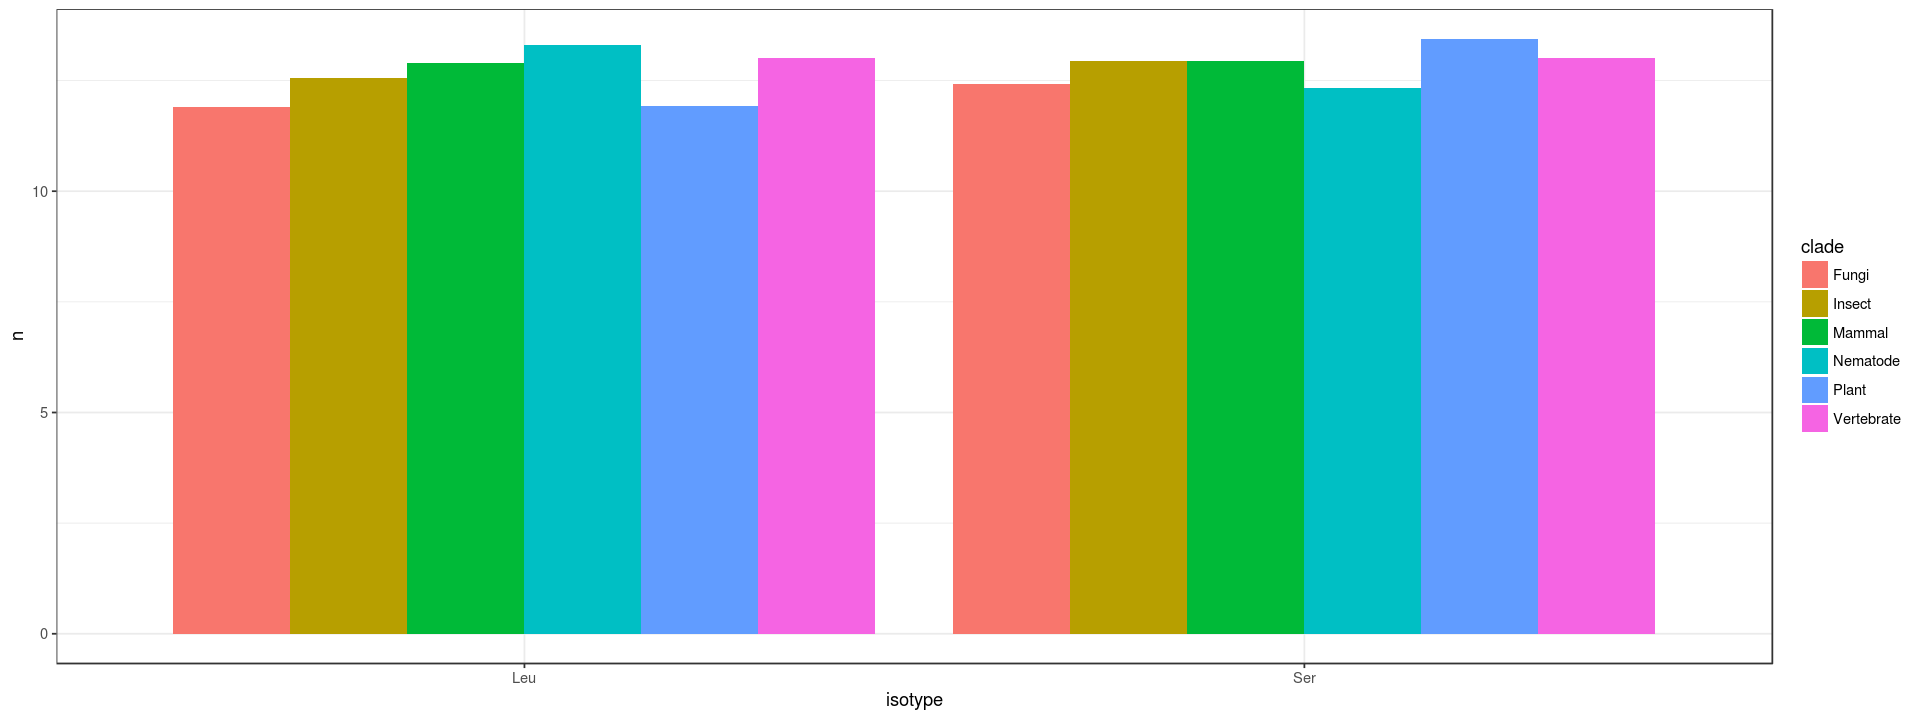

In [86]:
identities %>% select(restrict, clade, V.arm, isotype) %>% filter(!restrict, isotype %in% c("Leu", "Ser")) %>%
  group_by(isotype, clade) %>% summarize(n = mean(V.arm)) %>%
  ggplot() + geom_bar(aes(y = n, x = isotype, fill = clade), position = 'dodge', stat = 'identity')

# Thr

In [87]:
identities %>% filter(!restrict, isotype == "Thr") %>% count(clade, X73) %>% spread(X73, n, 0)

,clade,-,A,C,G,N,U
1,Fungi,0,303,2,2,0,22
2,Insect,0,77,0,0,0,32
3,Mammal,0,4,0,0,0,677
4,Nematode,0,111,1,0,0,6
5,Plant,0,201,0,0,0,89
6,Vertebrate,1,42,0,3,1,294


# Trp

In [88]:
clade_iso_freqs %>% filter(isotype == "Trp", positions == "X73") %>%
  filter(feature %in% c("A", "G", "Purine"))

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Trp,X73,115,A,114,0.991304347826087
2,Insect,Trp,X73,37,A,37,1
3,Mammal,Trp,X73,248,A,244,0.983870967741935
4,Nematode,Trp,X73,29,A,29,1
5,Plant,Trp,X73,87,A,70,0.804597701149425
6,Vertebrate,Trp,X73,111,A,110,0.990990990990991
7,Fungi,Trp,X73,115,G,0,0
8,Insect,Trp,X73,37,G,0,0
9,Mammal,Trp,X73,248,G,2,0.00806451612903226
10,Nematode,Trp,X73,29,G,0,0


In [89]:
# Plant distro of R73
identities %>% filter(!restrict, clade == "Plant", isotype == "Trp") %>%
  count(species_long, X73) %>% spread(X73, n, 0)

,species_long,A,G,U
1,Arabidopsis thaliana (TAIR10 Feb 2011),3,0,0
2,Brachypodium distachyon Bd21 (JGI v3.0),1,0,0
3,Brassica oleracea var. oleracea TO1000,14,1,0
4,Carica papaya (papaya),1,3,0
5,Cucumis sativus (cucumber),5,1,0
6,Fragaria vesca (strawberry) (v2.0.a1),2,0,0
7,Glycine max (soybean) (Wm82.a2),2,0,0
8,Gossypium raimondii (Cotton v2),3,0,0
9,Malus x domestica (apple v3.0.a1),2,1,0
10,Manihot esculenta (Cassava v6),3,0,0


# Tyr

In [90]:
# C1:G72
best_freqs %>% filter(isotype == "Tyr", positions == 'X1.72')
# C2:G71
best_freqs %>% filter(isotype == "Tyr", positions == 'X2.71')

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,Tyr,X1.72,103,CG,102,0.990291262135922
2,Mammal,Tyr,X1.72,306,CG,301,0.983660130718954
3,Vertebrate,Tyr,X1.72,141,CG,136,0.964539007092199
4,Fungi,Tyr,X1.72,132,CG,126,0.954545454545455
5,Plant,Tyr,X1.72,154,CG,140,0.909090909090909
6,Nematode,Tyr,X1.72,46,Paired,44,0.956521739130435


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Mammal,Tyr,X2.71,306,CG,301,0.983660130718954
2,Insect,Tyr,X2.71,103,CG,101,0.980582524271845
3,Vertebrate,Tyr,X2.71,142,CG,139,0.97887323943662
4,Nematode,Tyr,X2.71,46,CG,43,0.934782608695652
5,Plant,Tyr,X2.71,154,CG,140,0.909090909090909
6,Fungi,Tyr,X2.71,132,PyrimidinePurine,130,0.984848484848485


In [91]:
# which species have more non-C1:G72 isodecoders?
identities %>% filter(!restrict, isotype == "Tyr") %>%
  count(species_long, clade, X1.72) %>% spread(X1.72, n, 0) %>%
  filter(sum(c(`A:G`, `A:U`, `C:A`, `G:C`, `G:U`, `U:A`)) > `C:G`)

,species_long,clade,A:G,A:U,C:A,C:G,C:N,G:C,G:G,G:U,N:G,U:A,U:G
1,Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008),Nematode,1,1,0,1,0,0,0,0,0,0,0


In [92]:
# Nematode 1:72
identities %>% filter(!restrict, clade == "Nematode", isotype == "Tyr") %>%
  count(species_long, X1.72) %>% spread(X1.72, n, 0)
# Fungi 2:71
identities %>% filter(!restrict, clade == "Fungi", isotype == "Tyr") %>% mutate(ac = paste(X1.72, X2.71) == 'C:G C:G') %>%
  count(species_long, X2.71) %>% spread(X2.71, n, 0) 

,species_long,A:G,A:U,C:A,C:G,U:A
1,Brugia malayi,0,0,0,3,0
2,Caenorhabditis brenneri (WUGSC 6.0.1 Feb 2008),1,1,0,1,0
3,Caenorhabditis briggsae (C. briggsae Jan. 2007 WUGSC 1.0/cb3),0,0,0,2,0
4,Caenorhabditis elegans (C. elegans Feb 2013 WBcel235/ce11),0,0,0,6,0
5,Caenorhabditis japonica (WUGSC 3.0.2 Mar 2008),0,0,0,1,0
6,Caenorhabditis remanei (WUGSC 15.0.1 May 2007),0,0,1,2,0
7,Heterodera glycines (soybean cyst nematode) (OP25),0,0,0,2,1
8,Heterorhabditis bacteriophora M31e,0,0,0,2,0
9,Loa loa (V3.1),0,0,0,4,0
10,Panagrellus redivivus MT8872,0,0,0,3,0


,species_long,C:G,G:U,U:A
1,Aspergillus fumigatus Af293,1,0,0
2,Aspergillus nidulans FGSC A4,4,0,1
3,Aspergillus oryzae RIB40,8,2,0
4,Botrytis cinerea B05.10,1,0,2
5,Candida albicans WO-1,0,0,3
6,Candida dubliniensis CD36,0,0,4
7,Candida glabrata CBS 138,0,0,1
8,Candida orthopsilosis Co 90-125,0,0,1
9,Chaetomium thermophilum var. thermophilum DSM 1495,2,0,0
10,Cryptococcus gattii WM276,0,0,1


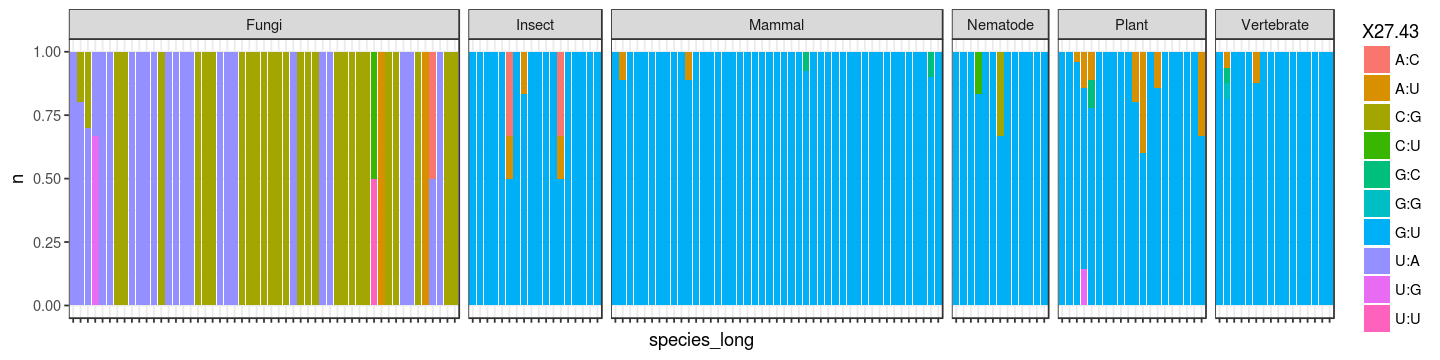

In [93]:
options(repr.plot.width=12, repr.plot.height=3)
# Fungi 27:43
identities %>% filter(!restrict, isotype == "Tyr") %>%
  count(clade, species_long, X27.43) %>% 
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(species_long, clade) %>%
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X27.43), stat = 'identity') +
    facet_grid(~ clade, scales = 'free', space = 'free') + 
    theme(axis.text.x = element_blank())

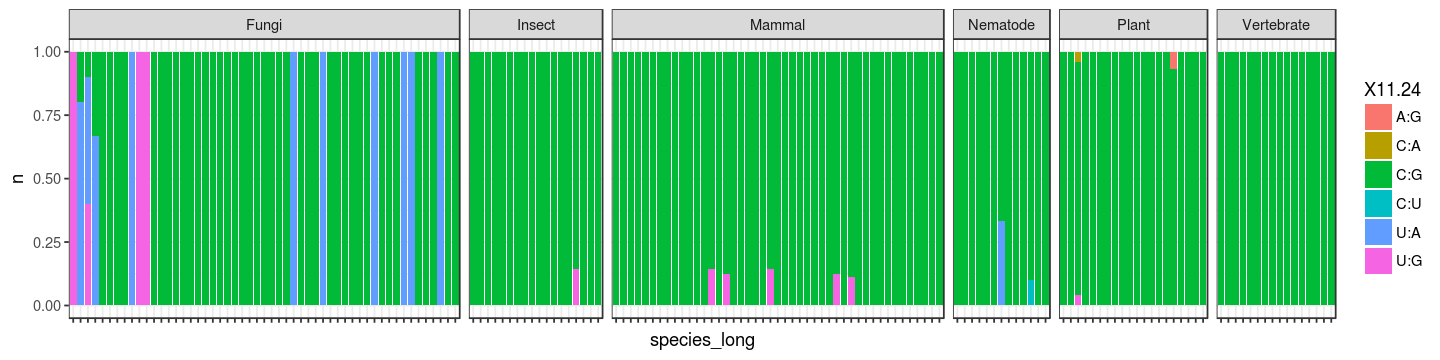

In [94]:
options(repr.plot.width=12, repr.plot.height=3)
# Fungi 27:43
identities %>% filter(!restrict, isotype == "Tyr") %>%
  count(clade, species_long, X11.24) %>% 
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(species_long, clade) %>%
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X11.24), stat = 'identity') +
    facet_grid(~ clade, scales = 'free', space = 'free') + 
    theme(axis.text.x = element_blank())

# Val

In [95]:
# R9
identities %>% filter(!restrict, isotype == "Val") %>% count(clade, X9) %>% spread(X9, n, 0)

,clade,A,C,G,U
1,Fungi,65,1,271,1
2,Insect,59,0,58,0
3,Mammal,496,0,80,0
4,Nematode,8,1,101,1
5,Plant,12,0,238,1
6,Vertebrate,238,1,10,2


In [96]:
# A/U 73
identities %>% filter(!restrict, isotype == "Val") %>%
  count(clade, X73) %>% spread(X73, n, 0)

,clade,A,C,G,N,U
1,Fungi,305,0,1,0,32
2,Insect,116,0,0,0,1
3,Mammal,569,2,3,0,2
4,Nematode,60,0,4,0,47
5,Plant,250,0,0,0,1
6,Vertebrate,239,2,0,2,8


In [97]:
# species breakdown A/U 73
identities %>% select(restrict, clade, species_long, isotype, X73) %>% filter(clade %in% c("Fungi", "Nematode"), isotype == "Val") %>%
  group_by(X73, species_long, clade) %>% tally %>% spread(X73, n, 0) %>% filter(G != 0 | U != 0) %>% arrange(clade)


,species_long,clade,A,G,U
1,Cyberlindnera jadinii NBRC 0988 NBRC0988,Fungi,11,0,3
2,Fusarium graminearum CS3005,Fungi,5,0,16
3,Fusarium graminearum PH-1 NRRL 31084,Fungi,5,0,19
4,Fusarium pseudograminearum CS3096,Fungi,4,0,20
5,Fusarium pseudograminearum CS3270,Fungi,4,0,18
6,Fusarium verticillioides 7600,Fungi,17,0,1
7,Saccharomyces cerevisiae (S288c Apr 2011),Fungi,17,1,0
8,Sporisorium reilianum SRZ2,Fungi,5,0,1
9,Torulaspora delbrueckii CBS 1146,Fungi,13,0,2
10,Verticillium dahliae JR2,Fungi,14,1,0


In [98]:
# 11:24
identities %>% filter(!restrict, isotype == "Val", clade == "Fungi") %>%
  mutate(species_long = str_extract(species_long, '^\\w+ \\w+')) %>%
  count(species_long, clade, X11.24) %>% spread(X11.24, n, 0) %>%
  filter(`U:A` == 0 | `U:G` == 0)

,species_long,clade,A:U,C:G,G:C,U:A,U:G
1,Aspergillus fumigatus,Fungi,0,1,0,5,0
2,Aspergillus nidulans,Fungi,0,0,0,4,0
3,Aspergillus oryzae,Fungi,0,2,0,6,0
4,Botrytis cinerea,Fungi,1,0,1,2,0
5,Chaetomium thermophilum,Fungi,0,1,0,10,0
6,Cryptococcus gattii,Fungi,0,2,0,1,0
7,Cryptococcus neoformans,Fungi,0,6,0,6,0
8,Encephalitozoon cuniculi,Fungi,0,0,0,3,0
9,Encephalitozoon hellem,Fungi,0,0,0,3,0
10,Encephalitozoon intestinalis,Fungi,0,0,0,3,0


In [99]:
#13:22
identities %>% filter(!restrict, isotype == "Val", clade == "Fungi") %>% count(species, X13.22) %>% spread(X13.22, n, 0) %>% filter(`U:U` < 2)

,species,A:A,A:U,C:A,C:C,C:G,G:A,G:C,U:A,U:C,U:G,U:U
1,crypGatt_WM276,0,0,0,0,2,0,1,0,0,0,0
2,crypNeof_VAR_GRUBII_H99,0,0,0,0,2,0,2,0,0,0,0
3,crypNeof_VAR_NEOFORMANS_B_3501,0,0,0,0,2,0,2,0,0,0,0
4,crypNeof_VAR_NEOFORMANS_JEC21,0,0,0,0,2,0,2,0,0,0,0
5,ogatPara_DL_1,0,0,0,0,0,0,0,0,1,0,1
6,sporReil_SRZ2,0,0,0,0,5,0,0,0,0,0,0
7,ustiMayd_521,0,0,0,0,4,0,0,1,0,0,0


# Misc sequence features

## 3D interaction freqs

In [100]:
# 9:23
identities %>% select(restrict, clade, species_long, isotype, X9.23) %>% filter(!restrict) %>%
  group_by(clade, X9.23) %>% tally %>% spread(X9.23, n, fill='.')

# 10:45
identities %>% select(restrict, clade, species_long, isotype, X10.45) %>% filter(!restrict) %>%
  group_by(clade, X10.45) %>% tally %>% spread(X10.45, n, fill='.')

# 22:46
identities %>% select(restrict, clade, species_long, isotype, X22.46) %>% filter(!restrict) %>%
  group_by(clade, X22.46) %>% tally %>% spread(X22.46, n, fill='.')

,clade,-:A,-:C,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:-,G:A,G:C,G:G,G:U,U:A,U:C,U:G,U:U
1,Fungi,.,.,947,475,102,175,4,.,25,21,.,415,995,1585,57,1,.,2,.
2,Insect,.,1,497,82,12,39,.,.,24,.,.,66,407,497,.,.,.,39,.
3,Mammal,.,.,3264,769,50,149,4,2,3,72,1,1008,1675,2625,23,11,1,6,.
4,Nematode,1,.,408,51,20,58,1,2,3,.,.,114,366,546,6,3,1,2,.
5,Plant,.,.,1661,130,221,177,1,1,70,.,.,131,665,1087,7,4,1,5,1
6,Vertebrate,.,.,1189,302,6,71,2,3,2,58,.,280,845,1331,22,7,2,3,2


,clade,A:-,A:A,A:C,A:G,A:U,C:-,C:C,C:G,G:-,G:A,G:C,G:G,G:U,U:-,U:C,U:G,U:U
1,Fungi,22,44,3,13,8,41,.,3,865,326,84,3168,147,40,8,29,3
2,Insect,1,9,.,1,.,.,.,1,258,43,1,1308,13,6,.,23,.
3,Mammal,6,1,.,32,.,4,1,10,1374,202,25,7952,28,9,.,19,.
4,Nematode,.,9,.,6,1,9,.,1,185,55,12,1144,63,93,.,3,1
5,Plant,.,13,.,8,1,193,.,18,407,186,5,3173,50,102,.,6,.
6,Vertebrate,6,.,.,23,.,3,.,9,717,151,20,3144,32,6,.,14,.


,clade,A:-,A:A,A:C,A:G,A:U,C:A,C:G,G:-,G:A,G:C,G:G,G:N,G:U,U:-,U:A,U:C,U:G,U:U
1,Fungi,10,577,23,975,31,67,39,.,378,.,1580,.,.,.,349,3,756,16
2,Insect,1,148,.,289,.,.,.,.,203,.,810,.,1,.,9,.,203,.
3,Mammal,2,1187,5,1398,21,.,21,.,934,10,5321,.,17,.,63,4,679,1
4,Nematode,1,159,3,288,17,1,1,.,172,3,720,1,.,.,15,.,201,.
5,Plant,34,261,3,535,20,4,7,1,656,5,1956,.,3,9,60,1,607,.
6,Vertebrate,.,507,18,706,11,1,4,.,445,2,1992,.,17,.,35,.,383,4


## Intron Y32 R37 requirements

In [101]:
identities %>% filter(!restrict) %>% nrow

[1] 26000

In [102]:
# No. tRNAs without Y32 or R37
identities %>% filter(!restrict, (X32 %in% c("A", "G")) | (X37 %in% c("C", "U"))) %>% nrow

[1] 175

In [103]:
# No. intronic tRNAs without Y32 or R37
identities %>% filter(!restrict, (X32 %in% c("A", "G")) | (X37 %in% c("C", "U")), intron > 6) %>% nrow

[1] 34

In [104]:
# Y32 divergence
identities %>% filter(!restrict, X32 %in% c("A", "G"), intron > 0) %>% 
  count(clade, species_long, seqname, isotype, X32)

# R37 divergence
identities %>% filter(!restrict, X37 %in% c("C", "U"), intron > 0) %>% 
  count(clade, species_long, seqname, isotype, X37)

# avg. score and isoscore_ac
identities %>% filter(!restrict, (X37 %in% c("C", "U")) | (X32 %in% c("A", "G")), intron > 0) %>% 
  select(clade, species_long, seqname, isotype, score, isoscore_ac, X32, X37, intron)


,clade,species_long,seqname,isotype,X32,n
1,Fungi,Candida albicans WO-1,candAlbi_WO_1_chrsupercont1.1.trna5-LeuAAG,Leu,G,1
2,Fungi,Candida dubliniensis CD36,candDubl_CD36_chr1.trna15-LeuAAG,Leu,G,1
3,Fungi,Candida dubliniensis CD36,candDubl_CD36_chrR.trna1-LeuAAG,Leu,G,1
4,Fungi,Candida orthopsilosis Co 90-125,candOrth_CO_90_125_chr1.trna14-LeuAAG,Leu,G,1
5,Fungi,Eremothecium cymbalariae DBVPG#7215,eremCymb_DBVPG#7215_chr5.trna15-LeuCAG,Leu,G,1
6,Fungi,Eremothecium gossypii ATCC 10895,ashbGoss_ATCC10895_chrIV.trna14-LeuCAG,Leu,G,1
7,Fungi,Flammulina velutipes KACC42780,flamVelu_KACC42780_chr2.trna3-LeuTAG,Leu,A,1
8,Fungi,Flammulina velutipes KACC42780,flamVelu_KACC42780_chr4.trna25-PheGAA,Phe,G,1
9,Fungi,Flammulina velutipes KACC42780,flamVelu_KACC42780_chr5.trna8-LeuCAG,Leu,A,1
10,Fungi,Flammulina velutipes KACC42780,flamVelu_KACC42780_chr7.trna14-AsnATT,Asn,A,1


,clade,species_long,seqname,isotype,X37,n
1,Fungi,Aspergillus fumigatus Af293,aspeFumi_AF293_chr5.trna2-ThrTGT,Thr,U,1
2,Fungi,Aspergillus nidulans FGSC A4,aspeNidu_FGSC_A4_chrVI.trna11-TyrGTA,Tyr,U,1
3,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr1.trna38-GlnTTG,Gln,U,1
4,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr3.trna23-TyrGTA,Tyr,U,1
5,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr3.trna24-TyrGTA,Tyr,U,1
6,Fungi,Penicillium chrysogenum P2niaD18,peniChry_P2NIAD18_chrI.trna18-HisATG,His,U,1
7,Fungi,Penicillium chrysogenum P2niaD18,peniChry_P2NIAD18_chrI.trna46-ThrTGT,Thr,U,1
8,Fungi,Verticillium dahliae JR2,vertDahl_JR2_chr1.trna2-ArgTCT,Arg,C,1
9,Fungi,Verticillium dahliae JR2,vertDahl_JR2_chr1.trna50-GluTTC,Glu,U,1
10,Fungi,Verticillium dahliae JR2,vertDahl_JR2_chr2.trna6-GluTTC,Glu,U,1


,clade,species_long,seqname,isotype,score,isoscore_ac,X32,X37,intron
1,Fungi,Eremothecium gossypii ATCC 10895,ashbGoss_ATCC10895_chrIV.trna14-LeuCAG,Leu,51.9,76.9,G,G,150
2,Fungi,Aspergillus fumigatus Af293,aspeFumi_AF293_chr5.trna2-ThrTGT,Thr,63.4,68,C,U,55
3,Fungi,Aspergillus nidulans FGSC A4,aspeNidu_FGSC_A4_chrVI.trna11-TyrGTA,Tyr,59.3,49,C,U,75
4,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr1.trna38-GlnTTG,Gln,45.8,13.6,C,U,84
5,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr3.trna23-TyrGTA,Tyr,54.5,35.8,C,U,70
6,Fungi,Aspergillus oryzae RIB40,aspeOryz_RIB40_chr3.trna24-TyrGTA,Tyr,54.4,35.8,C,U,72
7,Plant,Brassica oleracea var. oleracea TO1000,braOle1_NC_027756.1.trna48-TyrGTA,Tyr,60.5,92.1,C,C,12
8,Vertebrate,Callorhinchus milii (Elephant shark Dec. 2013 Callorhinchus_milii-6.1.3/calMil1),calMil1_KI635982.trna60-LysTTT,Lys,68.6,101.4,C,C,20
9,Fungi,Candida albicans WO-1,candAlbi_WO_1_chrsupercont1.1.trna5-LeuAAG,Leu,54.9,98,G,G,38
10,Fungi,Candida dubliniensis CD36,candDubl_CD36_chrR.trna1-LeuAAG,Leu,54.9,98,G,G,38


In [105]:
identities %>% filter(!restrict, species == "vertDahl_JR2", isotype %in% c("Arg", "Glu")) %>% 
  count(species_long, isotype, intron, score, X32, X37)

,species_long,isotype,intron,score,X32,X37,n
1,Verticillium dahliae JR2,Arg,0,60.6,U,G,1
2,Verticillium dahliae JR2,Arg,0,62.1,U,G,1
3,Verticillium dahliae JR2,Arg,0,65.8,U,G,1
4,Verticillium dahliae JR2,Arg,0,67.7,C,A,1
5,Verticillium dahliae JR2,Arg,0,68.5,U,G,1
6,Verticillium dahliae JR2,Arg,0,72.4,C,A,1
7,Verticillium dahliae JR2,Arg,8,66.6,C,A,1
8,Verticillium dahliae JR2,Arg,11,71.1,C,A,1
9,Verticillium dahliae JR2,Arg,26,64.8,C,A,1
10,Verticillium dahliae JR2,Arg,32,64.3,C,A,1


## Ile-GAT sparing

In [106]:
identities %>% select(clade, isotype, anticodon, species, score, isoscore_ac) %>% 
  filter(isotype == "Ile", clade %in% c("Mammal", "Insect")) %>%
  group_by(clade, species, anticodon) %>%
  summarize(n = length(anticodon)) %>%
  spread(anticodon, n, 0) %>% filter(GAT != 0)

,clade,species,AAT,GAT,TAT
1,Insect,mayDes1,8,2,1
2,Mammal,calJac3,9,1,5
3,Mammal,gorGor3,11,2,5
4,Mammal,hg19,14,3,5
5,Mammal,loxAfr3,39,1,4
6,Mammal,myoLuc2,7,4,2
7,Mammal,nomLeu3,11,1,5
8,Mammal,otoGar3,10,7,9
9,Mammal,panTro4,13,1,5
10,Mammal,papAnu2,10,2,5


## Base pair mismatches

In [107]:
# 3:70 in mammals
identities %>% filter(!restrict) %>%
  select(clade, species, isotype, X3.70) %>% filter(clade == "Mammal", isotype == "Gln") %>% 
  group_by(species, X3.70) %>% tally %>% spread(X3.70, n, 0)

,species,-:-,-:A,A:A,C:A,C:G,U:A,U:G
1,ailMel1,0,0,0,1,0,7,0
2,balAcu1,0,0,0,2,0,6,0
3,bosTau8,0,0,0,1,0,13,0
4,calJac3,0,0,0,2,0,5,0
5,canFam3,0,0,0,2,0,5,0
6,cavPor3,0,1,0,2,0,5,0
7,cerSim1,0,0,0,1,0,7,0
8,criGri1,0,0,0,1,0,6,0
9,dasNov3,0,0,0,3,0,4,0
10,dipOrd1,0,0,0,1,0,2,0


In [108]:
# 3:70 in vertebrates
identities %>% filter(!restrict) %>%
  select(clade, species_long, isotype, X3.70) %>% filter(clade == "Vertebrate", isotype == "Gln") %>% 
  group_by(species_long, X3.70) %>% tally %>% spread(X3.70, n, 0)

,species_long,U:A,U:G
1,Anolis carolinensis (lizard) (Broad AnoCar2.0 May 2010),5,0
2,Callorhinchus milii (Elephant shark Dec. 2013 Callorhinchus_milii-6.1.3/calMil1),10,1
3,Chrysemys picta bellii (Painted turtle Dec. 2011 v3.0.1/chrPic1),10,0
4,Gadus morhua (Atlantic cod May 2010 Genofisk GadMor_May2010/gadMor1),23,4
5,Gallus gallus (galGal4 Nov 2011),5,0
6,Gasterosteus aculeatus (stickleback) (Broad 1.0 Feb 2006),23,0
7,Geospiza fortis (Medium ground finch Apr. 2012 GeoFor_1.0/geoFor1),3,0
8,Latimeria chalumnae (Coelacanth Aug. 2011 Broad/latCha1),8,1
9,Meleagris gallopavo (turkey) (TGC Turkey_2.01 Dec 2009),2,0
10,Melopsittacus undulatus (Budgerigar Sep. 2011 WUSTL v6.3/melUnd1),2,0


In [109]:
df = identities %>% select(clade, species, isotype, X1.72) %>% filter(clade == "Vertebrate", isotype == "Ala") %>% group_by(X1.72) %>% tally

## 13:22

In [110]:
identities %>% filter(isotype %in% c("Leu", "Ser", "Val", "Pro")) %>% select(clade, species, isotype, X13.22) %>%
  group_by(clade, isotype, X13.22) %>% tally %>% spread(X13.22, n, 0)

,clade,isotype,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:A,G:C,G:G,G:U,U:A,U:C,U:G,U:U
1,Fungi,Leu,4,0,0,0,1,0,1,0,861,0,0,113,2,0,0,1
2,Fungi,Pro,0,0,0,2,2,3,33,0,2,0,0,0,1,1,20,530
3,Fungi,Ser,4,11,0,0,1,22,3,0,859,1,0,13,2,0,1,3
4,Fungi,Val,1,0,0,1,17,7,19,0,2,28,0,0,2,10,4,744
5,Insect,Leu,0,0,0,0,0,0,1,0,358,0,0,0,0,0,0,0
6,Insect,Pro,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,274
7,Insect,Ser,0,0,0,0,0,0,1,0,305,0,0,1,0,0,0,0
8,Insect,Val,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,317
9,Mammal,Leu,9,0,0,0,8,0,0,0,1138,0,0,1,1,0,0,0
10,Mammal,Pro,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,776


In [111]:
identities %>% count(isotype, clade) %>% 
  filter(isotype %in% c("Leu", "Ser", "Val", "Pro")) %>% 
  spread(isotype, n, 0)

,clade,Leu,Pro,Ser,Val
1,Fungi,983,594,920,835
2,Insect,359,276,307,318
3,Mammal,1157,778,1200,1894
4,Nematode,423,415,430,326
5,Plant,969,785,980,724
6,Vertebrate,724,493,812,483


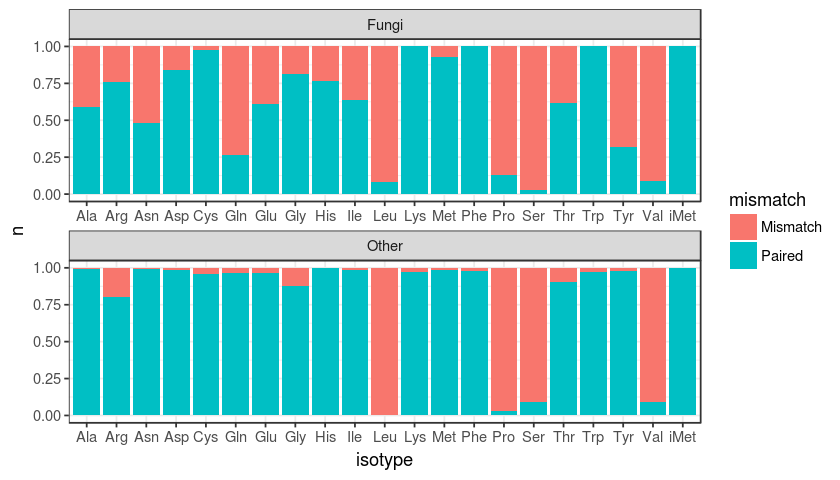

In [112]:
options(repr.plot.width=7, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  mutate(mismatch = ifelse(X13.22 %in% c("A:U", "U:A", "U:G", "G:U", "C:G", "G:C"), "Paired", "Mismatch"),
         clade = ifelse(clade == "Fungi", "Fungi", "Other")) %>%
  count(isotype, clade, mismatch) %>%
  group_by(isotype, clade) %>%
  mutate(n = n / sum(n)) %>% 
  ggplot() + geom_bar(aes(x = isotype, y = n, fill = mismatch), stat = 'identity', position = 'stack') +
    facet_wrap(~ clade, scales = 'free', ncol = 1)
#     scale_y_continuous(labels = percent_format())

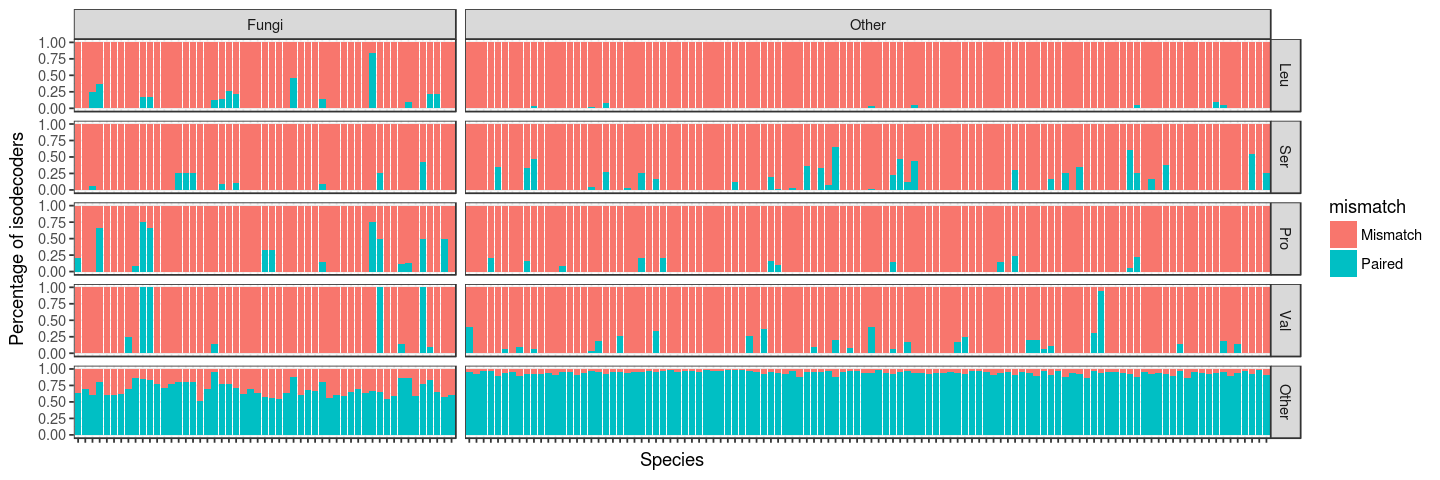

In [113]:
options(repr.plot.width=12, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  mutate(mismatch = ifelse(X13.22 %in% c("A:U", "U:A", "U:G", "G:U", "C:G", "G:C"), "Paired", "Mismatch"),
         clade = ifelse(clade == "Fungi", "Fungi", "Other"),
         isotype = ifelse(!(isotype %in% c("Pro", "Val", "Leu", "Ser")), "Other", isotype),
         species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  mutate(isotype = factor(isotype, levels = c("Leu", "Ser", "Pro", "Val", "Other"))) %>%
  count(isotype, clade, species_long, mismatch) %>%
  group_by(isotype, clade, species_long) %>%
  mutate(n = n / sum(n)) %>% 
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = mismatch), stat = 'identity', position = 'stack') +
    facet_grid(isotype ~ clade, scale = "free", space = "free") + 
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "Percentage of isodecoders")

## 12:23 in Gly

In [116]:
identities %>% filter(!restrict, isotype == "Gly") %>% select(clade, species, isotype, X12.23) %>%
  group_by(clade, species, isotype, X12.23) %>% tally %>% spread(X12.23, n, 0) %>% filter(`A:A` != 0 | `C:A` != 0 | `A:C` != 0 | `G:A` != 0 | `U:C` != 0)

,clade,species,isotype,A:A,A:C,A:U,C:A,C:G,G:A,G:C,U:A,U:C,U:G
1,Fungi,aspeFumi_AF293,Gly,0,0,0,1,2,0,1,0,0,0
2,Fungi,aspeNidu_FGSC_A4,Gly,0,0,0,1,2,0,1,0,0,0
3,Fungi,aspeOryz_RIB40,Gly,0,0,0,1,0,0,3,0,0,0
4,Fungi,neurCras_OR74A,Gly,0,2,0,0,2,0,1,2,0,0
5,Fungi,peniChry_P2NIAD18,Gly,0,0,0,1,2,0,1,1,0,0
6,Mammal,ailMel1,Gly,0,1,0,0,0,0,1,3,0,0
7,Mammal,balAcu1,Gly,0,1,0,0,0,0,2,6,0,0
8,Mammal,bosTau8,Gly,0,2,0,0,0,0,1,17,0,1
9,Mammal,calJac3,Gly,0,2,0,0,0,0,1,7,0,0
10,Mammal,canFam3,Gly,0,1,0,0,0,0,2,5,0,0


## 27:43 in Phe

In [117]:
identities %>% filter(isotype == "Phe", clade %in% c("Fungi", "Nematode")) %>% select(clade, species, isotype, X27.43) %>%
  group_by(clade, species, isotype, X27.43) %>% tally %>% spread(X27.43, n, 0) %>% filter(`A:G` != 0 | `C:A` != 0 | `G:A` != 0 | `U:U` != 0)

,clade,species,isotype,A:G,A:U,C:A,C:G,G:A,G:U,U:A,U:G,U:U
1,Fungi,flamVelu_KACC42780,Phe,11,0,0,0,1,0,5,0,0
2,Nematode,ce11,Phe,0,0,0,2,0,0,11,0,1
3,Nematode,priPac1,Phe,0,0,22,0,0,0,0,0,0


## 50:64 in Ile

In [118]:
identities %>% filter(isotype == "Ile", clade == "Insect") %>% select(clade, species, isotype, X50.64) %>%
  group_by(clade, species, isotype, X50.64) %>% tally %>% spread(X50.64, n, 0)

,clade,species,isotype,C:C,C:U,G:C,U:A,U:C,U:U
1,Insect,anoGam2,Ile,0,0,0,2,0,12
2,Insect,apiMel1,Ile,2,2,0,2,2,0
3,Insect,bomTer1,Ile,1,2,0,2,2,1
4,Insect,dm6,Ile,0,9,0,2,0,0
5,Insect,dp4,Ile,4,6,0,2,0,0
6,Insect,droAna3,Ile,0,11,0,2,0,0
7,Insect,droEre2,Ile,0,9,0,2,0,0
8,Insect,droGri2,Ile,5,2,0,2,0,0
9,Insect,droMoj3,Ile,6,2,0,2,0,0
10,Insect,droPer1,Ile,5,6,0,2,0,0


In [119]:
identities %>% filter(!restrict, species == "micMur1", isotype == "Ser")  %>% select(species, seqname, score, isotype, isoscore_ac, X5.68, X6.67, X7.66)

,species,seqname,score,isotype,isoscore_ac,X5.68,X6.67,X7.66
1,micMur1,micMur1_scaffold_670.trna1-SerGCT,91.7,Ser,125.1,A:U,G:C,G:C
2,micMur1,micMur1_scaffold_1239.trna1-SerAGA,89.6,Ser,133.1,U:A,C:G,G:C
3,micMur1,micMur1_scaffold_1700.trna3-SerGCT,88.4,Ser,127.3,A:U,G:C,G:C
4,micMur1,micMur1_scaffold_4176.trna1-SerAGA,85.9,Ser,125.9,U:A,C:G,G:C
5,micMur1,micMur1_scaffold_4176.trna4-SerTGA,87.5,Ser,130.8,U:G,C:G,G:C
6,micMur1,micMur1_scaffold_4606.trna1-SerTGA,55.3,Ser,81.2,-:-,-:-,-:-
7,micMur1,micMur1_scaffold_7354.trna1-SerGCT,83.6,Ser,124,A:U,G:C,G:C
8,micMur1,micMur1_scaffold_11157.trna2-SerGCT,91,Ser,124,A:U,G:U,G:C
9,micMur1,micMur1_scaffold_11413.trna2-SerGCT,91.9,Ser,129.8,A:U,G:C,G:C
10,micMur1,micMur1_scaffold_15535.trna2-SerTGA,90.4,Ser,133.5,U:A,C:G,G:C


In [120]:
identities %>% filter(!restrict, clade == "Mammal", isotype == "Ser") %>% select(species, X5.68, X6.67, X7.66) %>%
  gather(position, feature, -species) %>% group_by(feature) %>% tally %>% spread(feature, n, 0)

identities %>% filter(!restrict, clade == "Mammal", isotype == "Ser") %>% select(species, X5.68, X6.67, X7.66) %>%
  gather(position, feature, -species) %>% group_by(species, feature) %>% tally %>% spread(feature, n, 0)

,-:-,-:A,-:G,-:U,A:C,A:U,C:A,C:G,G:A,G:C,G:G,G:U,U:A,U:G
1,9,1,1,1,4,401,5,318,1,893,1,56,351,34


,species,-:-,-:A,-:G,-:U,A:C,A:U,C:A,C:G,G:A,G:C,G:G,G:U,U:A,U:G
1,ailMel1,0,0,0,0,0,10,0,6,0,22,1,2,6,1
2,balAcu1,0,0,0,0,0,10,1,9,0,26,0,1,14,2
3,bosTau8,0,0,0,0,0,11,0,8,0,24,0,2,11,1
4,calJac3,0,0,0,0,0,7,0,6,0,15,0,2,6,0
5,canFam3,0,0,0,0,0,9,0,5,0,19,0,1,7,1
6,cavPor3,0,0,0,0,0,7,0,4,0,15,0,0,4,0
7,cerSim1,0,0,0,0,0,9,0,7,0,21,0,2,8,1
8,criGri1,0,0,0,0,0,8,0,4,0,16,0,0,5,0
9,dasNov3,0,0,0,0,0,13,0,6,0,24,0,1,10,0
10,dipOrd1,3,1,1,1,0,6,0,4,0,13,0,1,6,0


In [121]:
# Are tRNAs with introns enriched for mismatches at 32:38?
identities %>% filter(!restrict) %>%
  mutate(intron = intron > 6, mismatch = paste0(X32, ':', X38) %in% c('U:U', 'U:C', 'C:C')) %>%
  count(intron, mismatch) %>% mutate(freq = n / sum(n))

,intron,mismatch,n,freq
1,0.000000e+00,0.000000e+00,1.381100e+04,6.397832e-01
2,0.0000000,1.0000000,7776.0000000,0.3602168
3,1.0000000,0.0000000,3198.0000000,0.7246771
4,1.0000000,1.0000000,1215.0000000,0.2753229


Joining, by = c("species_long", "isotype", "clade", "C:G", "U:A", "U:G", "position")
Joining, by = c("species_long", "isotype", "clade", "C:C", "C:U", "G:C", "U:A", "U:C", "U:U", "position")


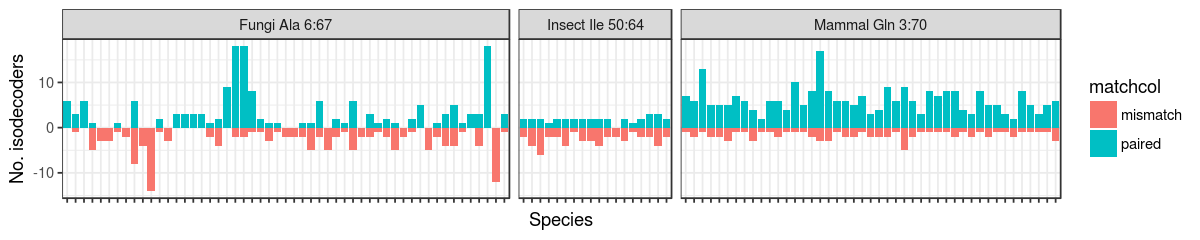

In [122]:
options(repr.plot.width=10, repr.plot.height=2)
# 6:67 mismatches in fungal alanine
identities %>% filter(!restrict, clade == "Fungi", isotype == 'Ala') %>% 
  count(X6.67, species_long, isotype, clade) %>% 
  spread(X6.67, n, 0) %>%
  mutate(position = '6:67') %>%
  full_join(identities %>% filter(!restrict, clade == "Mammal", isotype == "Gln") %>% 
              count(X3.70, species_long, isotype, clade) %>%
              spread(X3.70, n, 0) %>%
              mutate(position = '3:70')) %>%
  full_join(identities %>% filter(!restrict, clade == "Insect", isotype == "Ile") %>% 
              count(X50.64, species_long, isotype, clade) %>%
              spread(X50.64, n, 0) %>%
              mutate(position = '50:64', clade = 'Insect')) %>%
#   full_join(identities %>% filter(!restrict, isotype == "Gly") %>% 
#               count(X12.23, species_long, isotype) %>%
#               spread(X12.23, n, 0) %>%
#               mutate(position = '12:23', clade = 'All')) %>%
  replace(is.na(.), 0) %>%
  gather(feature, n, -species_long, -isotype, -clade, -position) %>%
  mutate(mismatch = !(feature %in% c('A:U', 'C:G', 'G:C', 'G:U', 'U:A', 'U:G'))) %>%
  group_by(species_long, isotype, clade, position) %>% summarize(paired = sum(ifelse(mismatch, 0, n)), mismatch = -sum(ifelse(mismatch, n, 0))) %>%
  gather(matchcol, value, paired, mismatch) %>%
  ggplot() + geom_bar(aes(x = str_extract(species_long, "^\\w+ \\w+"), y = value, fill = matchcol), stat = 'identity') + 
    facet_grid(~ paste(clade, isotype, position), scales = 'free', space = 'free') + 
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "No. isodecoders")